In [1]:
%matplotlib ipympl

In [2]:
import torch
import numpy as np
import Dataset2 as Dataset
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from time import sleep, time

importlib.reload(Dataset)
DatasetContainer = Dataset.DatasetContainer
ProcessingDatasetContainer = Dataset.ProcessingDatasetContainer

def PLTParams(figsize = [15,15]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()

import sys

sys.path.append('/remote/tychodata/ftairli/work/Projects/Graph_FD_Reconstruction/Code/')


In [4]:
DataPath = '/remote/tychodata/ftairli/data/Simulations__libraries__MCTask__Offline_v3r99p2a__IdealMC_CORSIKA__Hybrid_CORSIKA76400/SIB23c/DatasetFiles/RawData'

In [5]:
# Importing Dataset
Dataset = DatasetContainer()
Dataset.Load(DataPath,'Test' ,LoadTraces=True)

Run010 = DatasetContainer()
Run010.Load(DataPath,'Run010' ,LoadTraces=True)
print(Run010.Event_level_keys)
print(Run010.Pixel_level_keys)

Loading Test
Loading Run010
{'EventID_1/2': 0, 'EventID_2/2': 1, 'Primary': 2, 'Station_TotalSignal': 3, 'Station_Time': 4, 'Station_Theta': 5, 'Station_Phi': 6, 'Station_Distance': 7, 'Station_Chi_i': 8, 'Gen_LogE': 9, 'Gen_CosZenith': 10, 'Gen_Xmax': 11, 'Gen_dEdXmax': 12, 'Rec_LogE': 13, 'Rec_CosZenith': 14, 'Rec_Xmax': 15, 'Rec_dEdXmax': 16, 'Rec_UspL': 17, 'Rec_UspR': 18, 'Gen_SDPPhi': 19, 'Gen_SDPTheta': 20, 'Gen_Chi0': 21, 'Gen_Rp': 22, 'Gen_T0': 23, 'Gen_CoreEyeDist': 24, 'Rec_SDPPhi': 25, 'Rec_SDPTheta': 26, 'Rec_Chi0': 27, 'Rec_Rp': 28, 'Rec_T0': 29, 'Rec_CoreEyeDist': 30}
{'PixelID': 0, 'TelID': 1, 'EyeID': 2, 'Status': 3, 'Charge': 4, 'Chi_i': 5, 'Theta': 6, 'Phi': 7, 'TimeOffset': 8, 'PulseStart': 9, 'PulseCentroid': 10, 'PulseStop': 11}


(tensor([1., 2., 3., 4., 5., 6.]), tensor([416463, 840956, 931557, 927695, 833327, 387588]))
(tensor([1., 2., 3., 4.]), tensor([ 952458, 1232826, 1102668, 1049634]))


<BarContainer object of 4 artists>

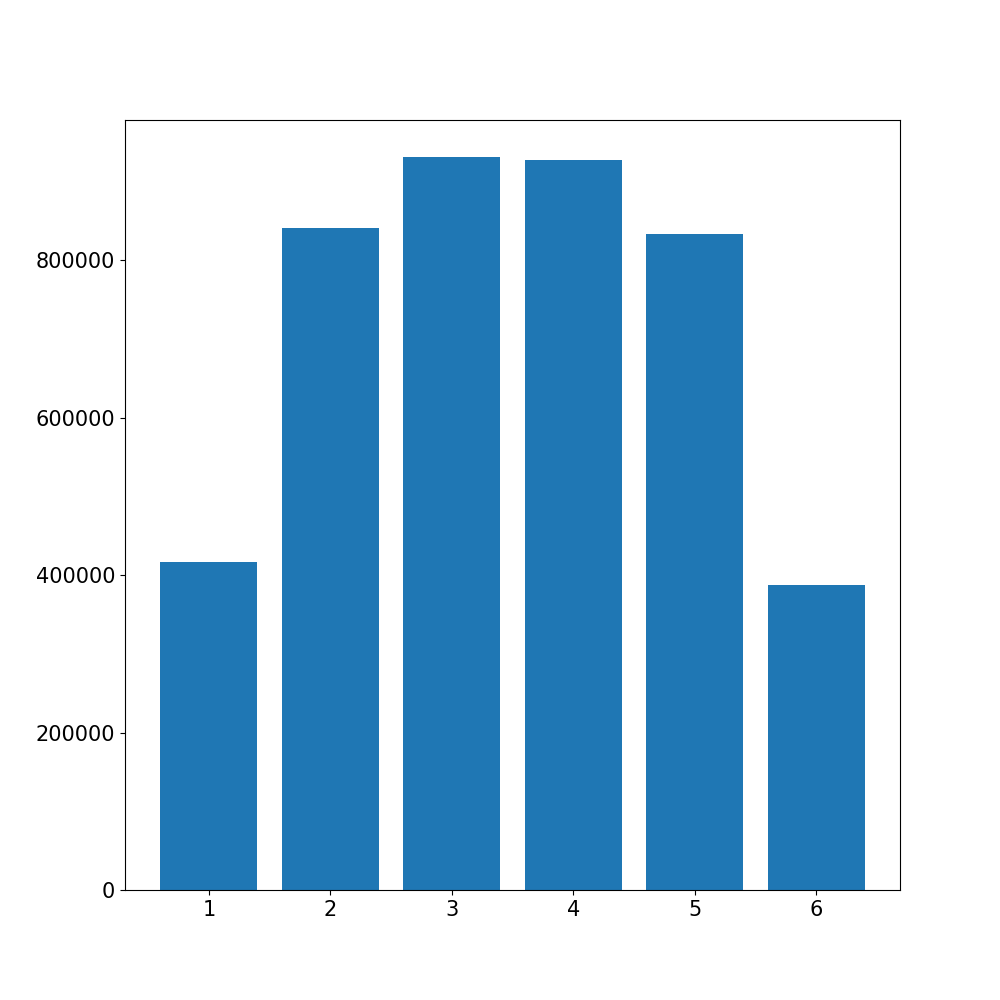

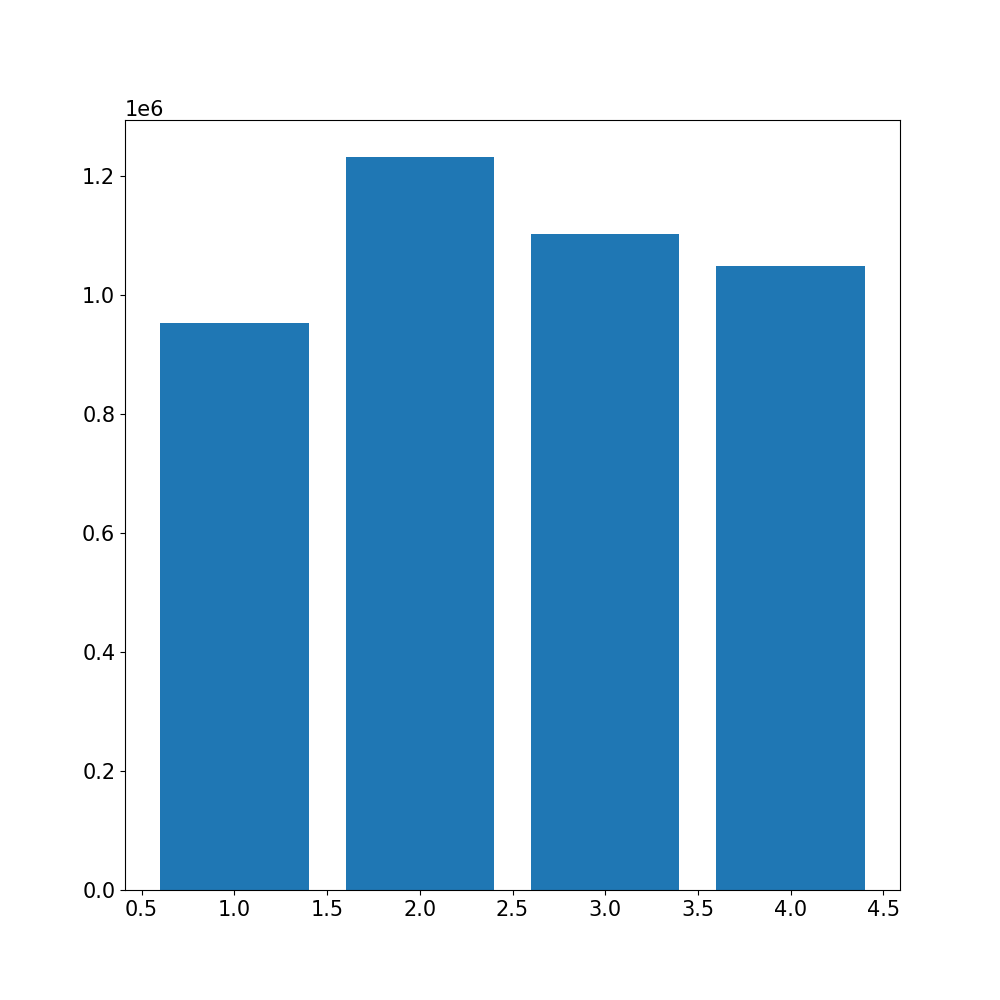

In [6]:
AllTelIDs = Run010.get_pixel_values('TelID')
plt.figure(figsize=[10,10])
unique_ids = torch.unique(AllTelIDs,return_counts=True)
print(unique_ids)
plt.bar(unique_ids[0],unique_ids[1])

AllEyeIDs = Run010.get_pixel_values('EyeID')
plt.figure(figsize=[10,10])
unique_ids = torch.unique(AllEyeIDs,return_counts=True)
print(unique_ids)
plt.bar(unique_ids[0],unique_ids[1])

# Making Graphs max-Pixels

In [7]:
EventLengths = [torch.sum(ev.get_pixel_values('Status')==4) for ev in Run010]

print('Max Event Length:',max(EventLengths))
print('Min Event Length:',min(EventLengths))


Max Event Length: tensor(140)
Min Event Length: tensor(4)


In [8]:
# # How many pixels in an event ?
# plt.figure()
# plt.hist(EventLengths,bins=100,cumulative=True,density=True)
# plt.xlabel('Event Length')
# plt.ylabel('Count')
# # plt.yscale('log')
# plt.axvline(50,color = 'r')
# plt.axvline(40,color = 'r')
# plt.grid()
# plt.show()

# print(f'99th percentile = {np.percentile(EventLengths,99)}')
# print(f'95th percentile = {np.percentile(EventLengths,95)}')
# print(f'90th percentile = {np.percentile(EventLengths,90)}')
# print(f'85th percentile = {np.percentile(EventLengths,85)}')
# print(f'80th percentile = {np.percentile(EventLengths,80)}')

# print(f'{torch.sum(torch.tensor(EventLengths)<=40.)/len(EventLengths)} 40')


In [9]:
def Theta_Phi_Cross(Theta_1,Phi_1,Theta_2,Phi_2):
    X1 = torch.sin(Theta_1)*torch.cos(Phi_1)
    Y1 = torch.sin(Theta_1)*torch.sin(Phi_1)
    Z1 = torch.cos(Theta_1)

    X2 = torch.sin(Theta_2)*torch.cos(Phi_2)
    Y2 = torch.sin(Theta_2)*torch.sin(Phi_2)
    Z2 = torch.cos(Theta_2)
    
    one = torch.stack([X1,Y1,Z1],dim=1)
    two = torch.stack([X2,Y2,Z2],dim=1)


    return torch.linalg.cross(one,two)




def cut_pixels(Pixel_Theta,Pixel_Phi,SDP_Theta,SDP_Phi,zeta=None,pixel_count=None):
    assert zeta is None, 'Zeta broken because the angle is supposed to be 90 and i havent implemented the thing to work with 90'
    if zeta is not None: assert pixel_count is None, 'must provide either zeta or pixel_count'
    if zeta is None and pixel_count is None: pixel_count = 40
    ''' returns the pixels cut by too far away from the SDP
    pretty much is a hack, cause i am not supposed to know the SDP at this point, but its whatever'''

    if zeta is None and len(Pixel_Theta)<pixel_count: return torch.ones(len(Pixel_Theta)).bool()
    
    SDP_Vector = torch.tensor([torch.sin(SDP_Theta)*torch.cos(SDP_Phi),
                                torch.sin(SDP_Theta)*torch.sin(SDP_Phi),
                                torch.cos(SDP_Theta)])
    Pixel_Vector = torch.stack([torch.sin(Pixel_Theta)*torch.cos(Pixel_Phi),
                                    torch.sin(Pixel_Theta)*torch.sin(Pixel_Phi),
                                    torch.cos(Pixel_Theta)],dim=1)
    Dot_product = torch.sum(SDP_Vector*Pixel_Vector,dim=1)
    Angle = torch.acos(Dot_product)
    if zeta is not None: return Angle<zeta
    else:
        # Find the indices of the 40 smallest angles
        _, indices = torch.topk(torch.abs(Dot_product), pixel_count, largest=False)
        mask = torch.zeros(len(Pixel_Theta), dtype=bool)
        mask[indices] = True
        
        return mask




In [25]:
def Graph_All_Connected(Dataset,ProcessingDataset = None):
    '''Produces graphs where all pixels are connected to each other'''
    PhiOffsets = {1:-75/180*torch.pi,2:-45/180*torch.pi,3:-15/180*torch.pi,4:15/180*torch.pi,5:45/180*torch.pi,6:75/180*torch.pi}
    leniency = 1.2
    max_ang_diff = 1.8*torch.sqrt(torch.tensor(3))
    # print(f'max ang diff = {max_ang_diff}')
    IDsList = ()
    Graph   = []
    AuxData = []
    for i, Event in enumerate(Dataset):
        ID = (Event.get_value('EventID_1/2').int()*100000 + Event.get_value('EventID_2/2').int()).item()
        IDsList += (ID,)

        Pix_Phi        = Event.get_pixel_values('Phi')
        Pix_Theta      = Event.get_pixel_values('Theta')
        Pix_Centroid   = Event.get_pixel_values('PulseCentroid')
        Pix_PulseStart = Event.get_pixel_values('PulseStart')
        Pix_PulseStop  = Event.get_pixel_values('PulseStop')
        Pix_Charge     = Event.get_pixel_values('Charge')
        TelID          = Event.get_pixel_values('TelID')
        PixelIDs       = Event.get_pixel_values('PixelID')
        Pixel_Status   = Event.get_pixel_values('Status')
        HEAT = (TelID == 7)+(TelID == 8)+(TelID == 9)+(Event.get_pixel_values('EyeID') == 5)

        # Going to cheat here and throw away the noise pixels before i do the graph
        # cut = (Pixel_Status == 4)
        # Pix_Phi        = Pix_Phi       [cut]
        # Pix_Theta      = Pix_Theta     [cut]
        # Pix_Centroid   = Pix_Centroid  [cut]
        # Pix_PulseStart = Pix_PulseStart[cut]
        # Pix_PulseStop  = Pix_PulseStop [cut]
        # Pix_Charge     = Pix_Charge    [cut]
        # TelID          = TelID         [cut]
        # PixelIDs       = PixelIDs      [cut]
        # HEAT           = HEAT          [cut]

        SDP_Theta = Event.get_value('Gen_SDPTheta')
        SDP_Phi   = Event.get_value('Gen_SDPPhi')
        # There is no HEAT in new Dataset, but keeping for backwards compatibility

        cut = cut_pixels(Pix_Theta/180*torch.pi,Pix_Phi/180*torch.pi,SDP_Theta,SDP_Phi,pixel_count=40)

        Pix_Phi        = Pix_Phi       [cut]
        Pix_Theta      = Pix_Theta     [cut]
        Pix_Centroid   = Pix_Centroid  [cut]
        Pix_PulseStart = Pix_PulseStart[cut]
        Pix_PulseStop  = Pix_PulseStop [cut]
        Pix_Charge     = Pix_Charge    [cut]
        TelID          = TelID         [cut]
        PixelIDs       = PixelIDs      [cut]
        Pixel_Status   = Pixel_Status  [cut]
        HEAT           = HEAT          [cut]

        if not HEAT.all(): 
            Pix_PulseStart[HEAT]= 0.5 * Pix_PulseStart[HEAT]
            Pix_PulseStop [HEAT]= 0.5 * Pix_PulseStop [HEAT]

            
            Pix_PulseWidth = (Pix_PulseStop - Pix_PulseStart)/2
            
            Pix_Time_Diff = torch.abs(Pix_Centroid  [None,:] - Pix_Centroid  [:,None])
            Pix_Time_Gap  = torch.abs(Pix_PulseWidth[None,:] + Pix_PulseWidth[:,None])
            Pix_Ang_Diff  = torch.sqrt((Pix_Phi[None,:]-Pix_Phi[:,None])**2 + (Pix_Theta[None,:]-Pix_Theta[:,None])**2)
            
            Edges = (Pix_Time_Diff < leniency*Pix_Time_Gap) & (Pix_Ang_Diff<max_ang_diff) # 
            Edges = torch.stack(torch.where(Edges),dim=1)
            Edges = Edges[Edges[:,0]!=Edges[:,1]]
            # print(Edges.shape)
            
            # Normalise Node Values
            Pix_Theta    = (90-Pix_Theta)/30
            Central_Phi  = torch.mean(Pix_Phi)
            Pix_Phi      = (Pix_Phi-Central_Phi)/40

            Pix_Centroid = Pix_Centroid/1000
            Pix_Charge   = torch.log10(Pix_Charge+1)/2.5-1
            Pix_PulseWidth = Pix_PulseWidth/50

            Node_values   = torch.stack([Pix_Theta,Pix_Phi,Pix_Centroid,Pix_Charge,Pix_PulseWidth],dim=1)

            # Edge_ang_div  = torch.sqrt((Pix_Phi[Edges[0,:]]-Pix_Phi[Edges[1,:]])**2 + (Pix_Theta[Edges[0,:]]-Pix_Theta[Edges[1,:]])**2)
            # Edge_time_div = torch.abs(Pix_Centroid[Edges[0]]-Pix_Centroid[Edges[1]])
            Edge_ang_div  = Pix_Ang_Diff[Edges[:,0],Edges[:,1]]
            Edge_time_div = Pix_Time_Diff[Edges[:,0],Edges[:,1]]

            # Normalise Edge Values
            Edge_ang_div  = Edge_ang_div/1.5
            Edge_time_div = Edge_time_div/100
            Edge_values   = torch.stack([Edge_ang_div,Edge_time_div],dim=1)
            

            Graph.append([Node_values,Edges,Edge_values])
            AuxData.append(Central_Phi)
        else:
            Node_values = torch.tensor([[0,0,0,0]])
            Edges = torch.tensor([[0,0]])
            Edge_values = torch.tensor([[0,0]])
            Graph.append([Node_values,Edges,Edge_values])
            AuxData.append(0)

    # Slap into Dataset
    if ProcessingDataset is None:
        return Graph,IDsList,AuxData
    else:
        ProcessingDataset._Graph    = Graph
        ProcessingDataset.GraphData = True
        ProcessingDataset._Aux      = AuxData
        if ProcessingDataset._EventIds is None:
            ProcessingDataset._EventIds = IDsList
        else:
            assert ProcessingDataset._EventIds == IDsList, 'Event IDs do not match'

        

Graphs,IDsList,AuxData = Graph_All_Connected(Run010,None)




In [26]:
All_Theta    = []
All_Phi      = []
All_Centroid = []
All_Charge   = []
All_Width    = []
All_Status   = []

for graph in Graphs:
    All_Theta   .append(graph[0][:,0])
    All_Phi     .append(graph[0][:,1])
    All_Centroid.append(graph[0][:,2])
    All_Charge  .append(graph[0][:,3])


In [ ]:
All_Width   .append(graph[0][:,4])
# All_Status  .append(graph[0][:,5])

All_Theta    = torch.cat(All_Theta   ).numpy()
All_Phi      = torch.cat(All_Phi     ).numpy()
All_Centroid = torch.cat(All_Centroid).numpy()
All_Charge   = torch.cat(All_Charge  ).numpy()
All_Width    = torch.cat(All_Width   ).numpy()
# All_Status   = torch.cat(All_Status  ).numpy()

# All_Theta    = All_Theta   [All_Status==4]
# All_Phi      = All_Phi     [All_Status==4]
# All_Centroid = All_Centroid[All_Status==4]
# All_Charge   = All_Charge  [All_Status==4]
# All_Width    = All_Width   [All_Status==4]
# All_Status   = All_Status  [All_Status==4]

In [ ]:
# Theta Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Theta,bins=100)
ax[0].set_title('Theta')

normTheta = (90-All_Theta)/30
ax[1].hist(normTheta,bins=100)
ax[1].set_title('Normalized Theta')


Text(0.5, 1.0, 'Normalized Phi')

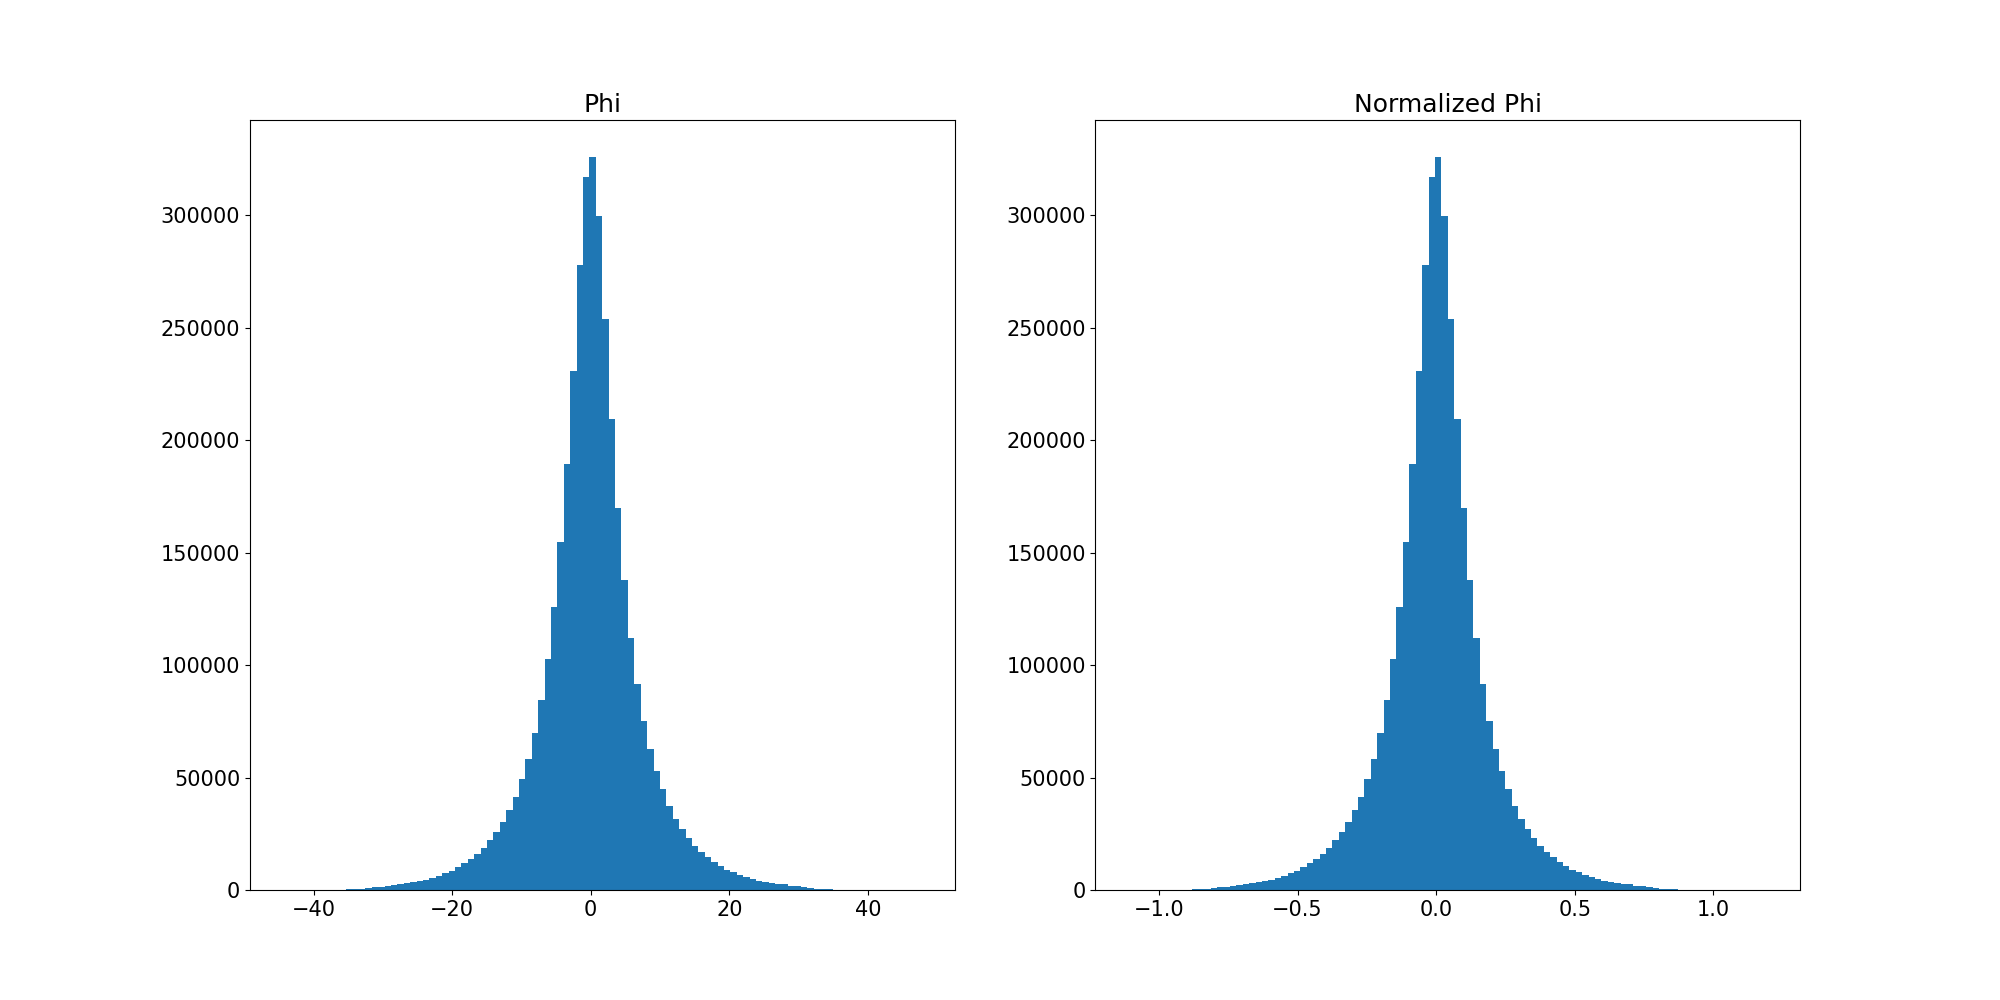

In [30]:
# Phi Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Phi,bins=100)
ax[0].set_title('Phi')
# ax[0].set_yscale('log')

normPhi = All_Phi/40
ax[1].hist(normPhi,bins=100)
ax[1].set_title('Normalized Phi')


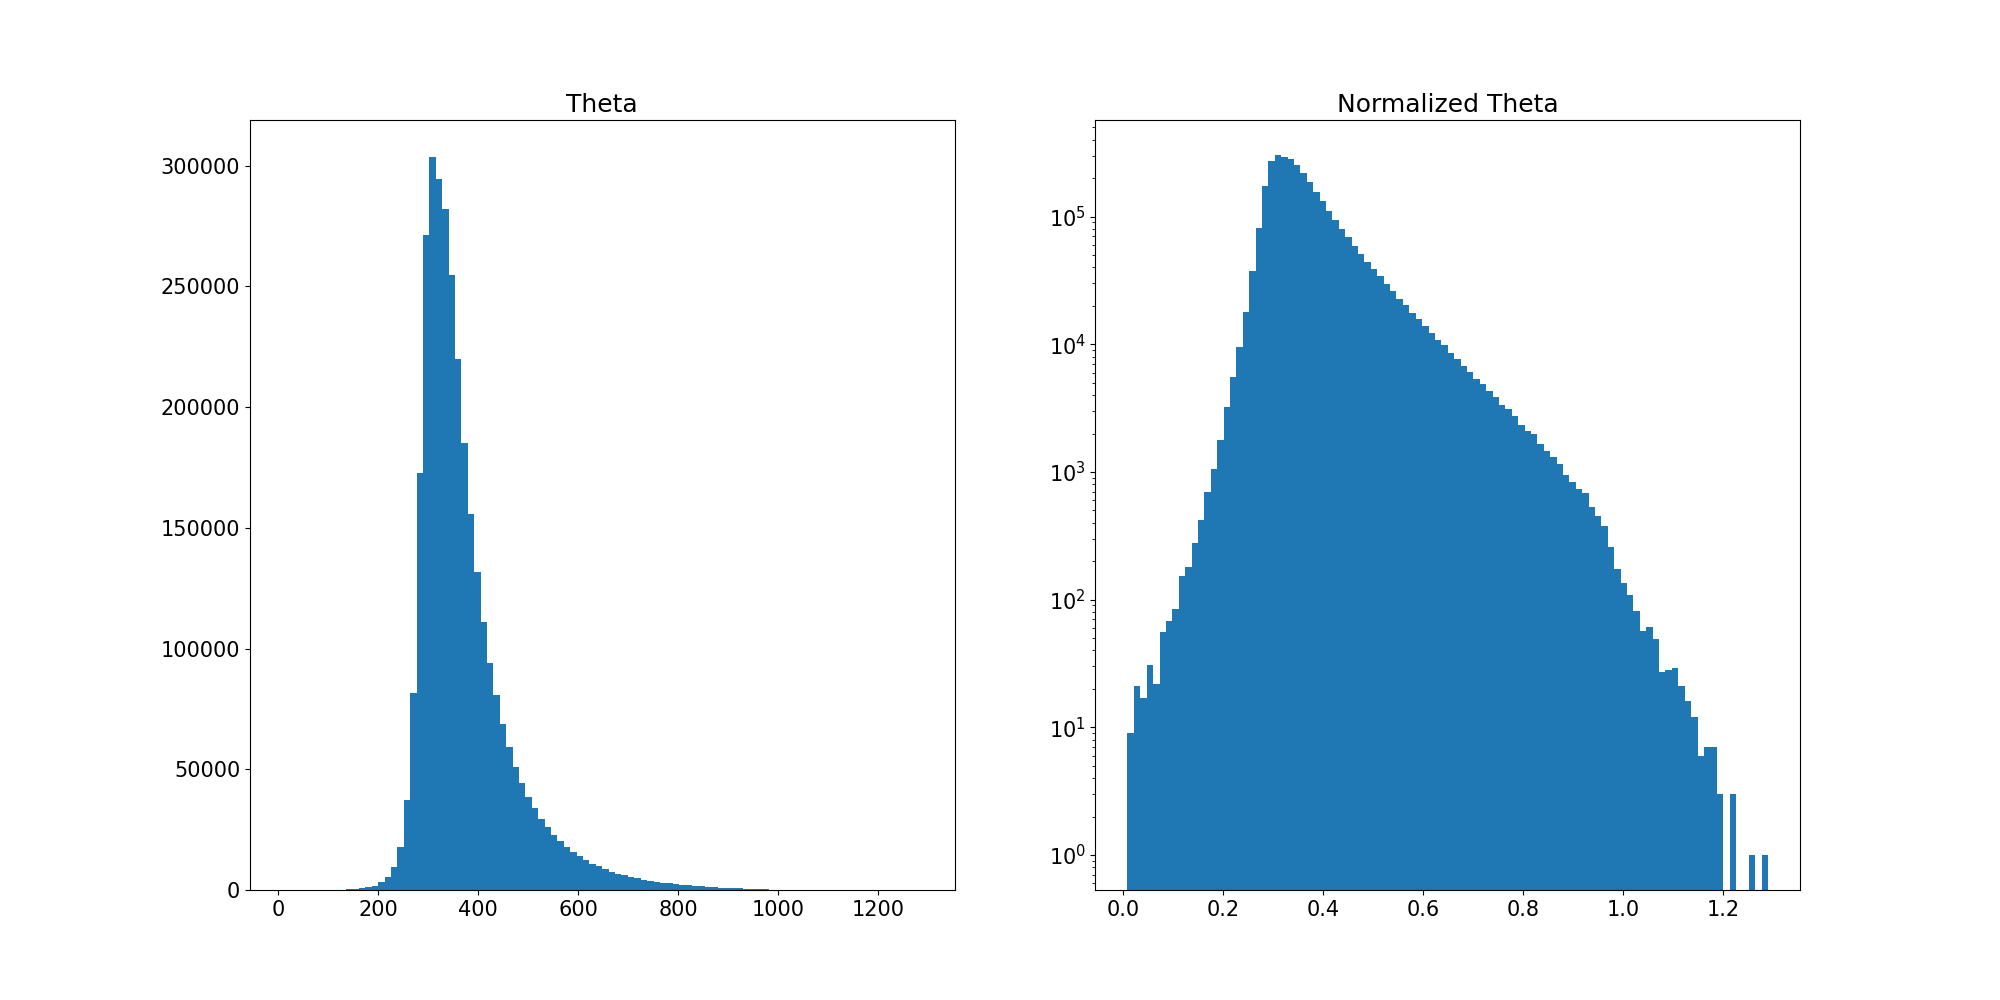

In [13]:
# Centroid Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Centroid,bins=100)
ax[0].set_title('Theta')

normCentroid = All_Centroid/1000
ax[1].hist(normCentroid,bins=100)
ax[1].set_title('Normalized Theta')
ax[1].set_yscale('log')

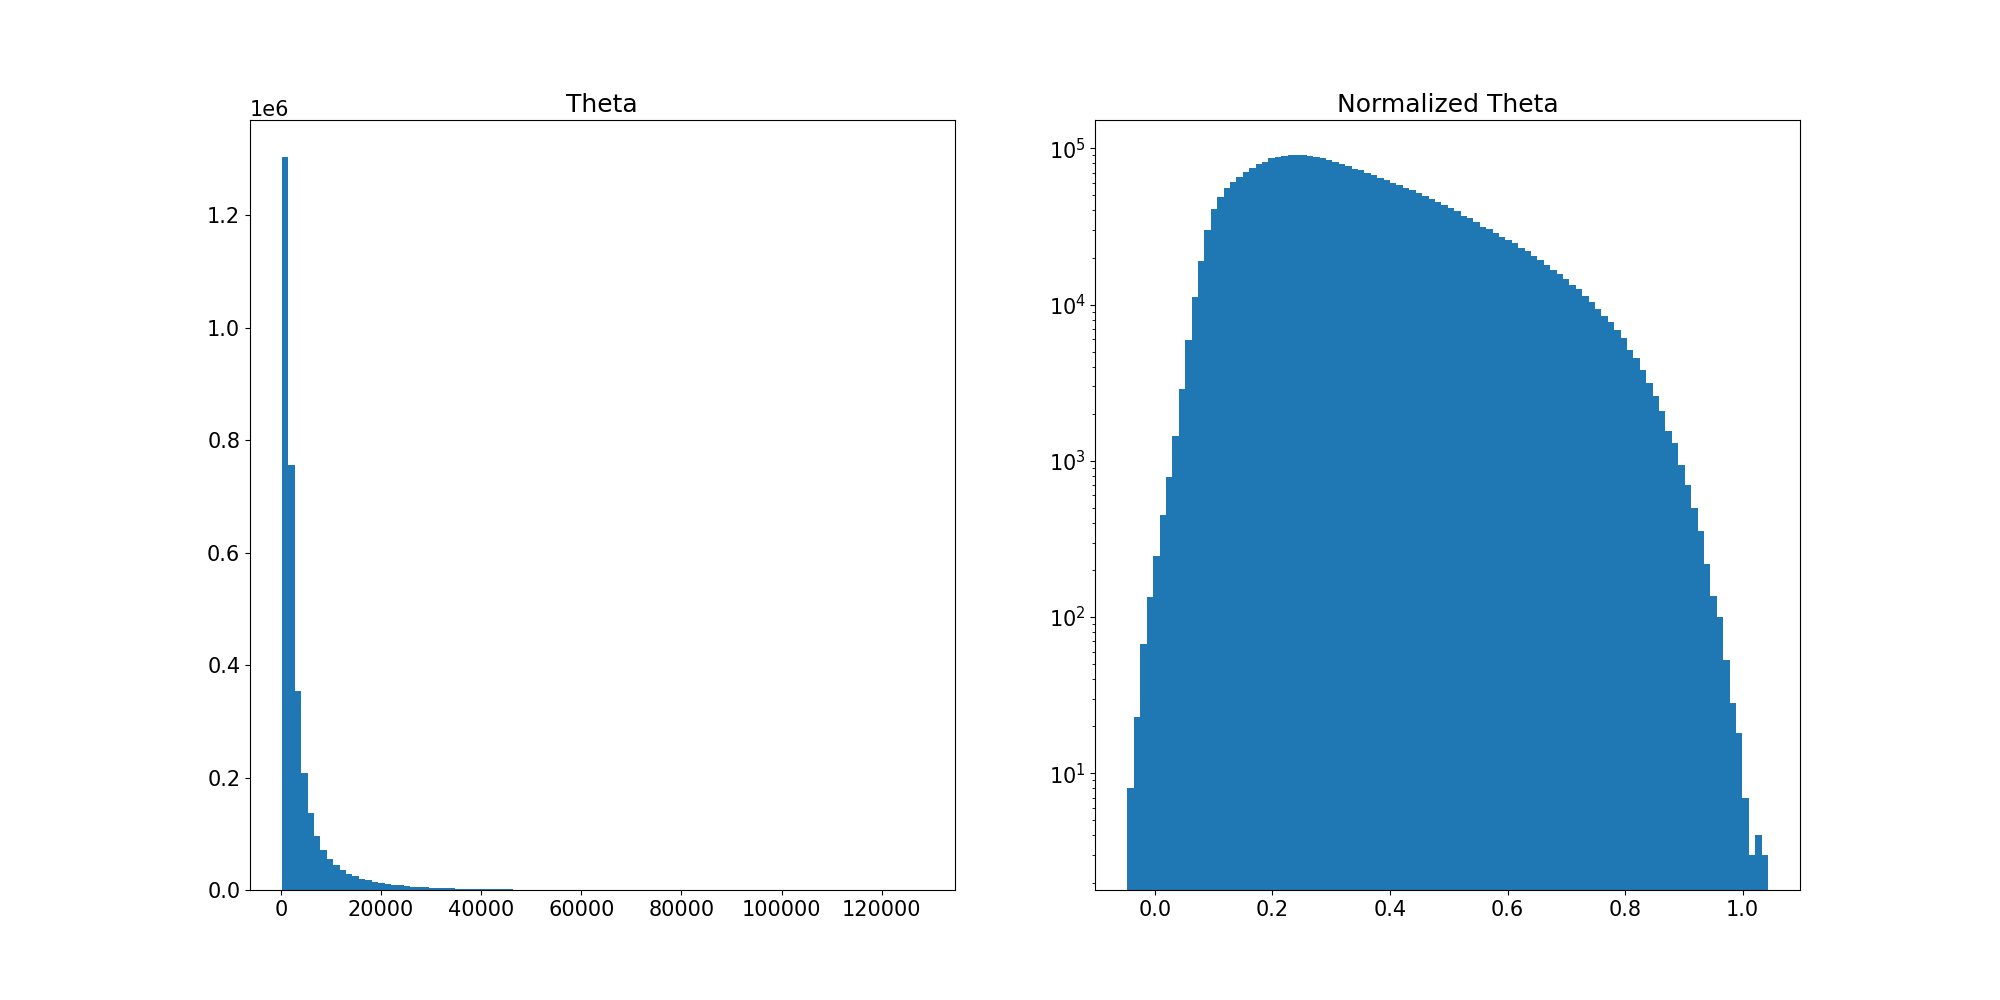

In [48]:
# Charge Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Charge,bins=100)
ax[0].set_title('Theta')

normCharge = np.log10(All_Charge+1)/2.5 - 1
ax[1].hist(normCharge,bins=100)
ax[1].set_title('Normalized Theta')
ax[1].set_yscale('log')

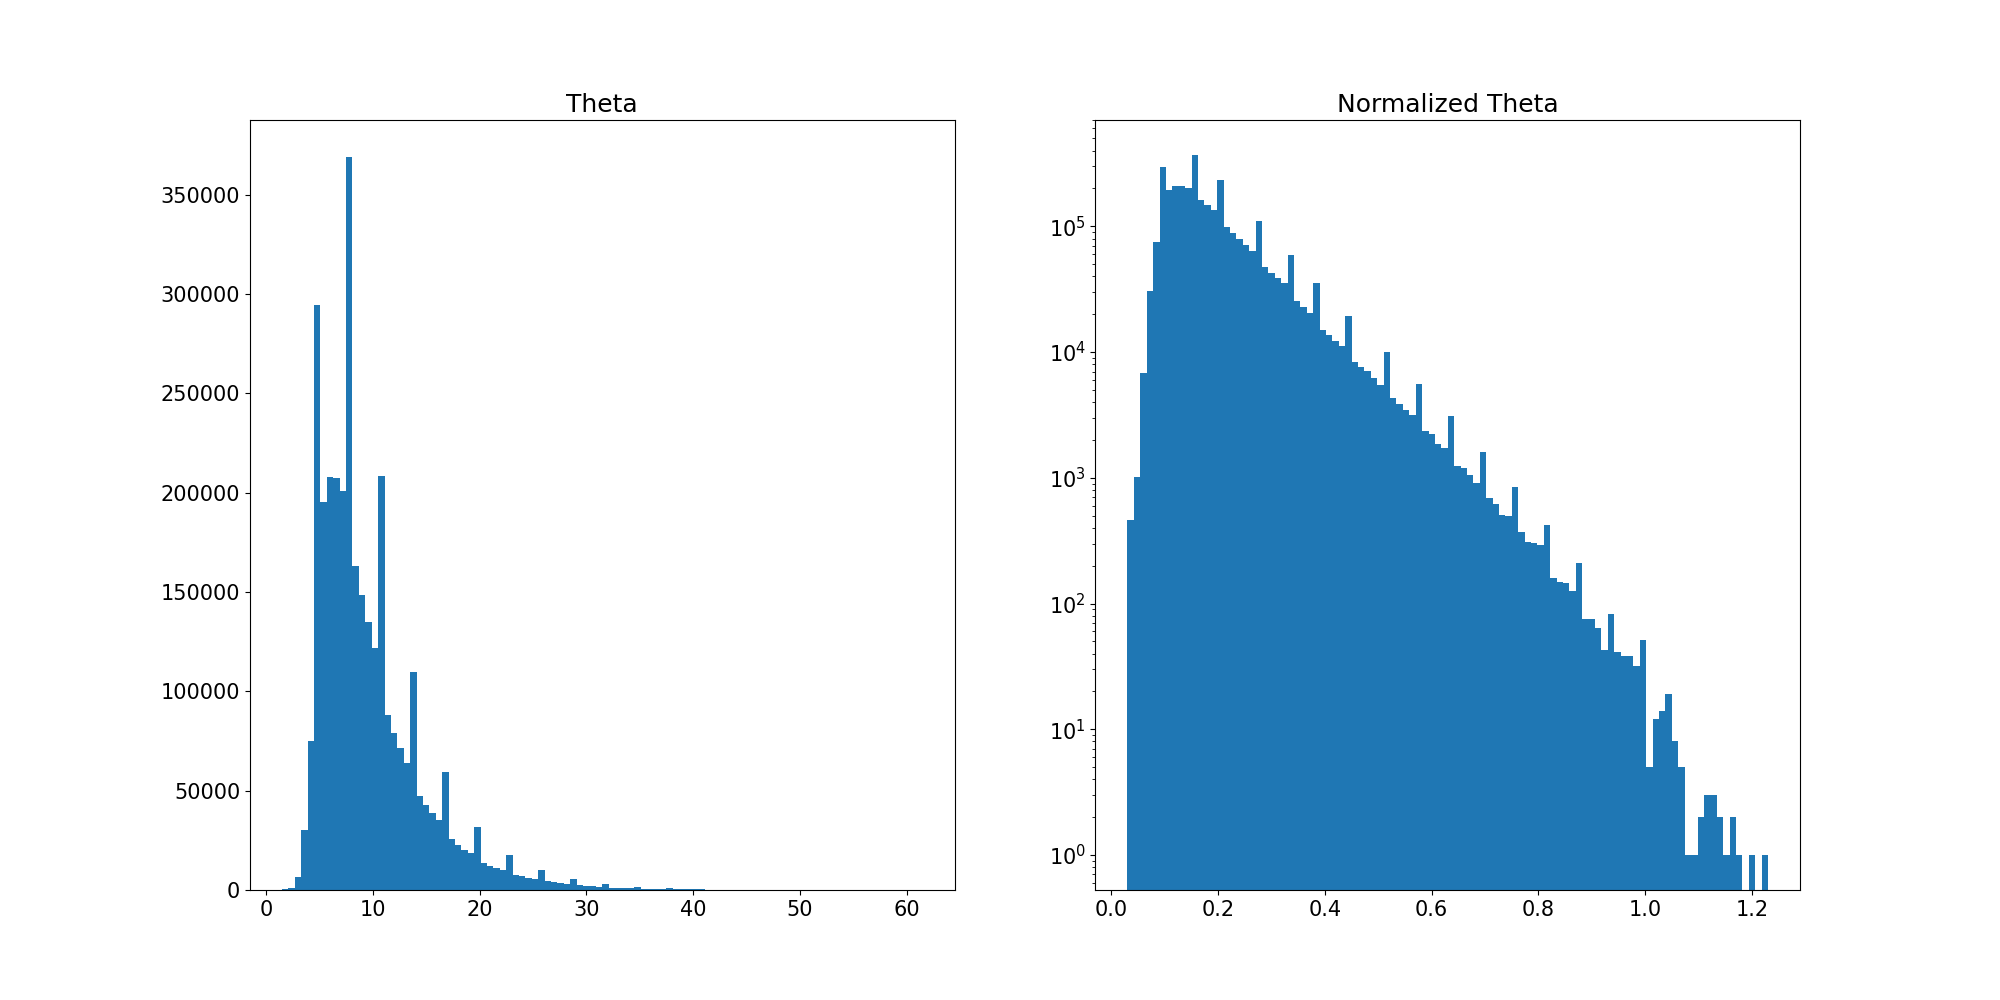

In [14]:
# Duration Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_Width,bins=100)
ax[0].set_title('Theta')

normWidth = All_Width/50
ax[1].hist(normWidth,bins=100)
ax[1].set_title('Normalized Theta')
plt.yscale('log')

In [42]:
All_AngDivs = []
All_TimeDivs = []

for graph in Graphs:
    All_AngDivs.append(graph[2][:,0])
    All_TimeDivs.append(graph[2][:,1])

All_AngDivs = torch.cat(All_AngDivs).numpy()
All_TimeDivs = torch.cat(All_TimeDivs).numpy()


/tmp/ipykernel_32198/2687694369.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize = [20,10])


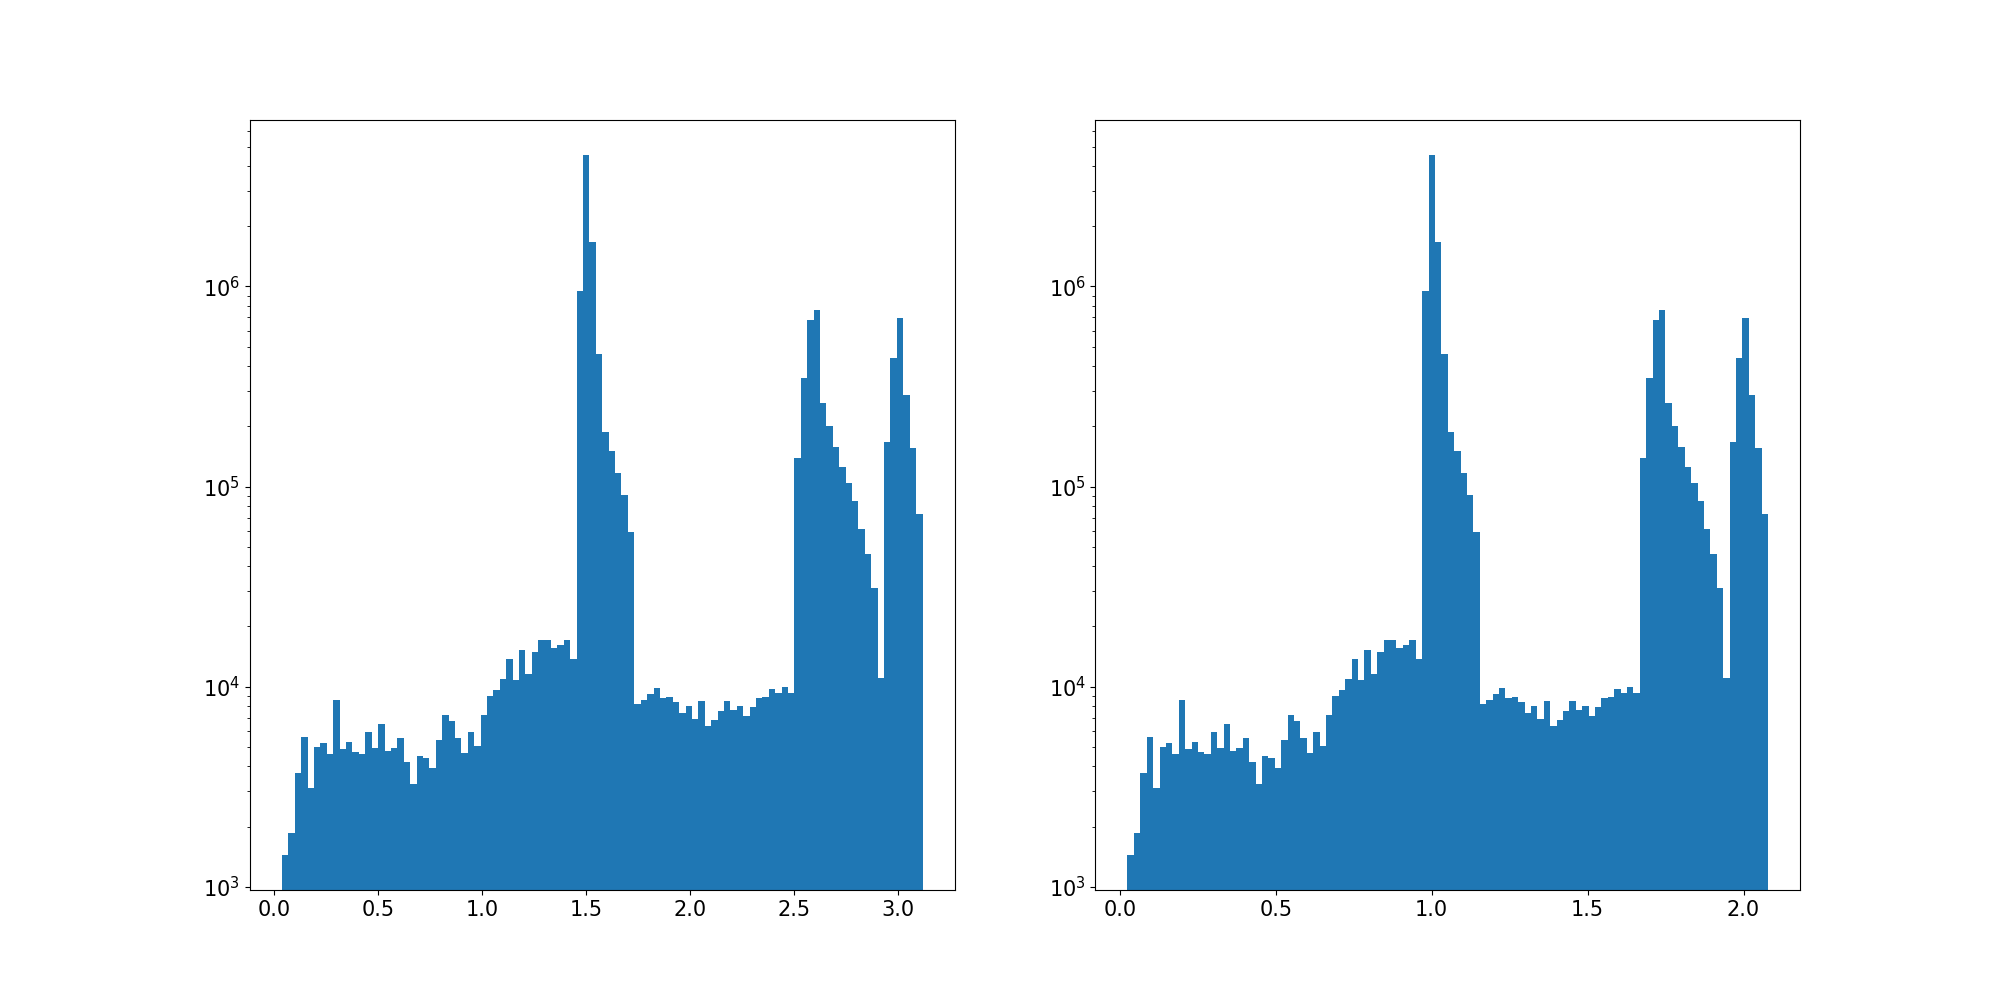

In [43]:
# Edge AngDiv Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_AngDivs,bins=100)
ax[0].set_yscale('log')

normAngDivs = All_AngDivs/1.5
ax[1].hist(normAngDivs,bins=100)
plt.yscale('log')

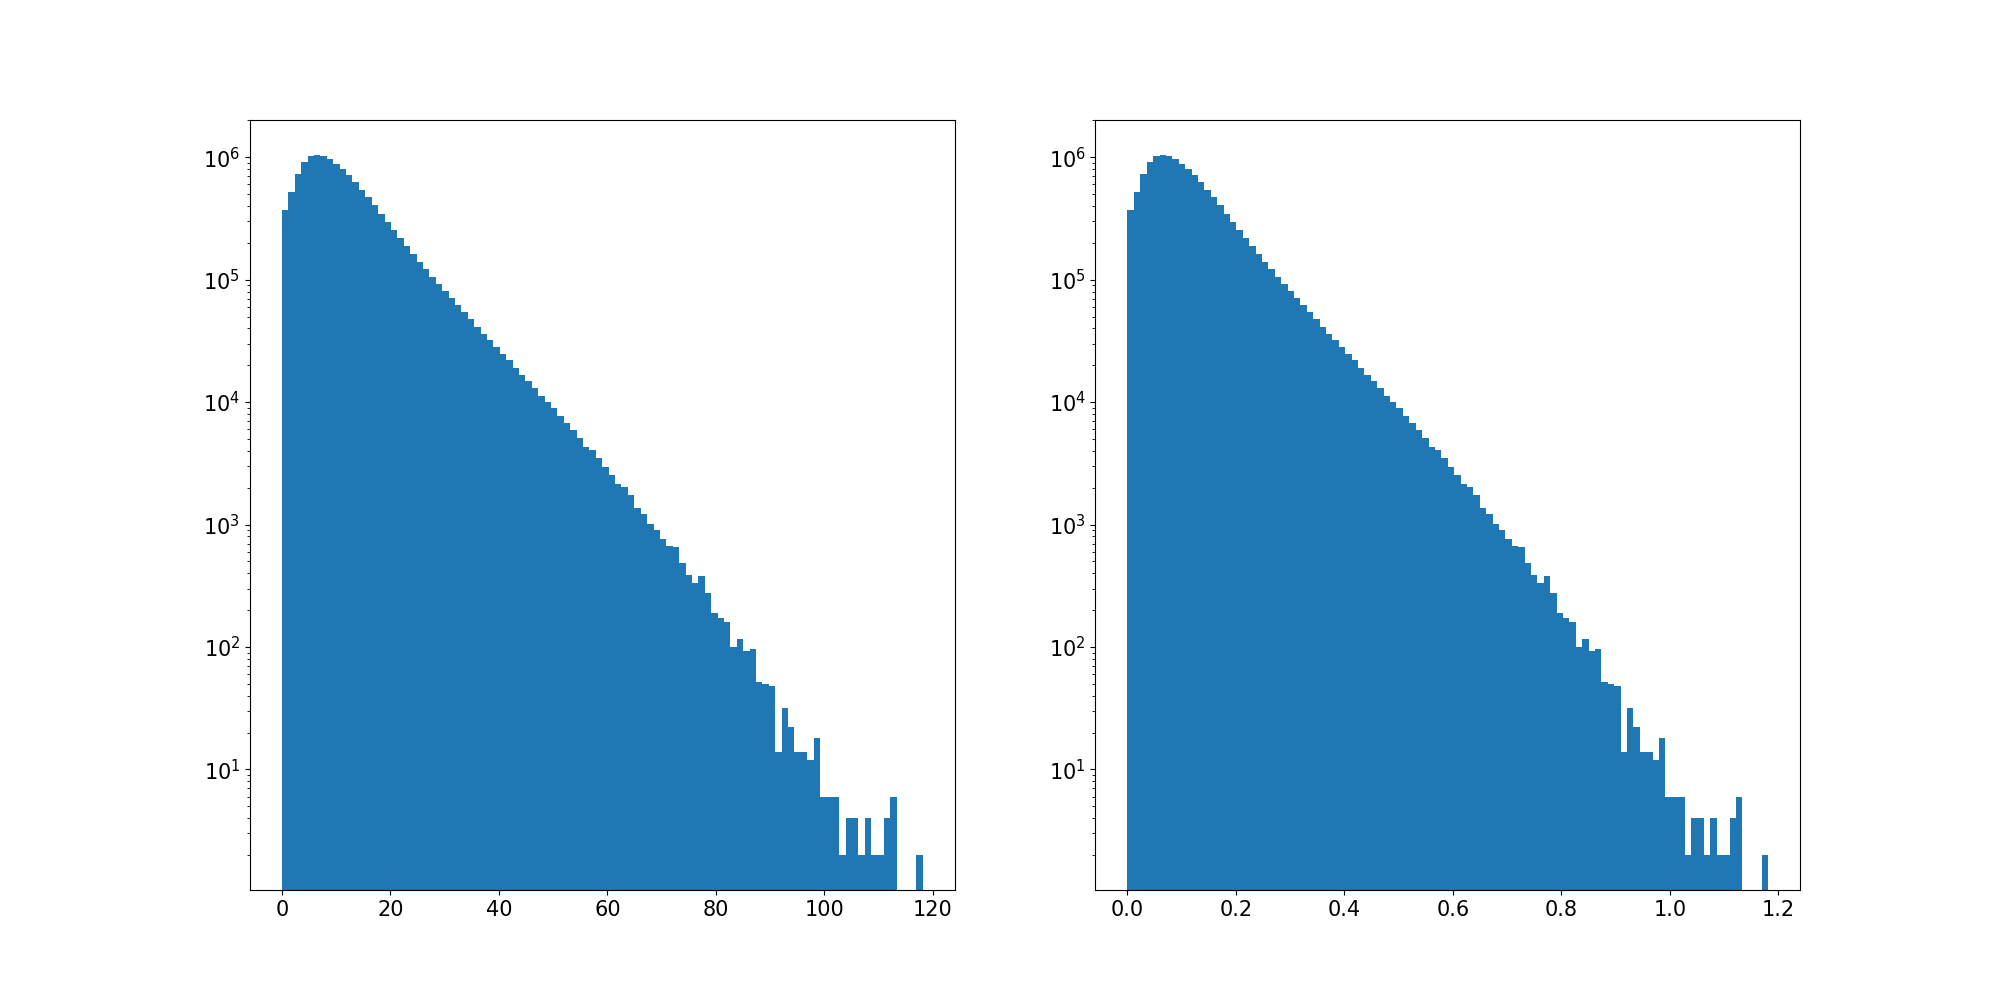

In [44]:
# Edge Time Div Normalisation
fig, ax = plt.subplots(1,2,figsize = [20,10])
ax[0].hist(All_TimeDivs,bins=100)
ax[0].set_yscale('log')

normTimeDivs = All_TimeDivs/100
ax[1].hist(normTimeDivs,bins=100)
plt.yscale('log')

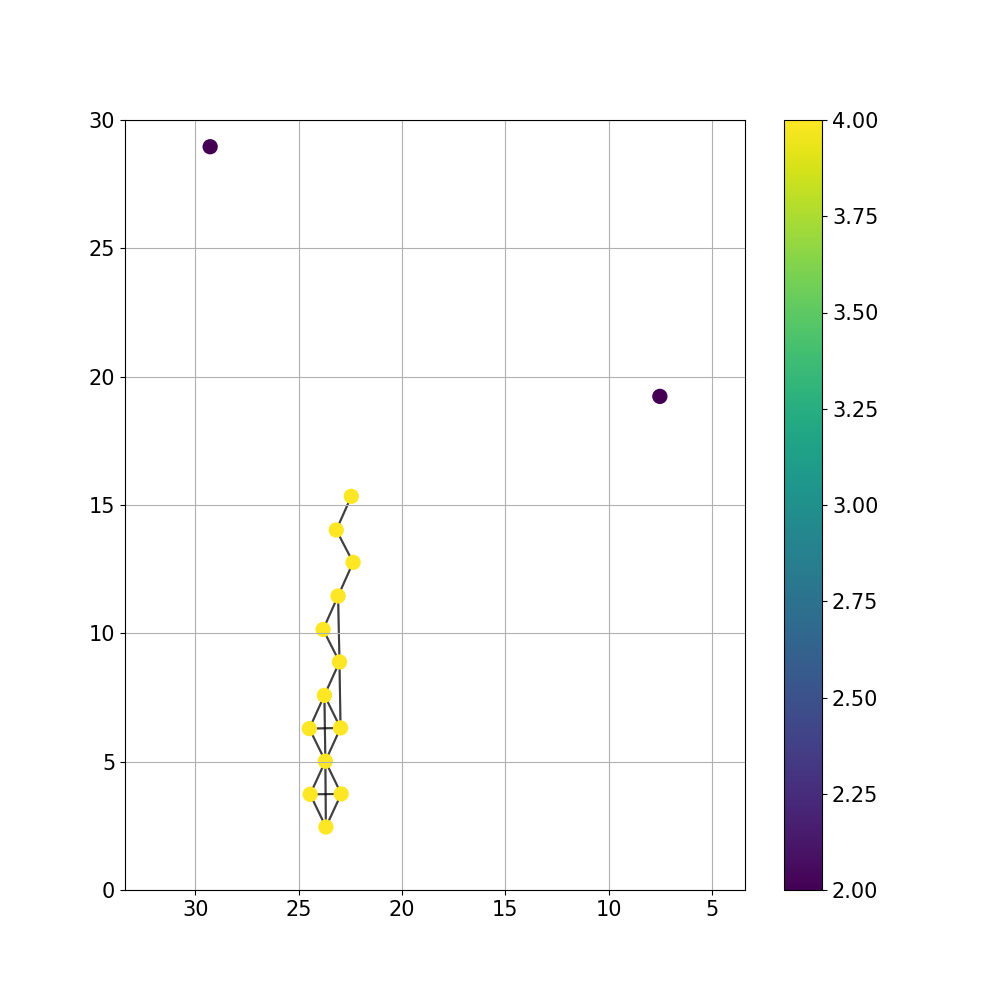

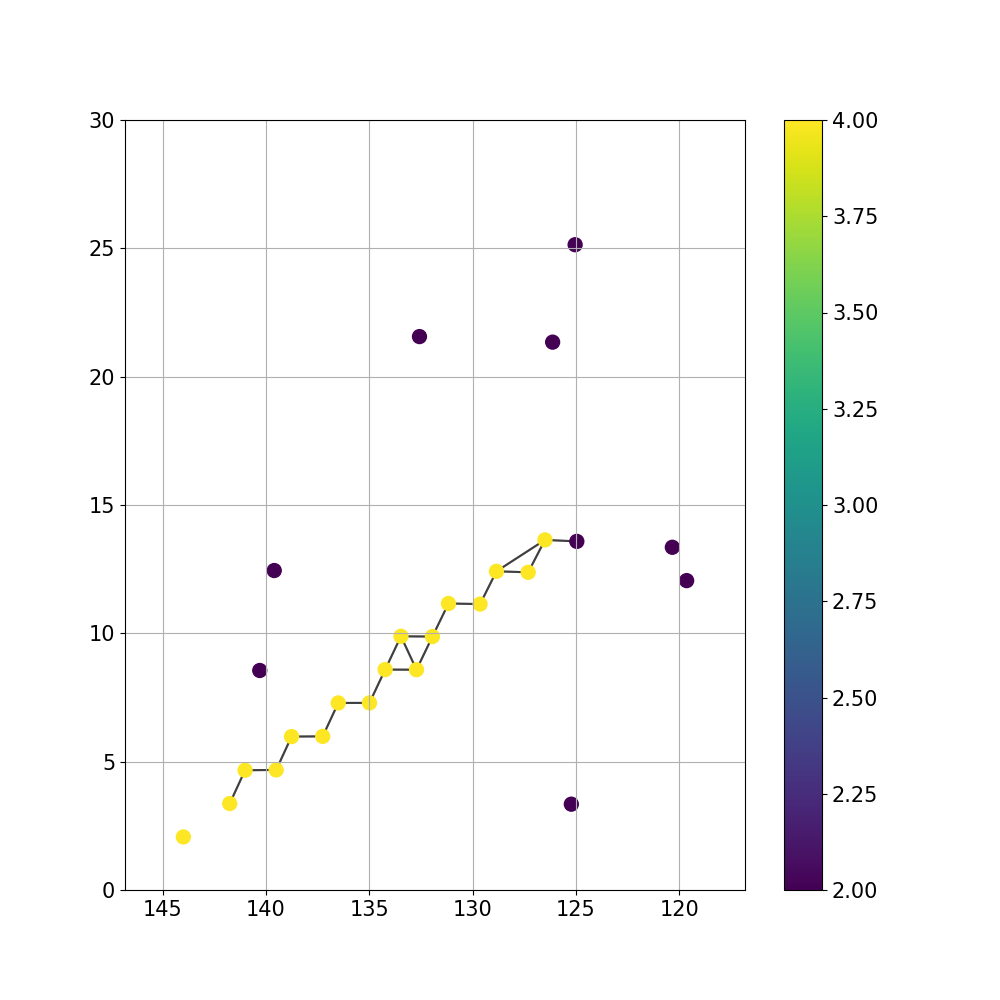

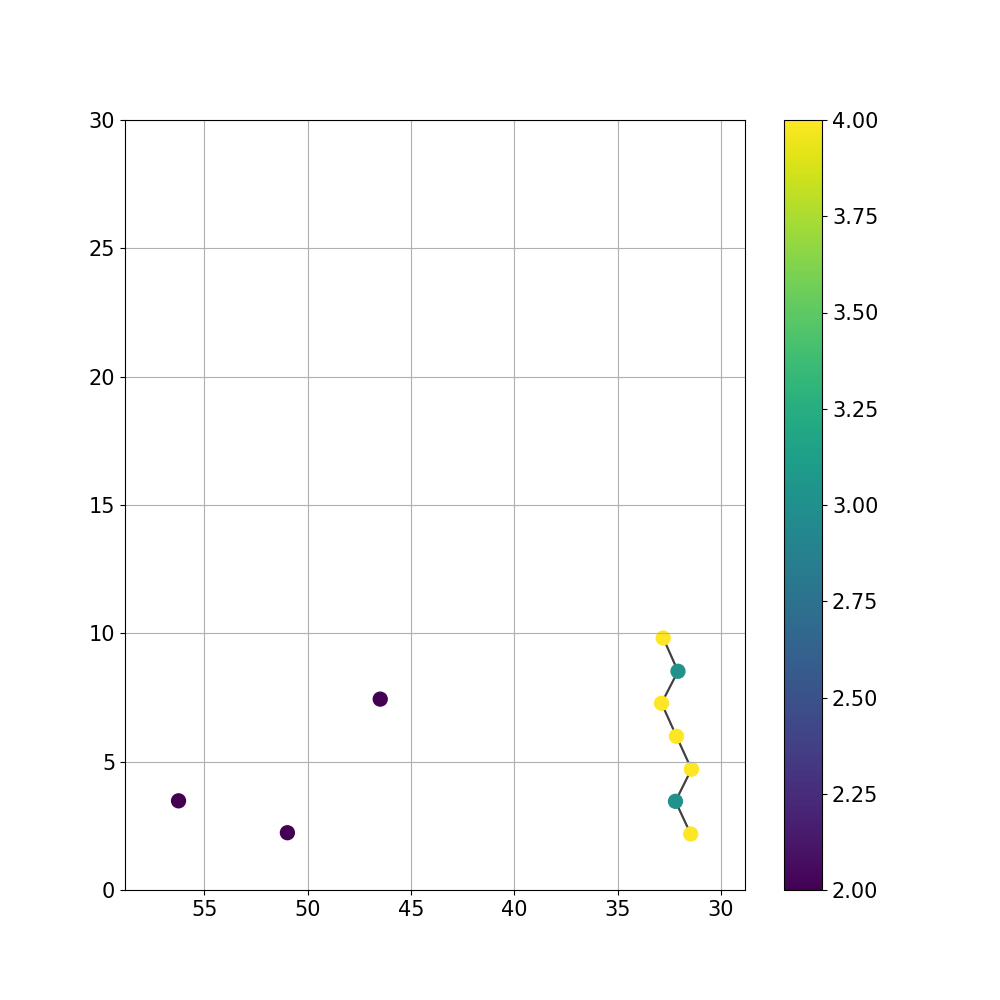

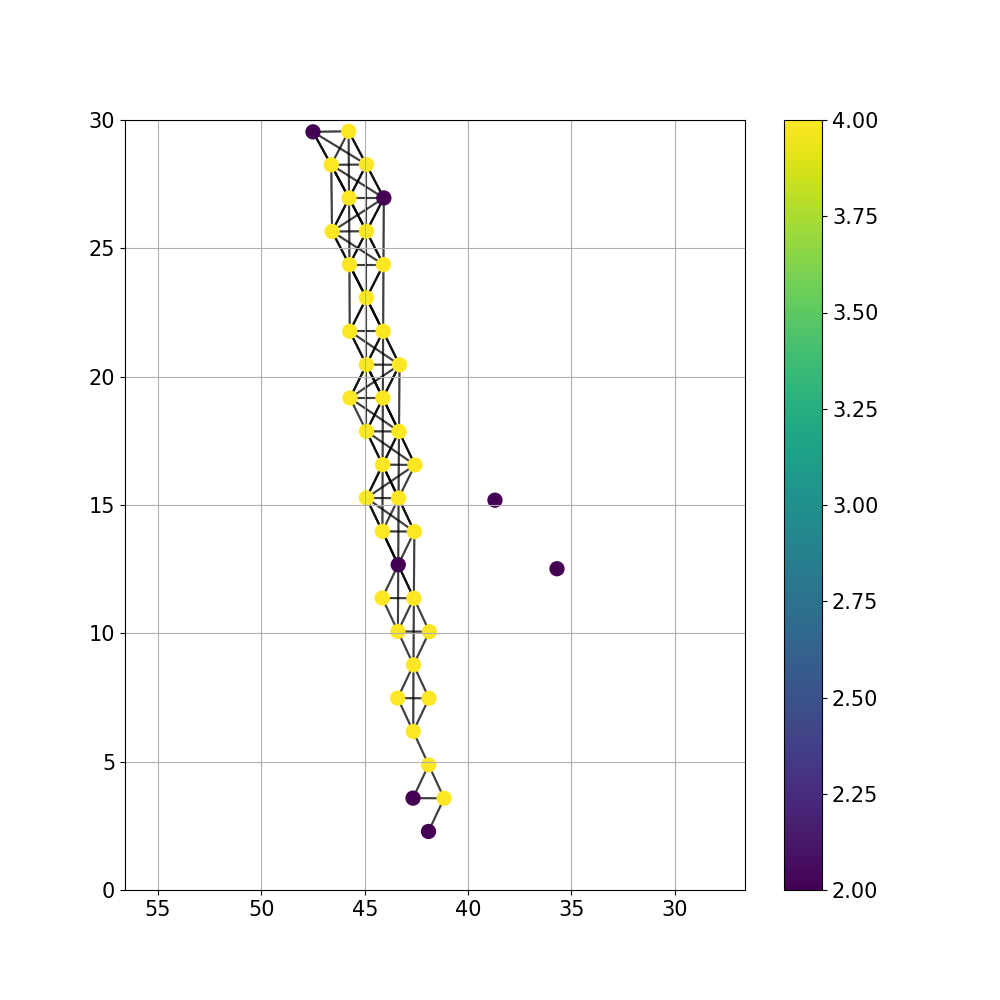

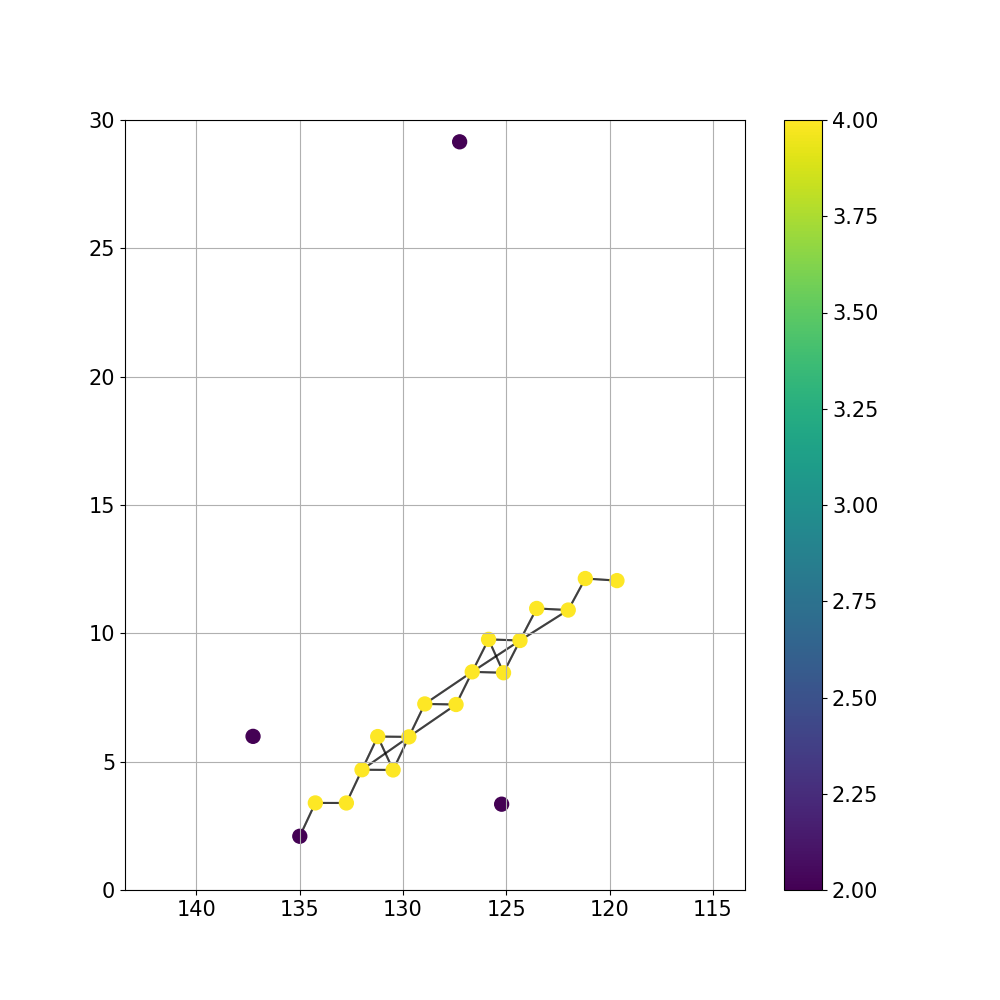

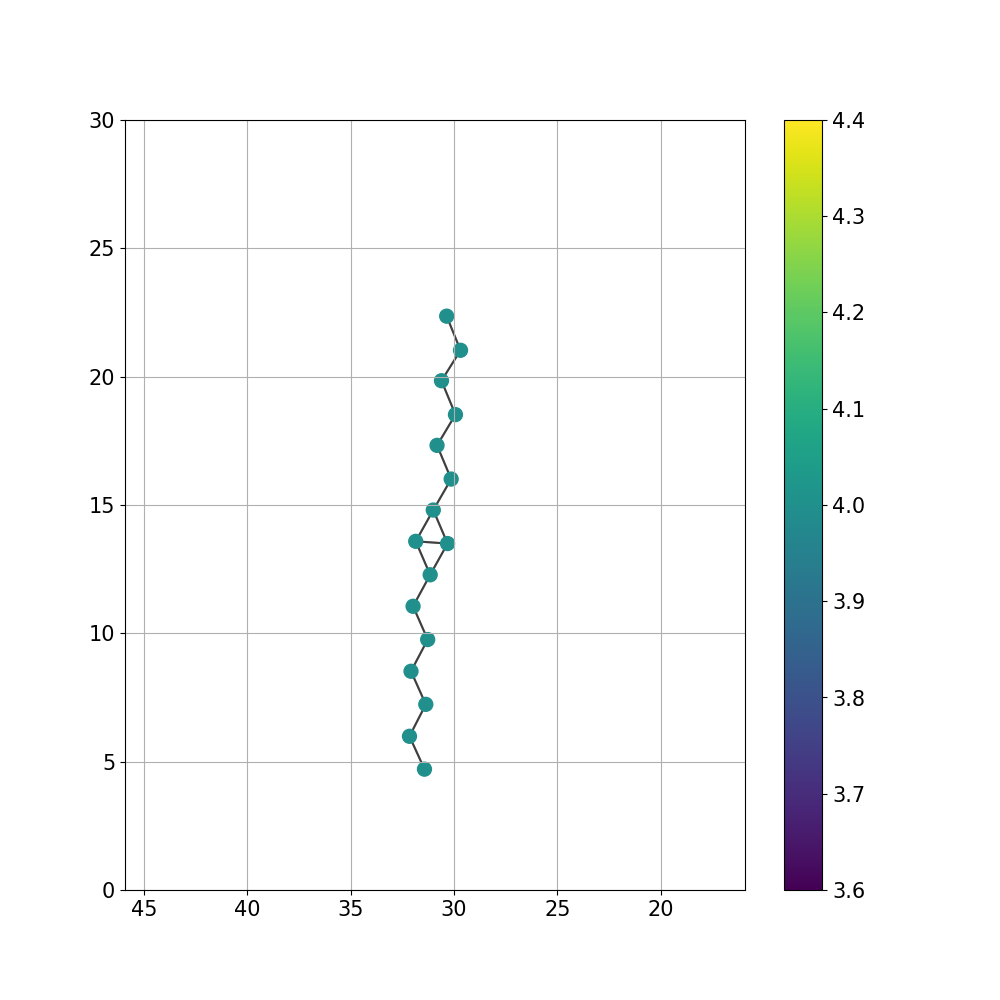

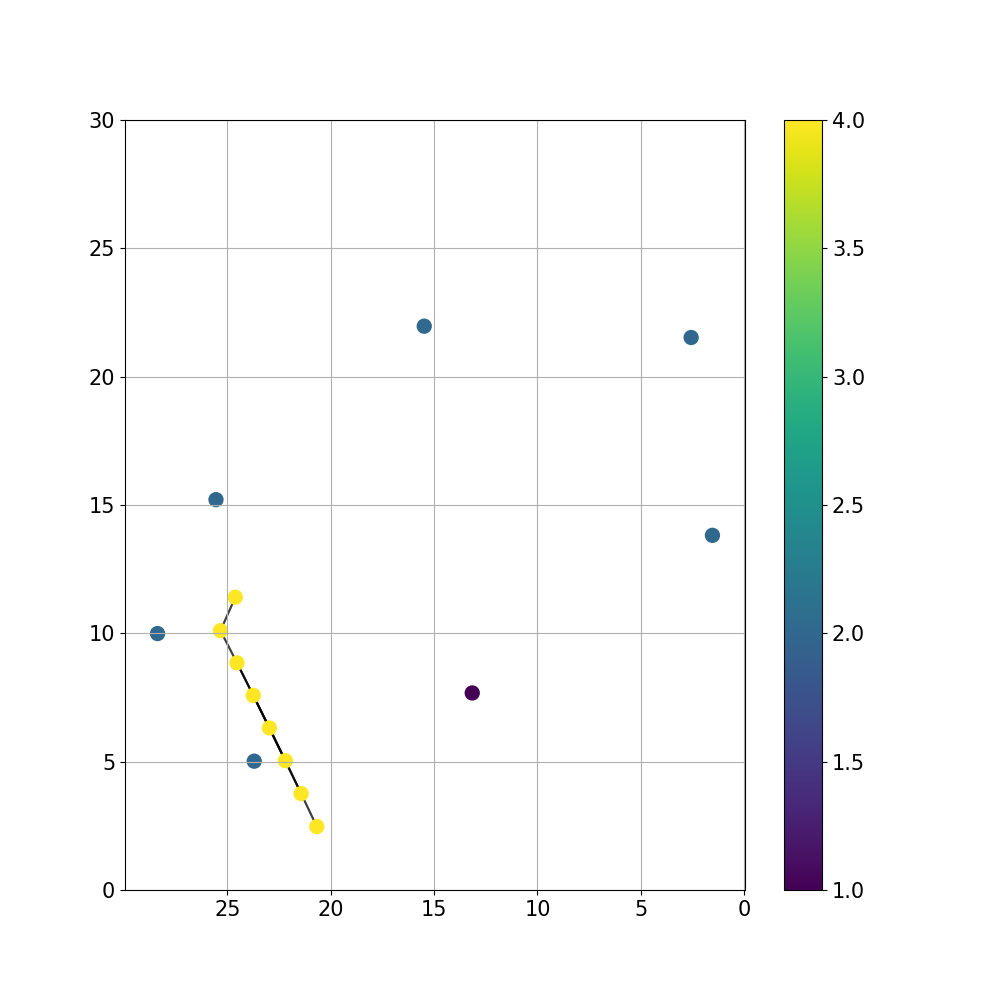

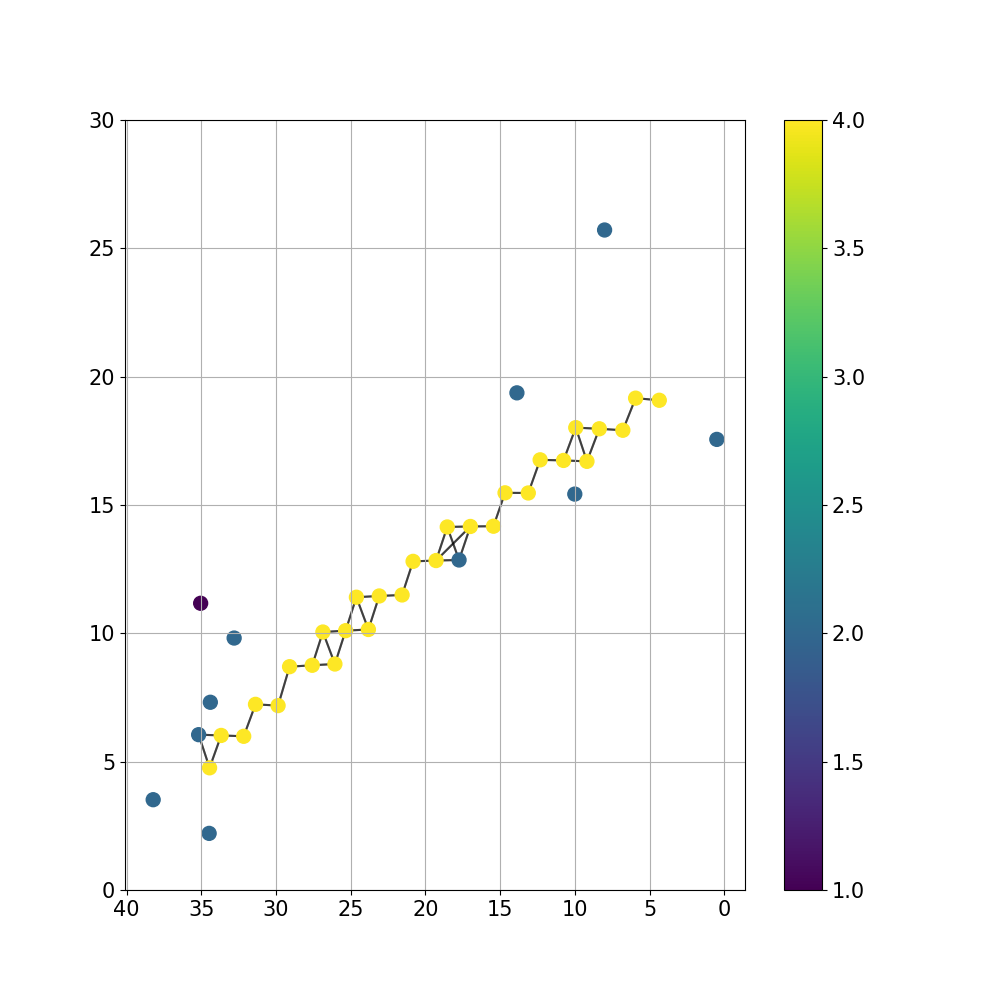

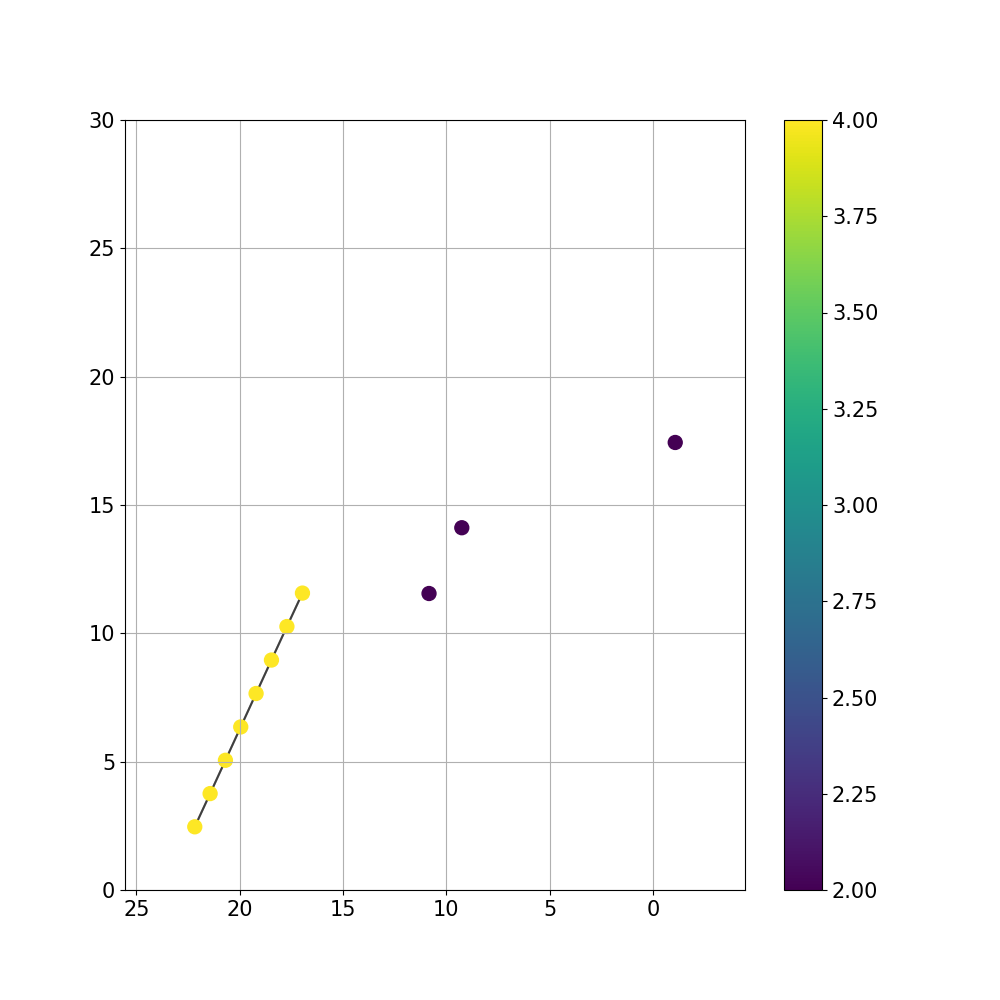

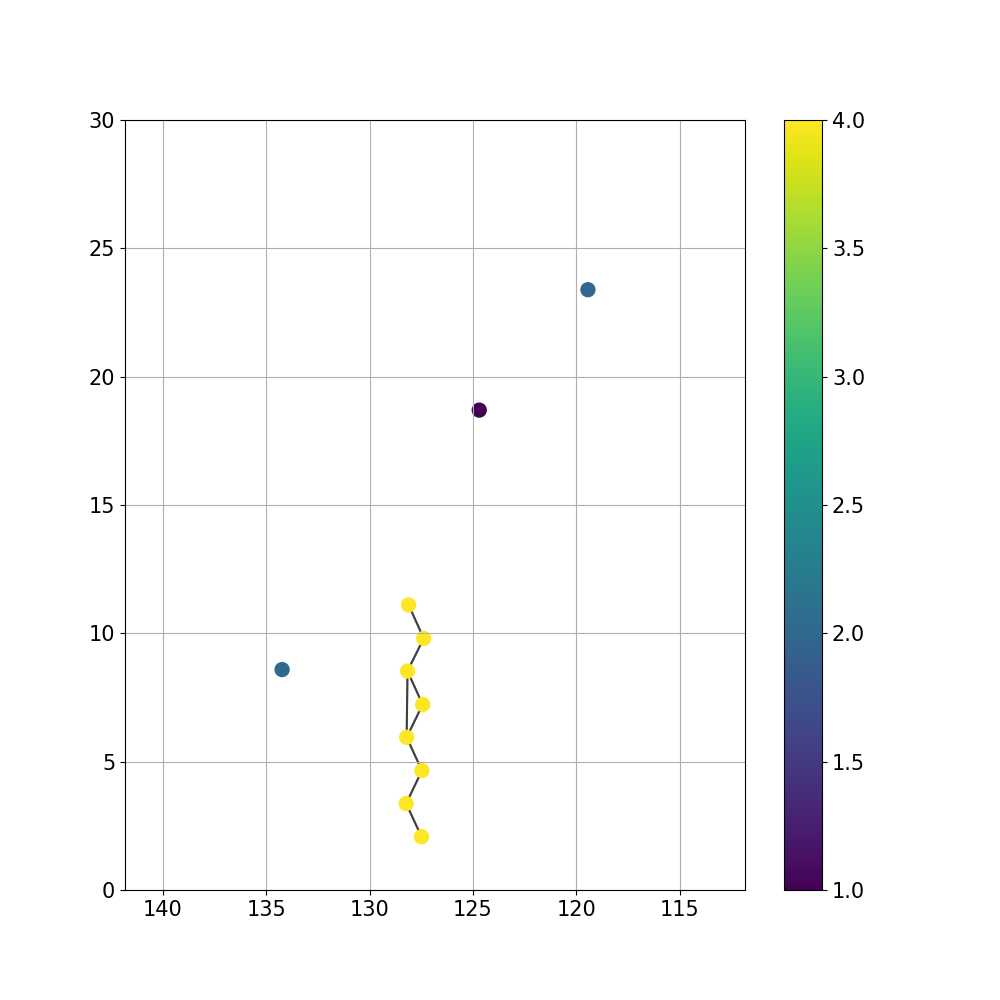

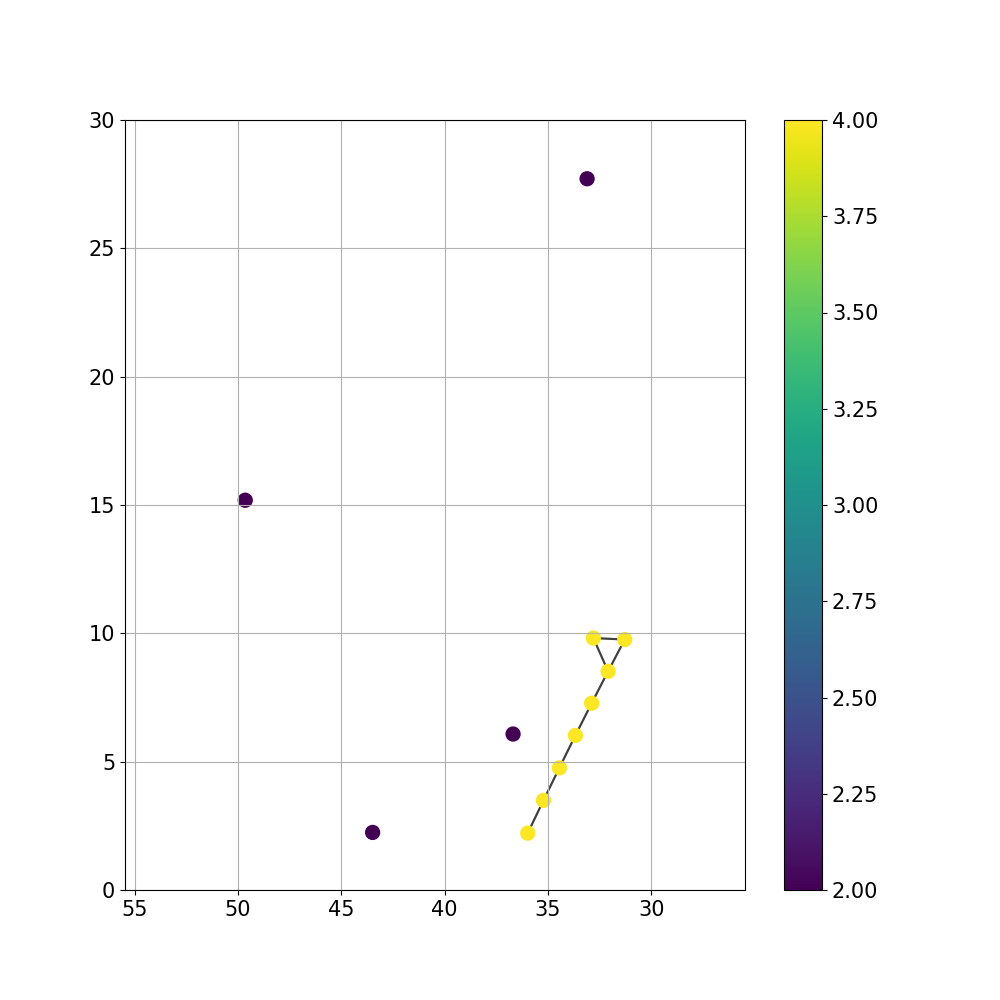

In [207]:
# [Pix_Theta,Pix_Phi,Pix_Centroid,Pix_Charge,Pix_PulseDuration]

for i,graph in enumerate(Graphs):
    Nodes = graph[0]
    Edges = graph[1]
    Edge_values = graph[2]

    # print(Edges)
    plt.figure(figsize=[10,10])
    plt.scatter(Nodes[:,1],90-Nodes[:,0],c=Nodes[:,5],s=100)
    plt.colorbar()
    for edge in Edges:
        edge_X = [Nodes[edge[0],1],Nodes[edge[1],1]]
        edge_Y = [90-Nodes[edge[0],0],90-Nodes[edge[1],0]]
        plt.plot(edge_X,edge_Y,'k',alpha=0.5,zorder = -1)

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)
    plt.ylim([0,30])
    plt.gca().invert_xaxis()
    plt.grid()

    # plt.figure(figsize=[10,10])
    # for y,node in enumerate(Nodes):
    #     x = node[2]
    #     plt.errorbar(x,y,xerr=node[4],fmt='o')
    
    # plt.figure(figsize=[10,10])
    

        

    if i == 10: break

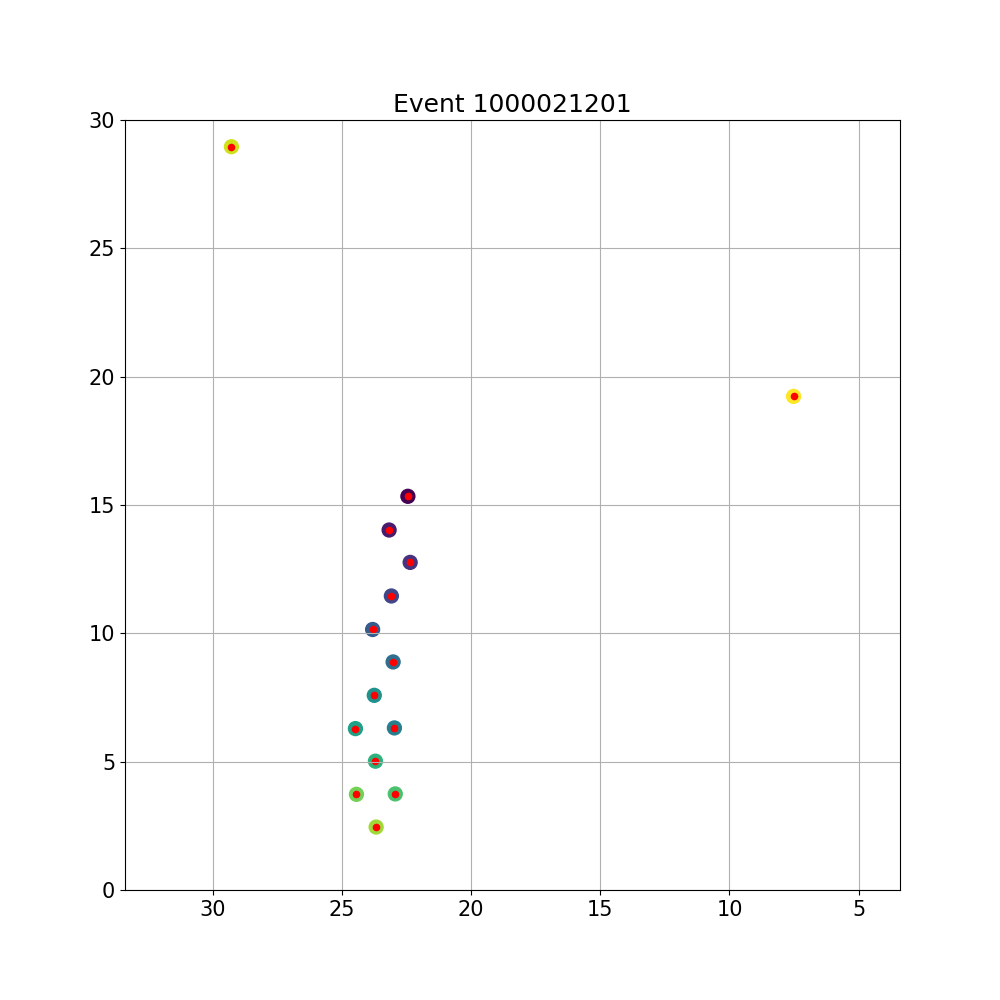

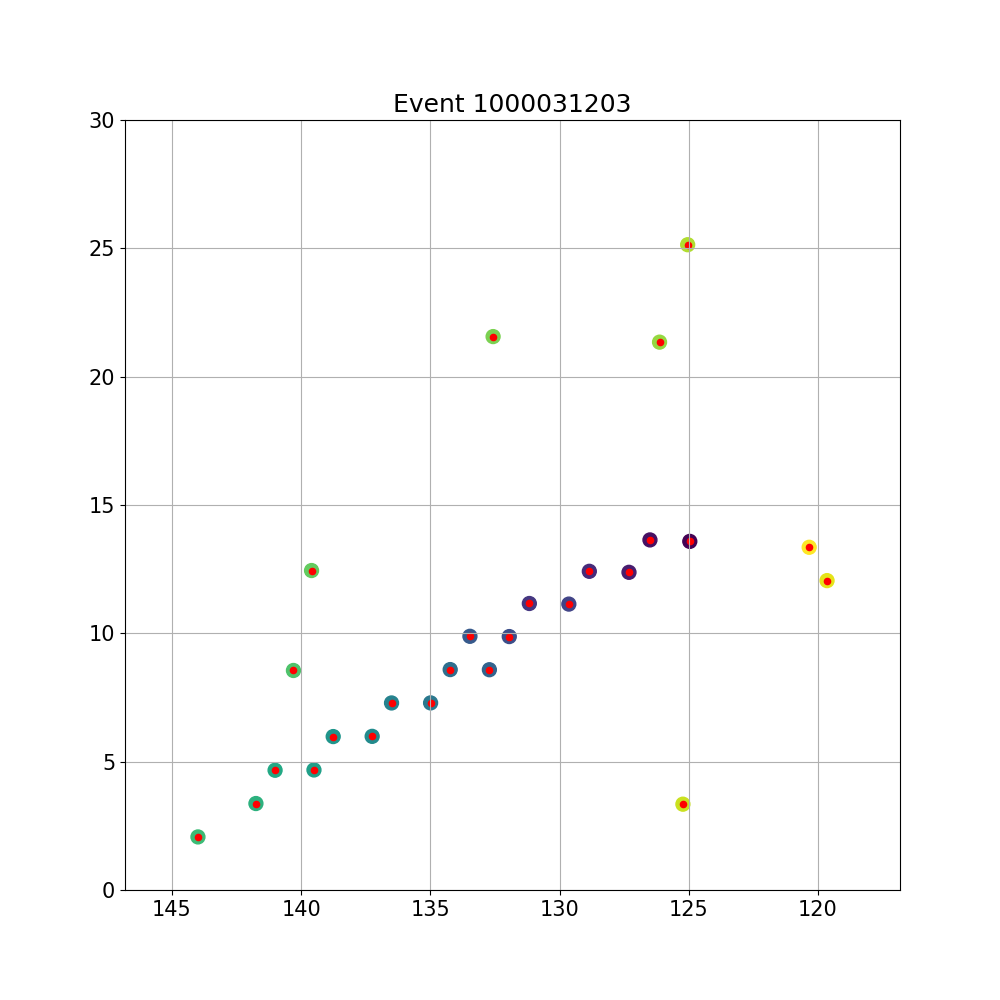

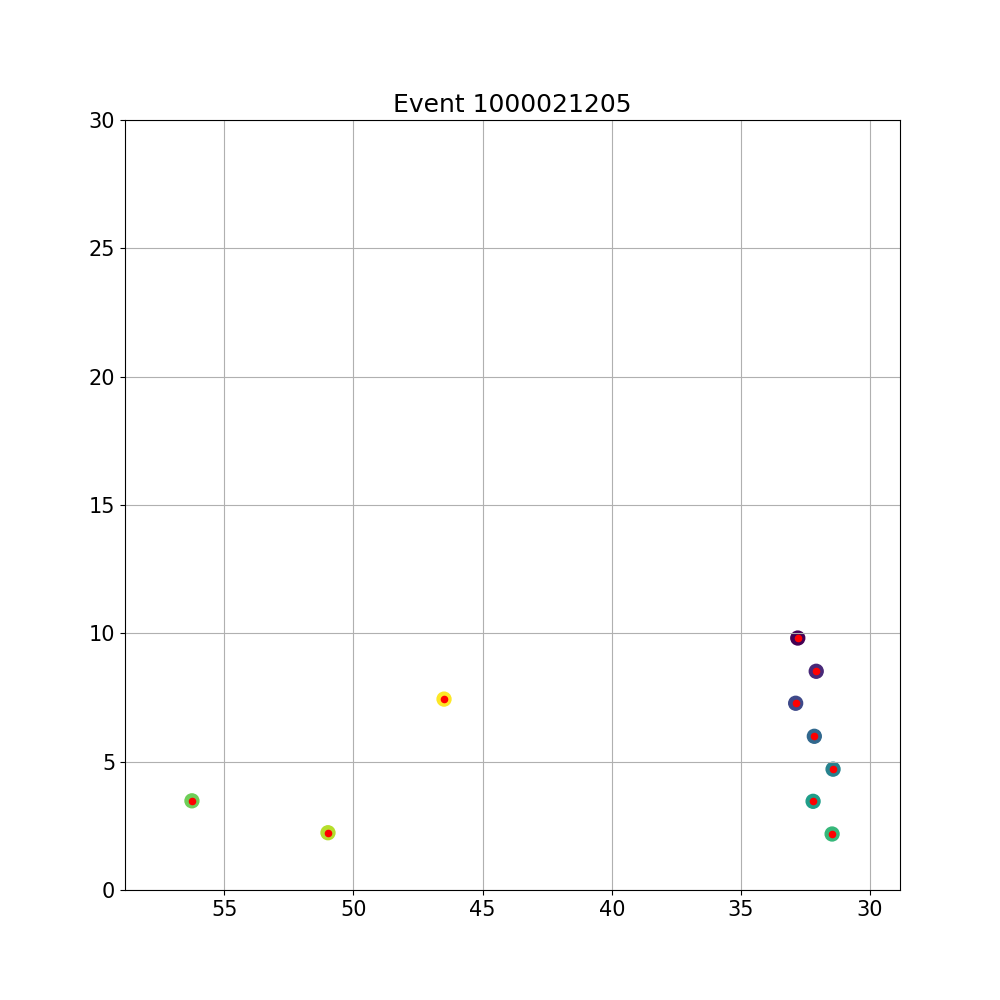

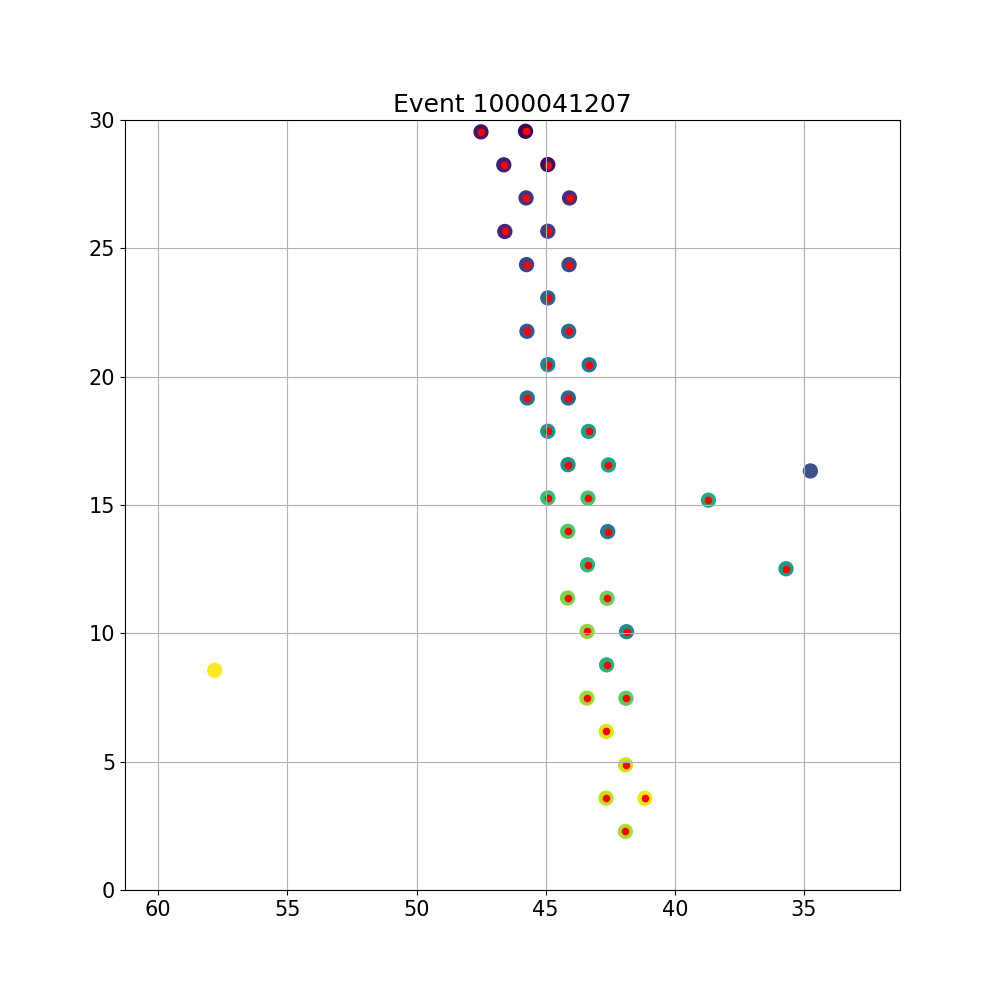

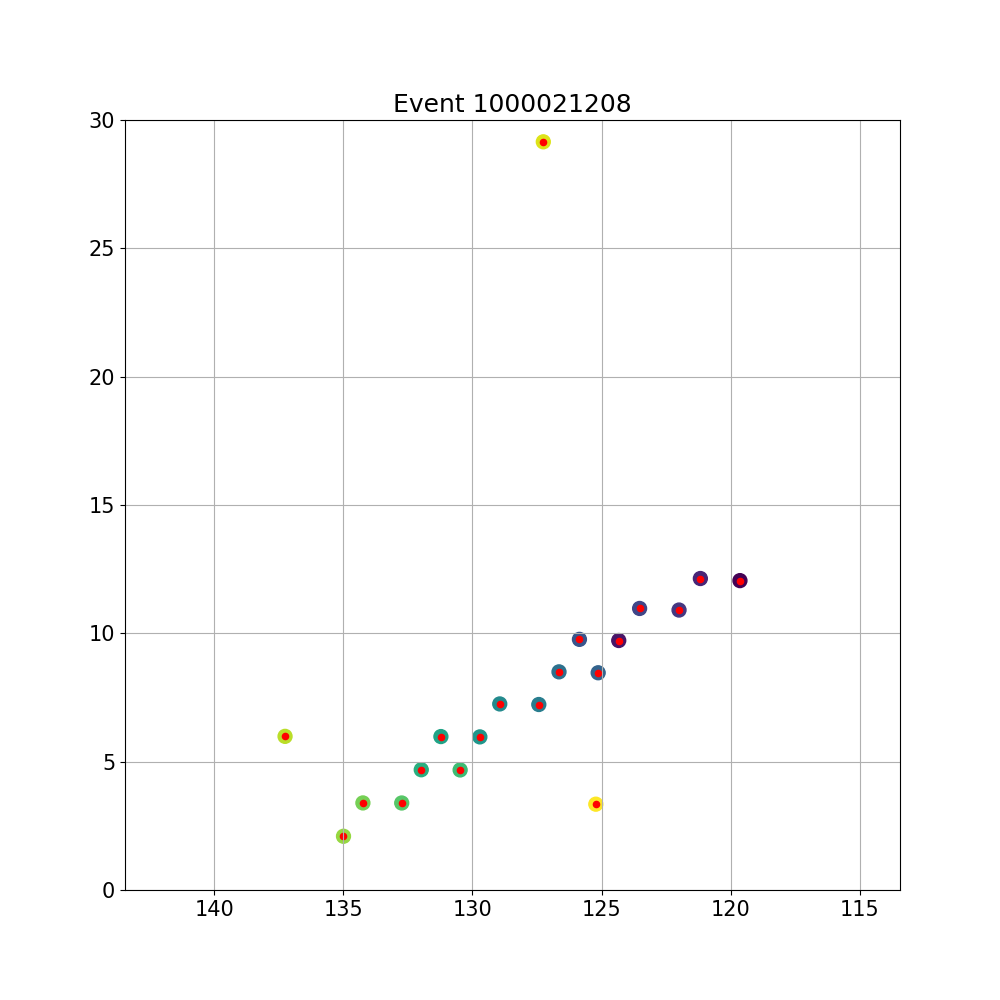

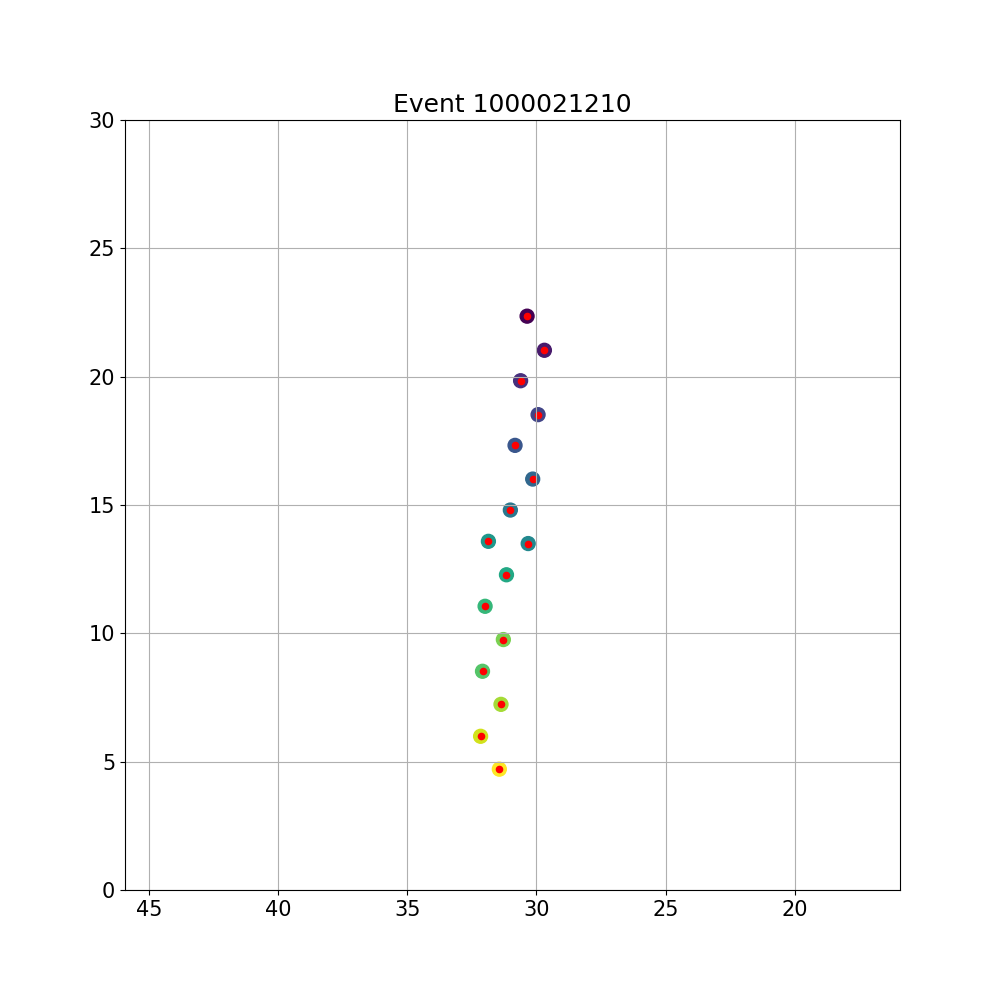

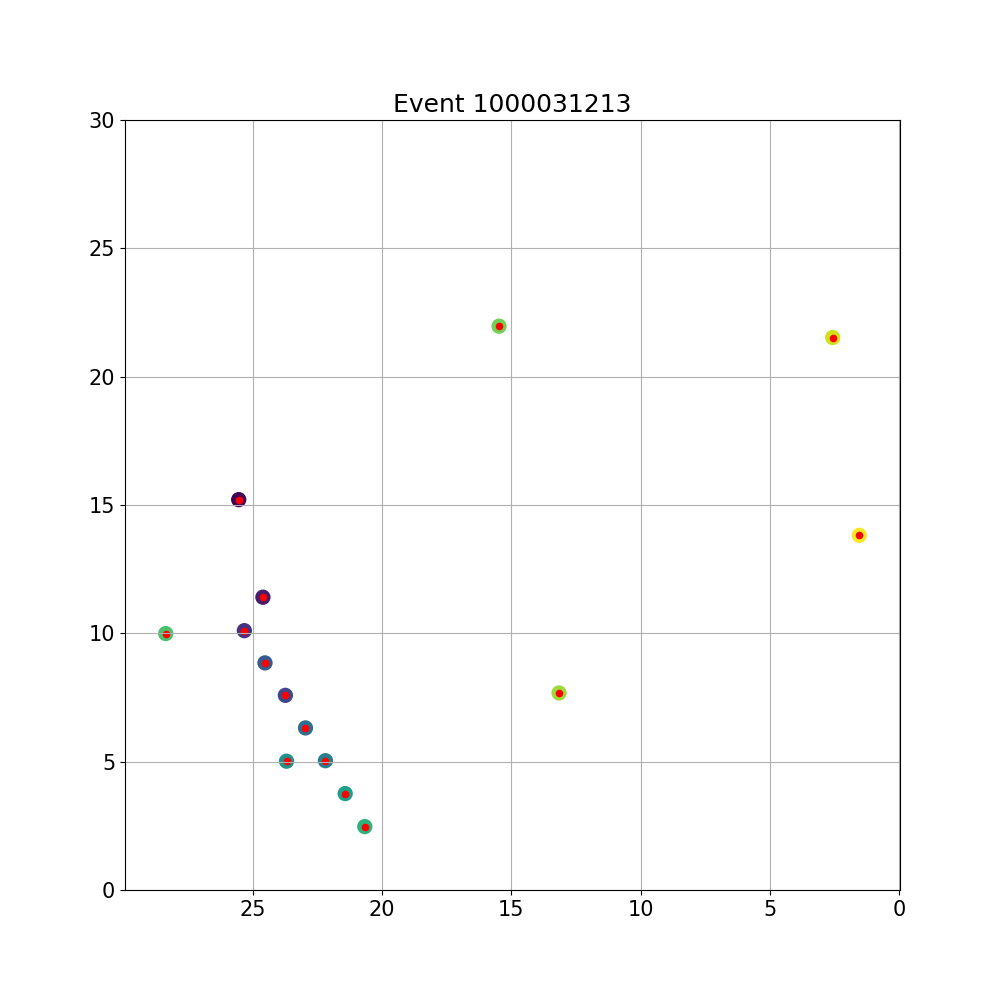

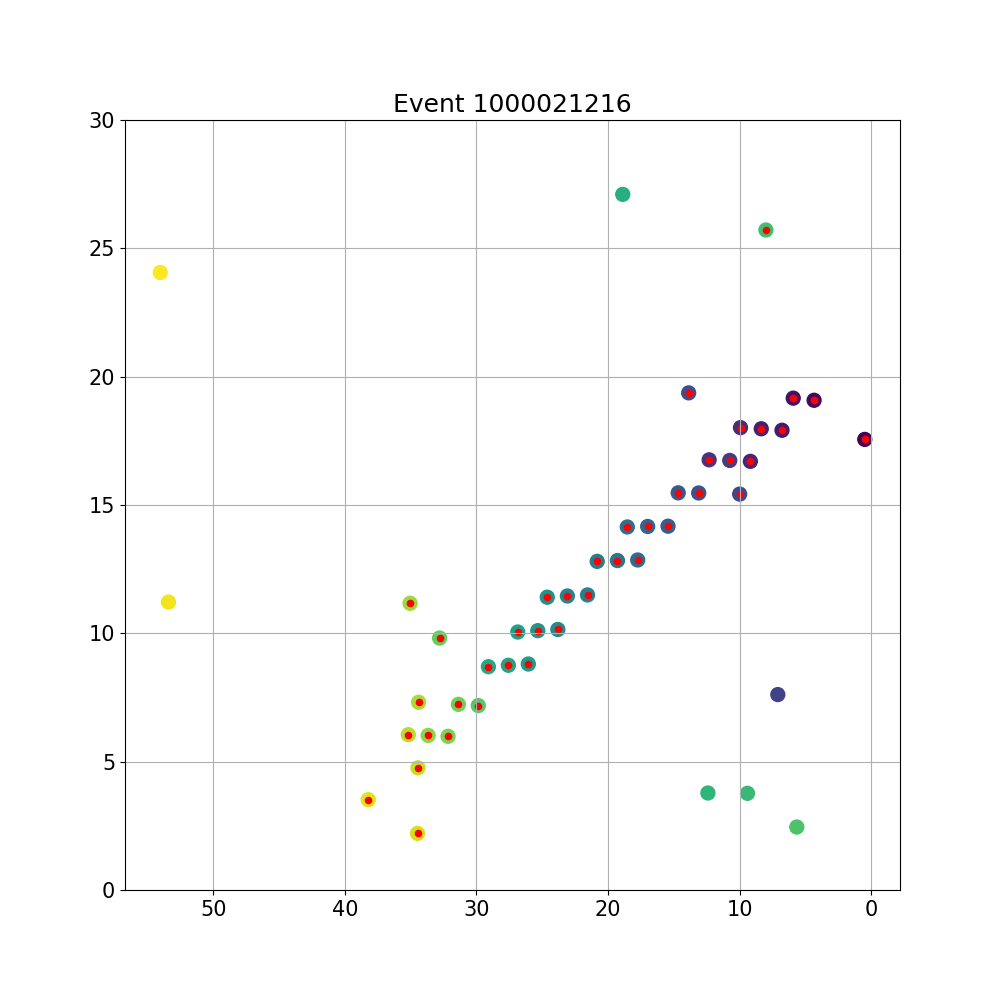

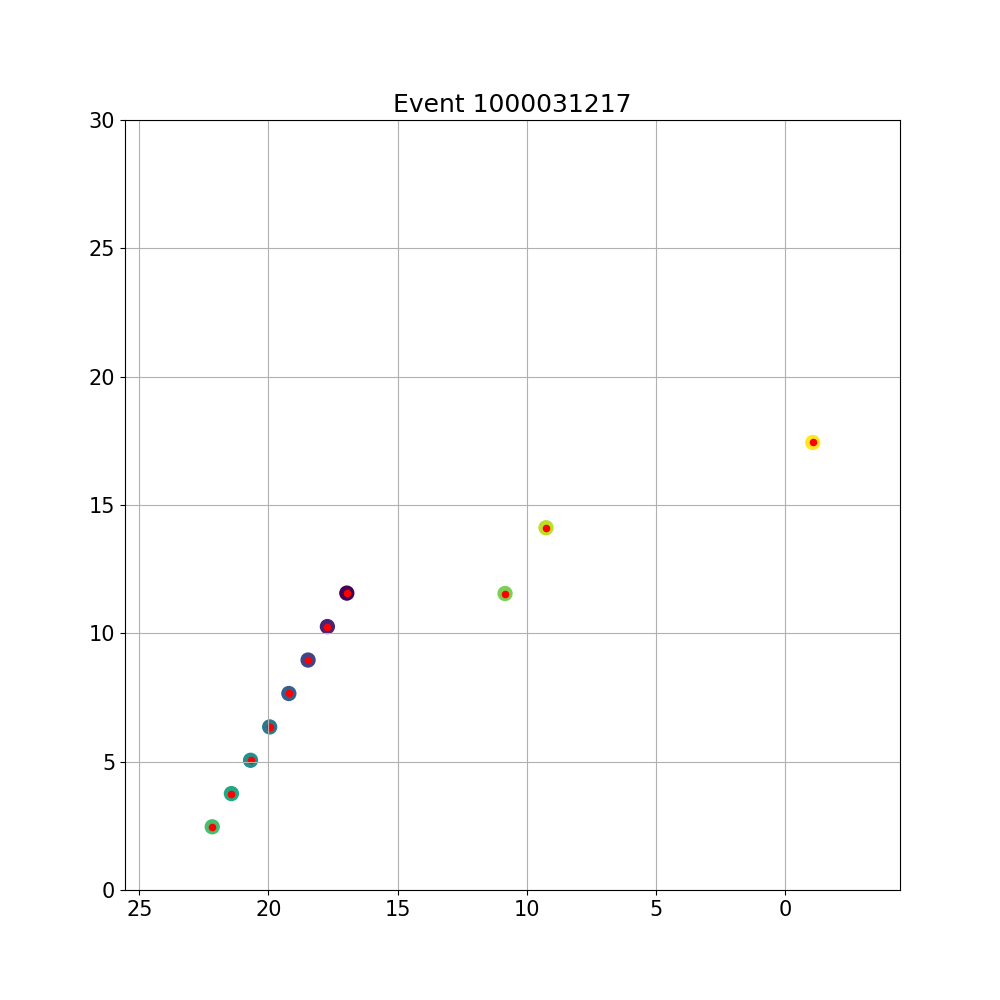

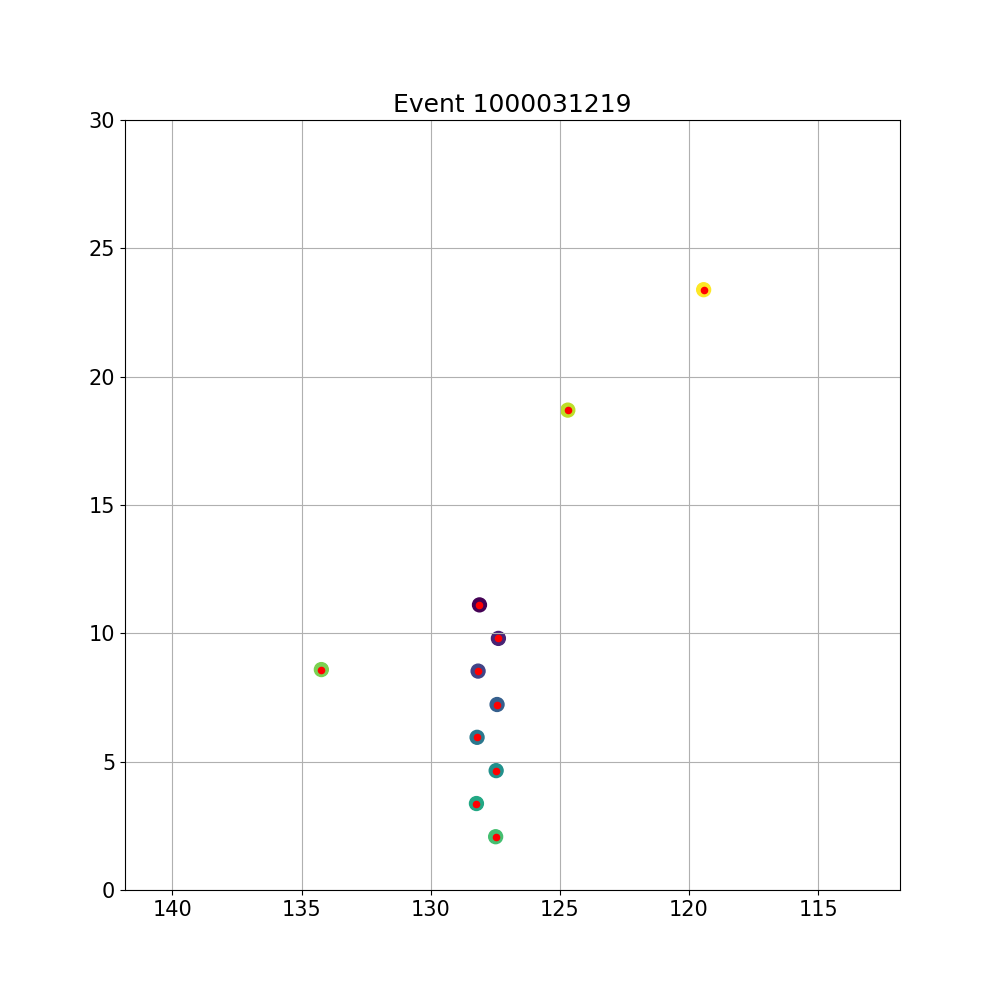

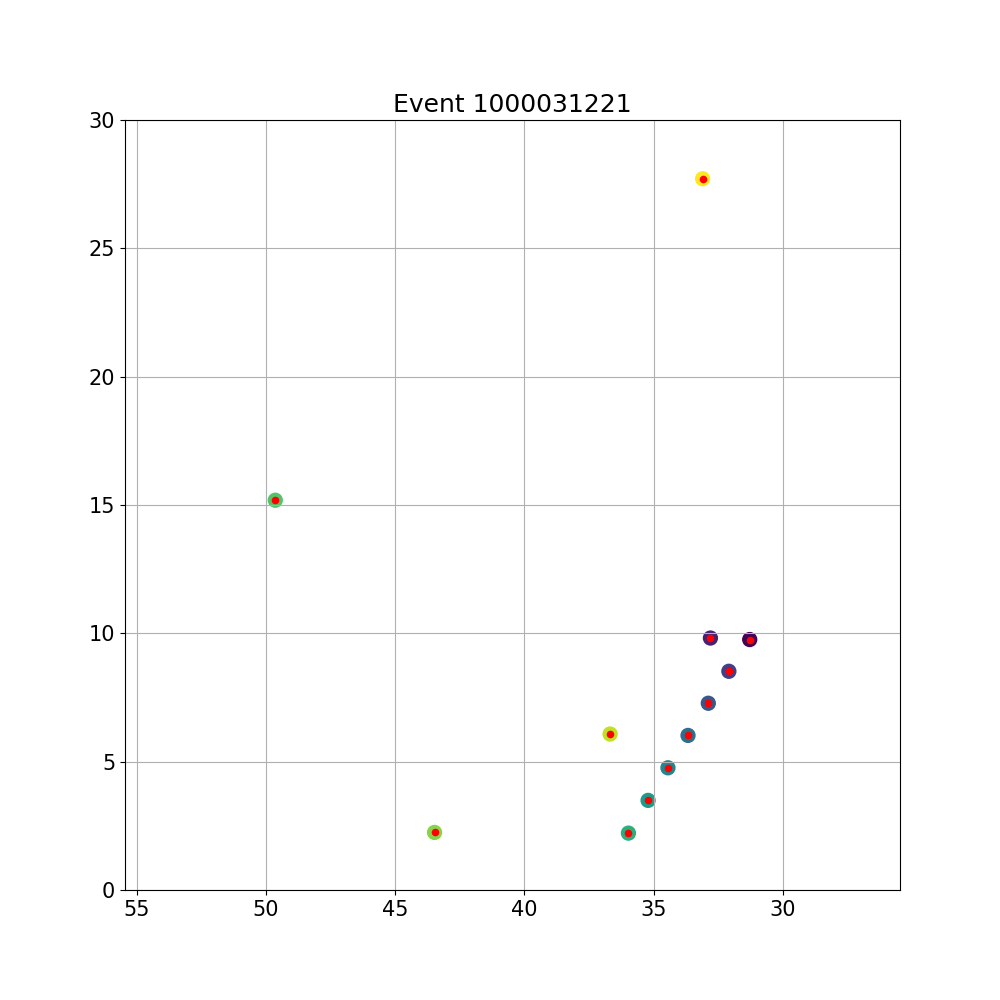

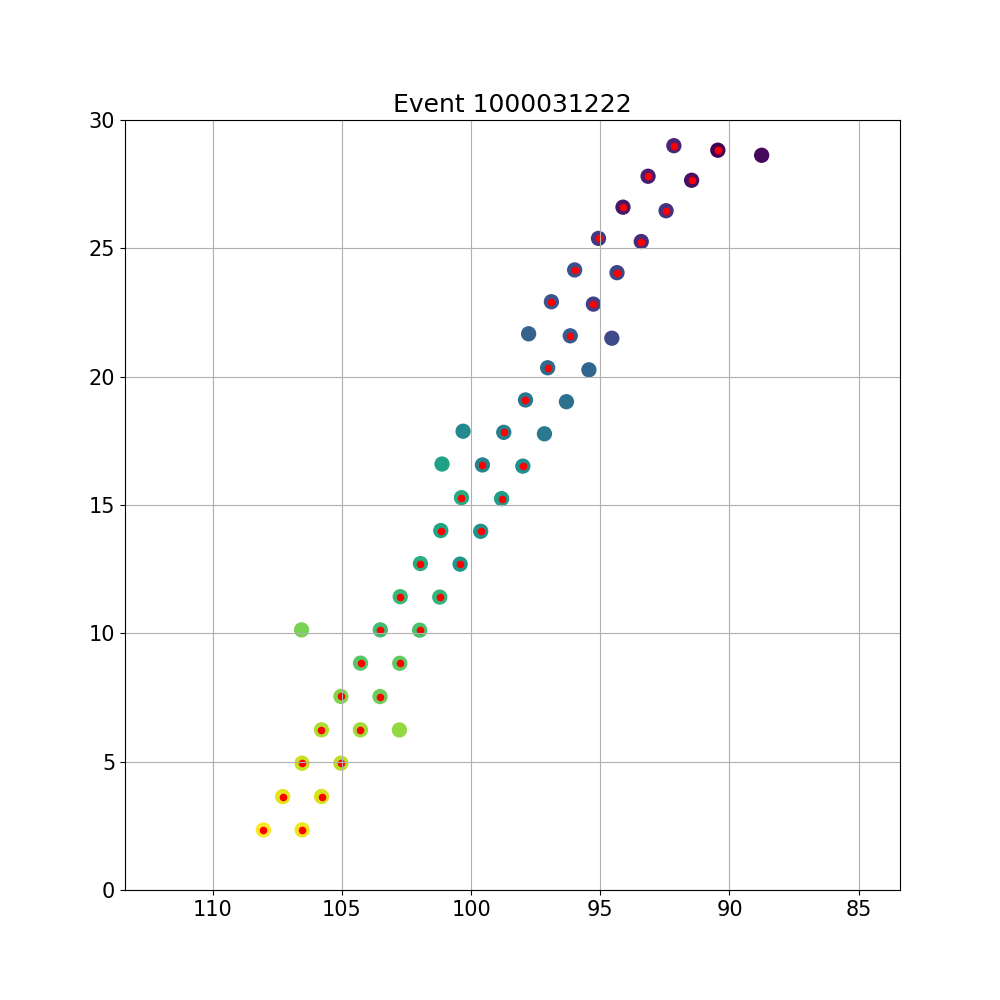

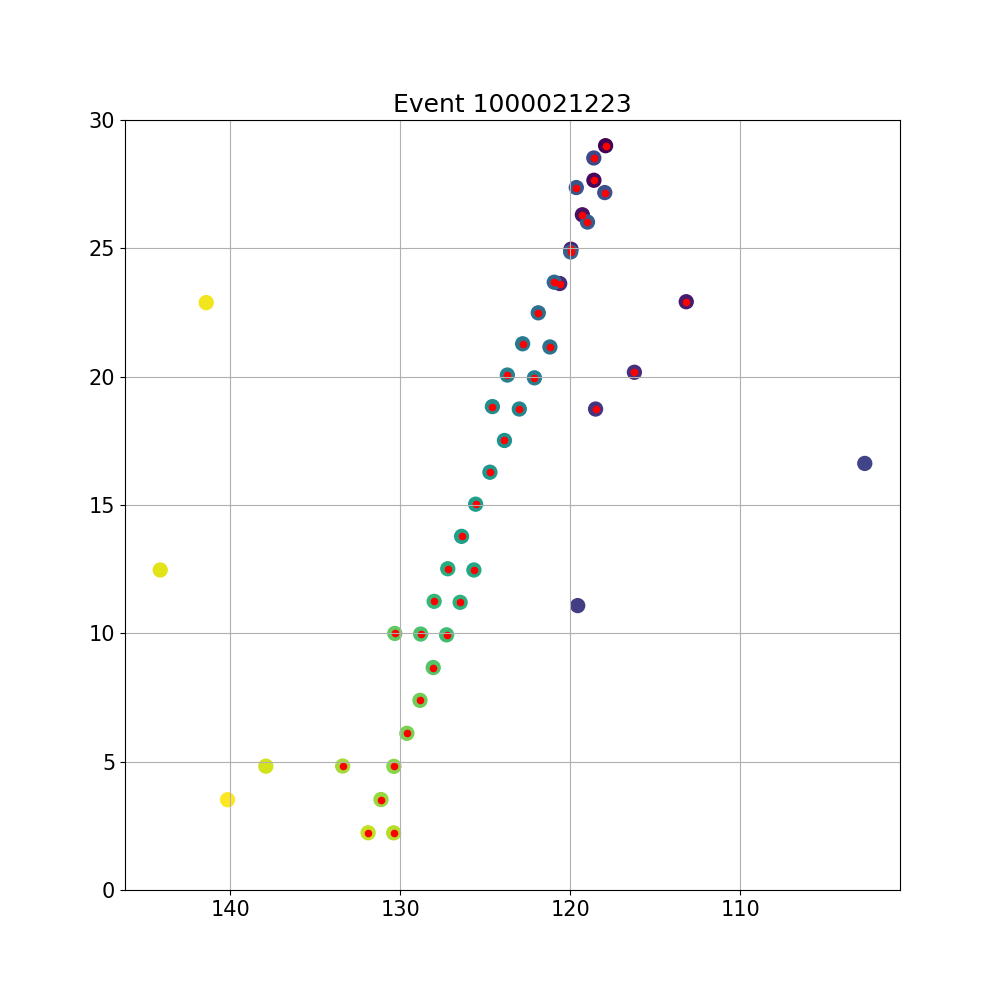

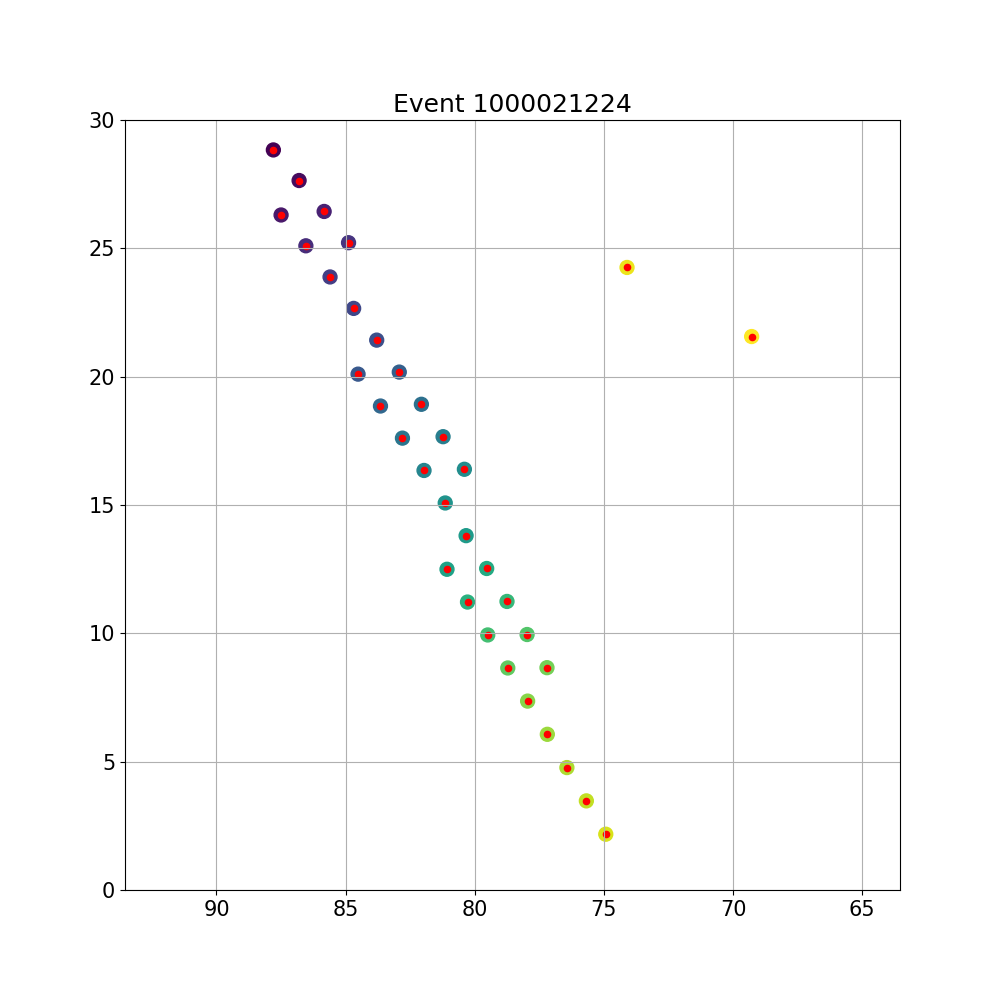

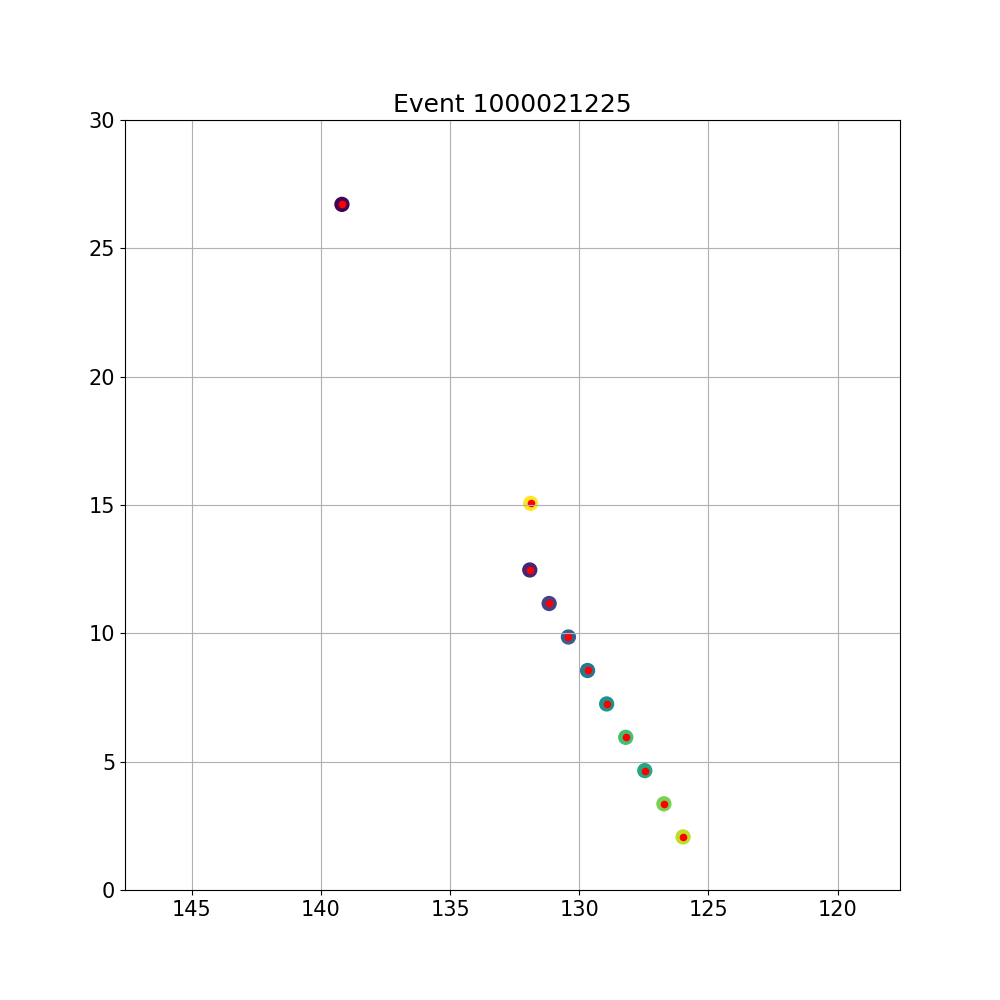

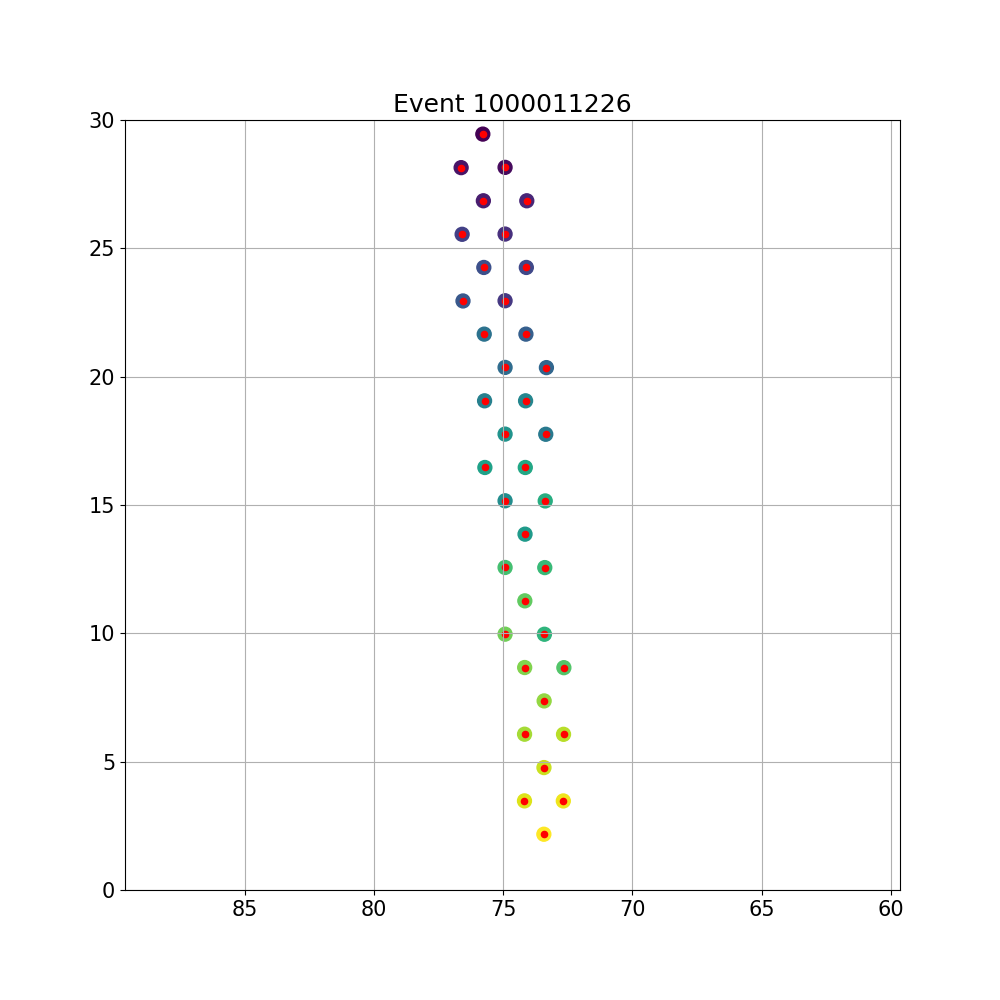

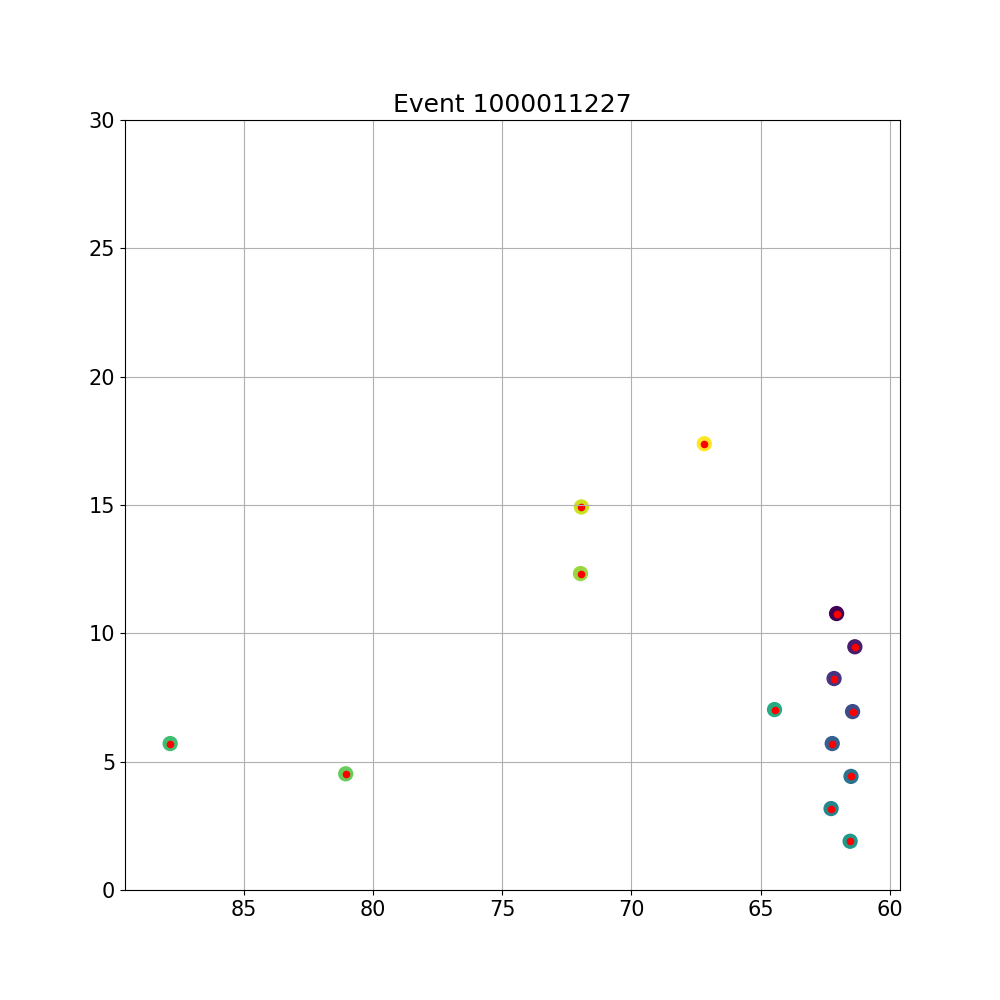

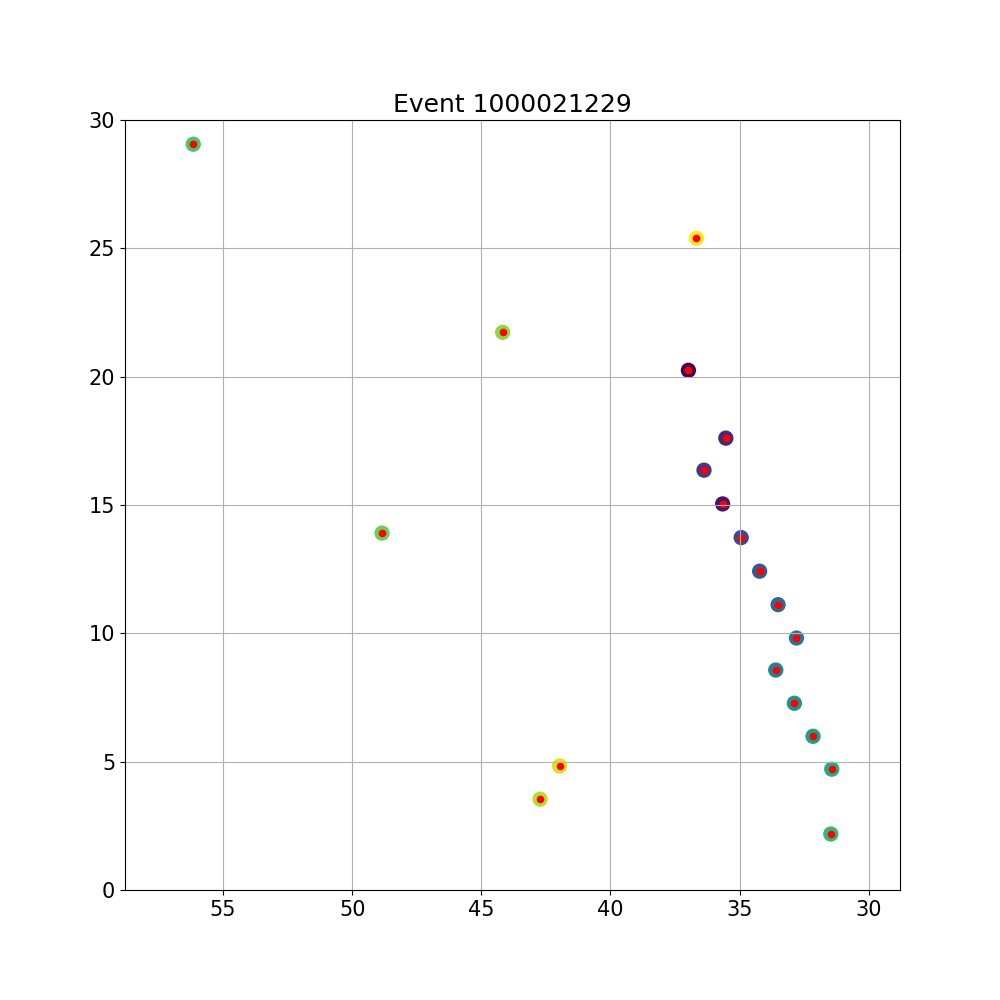

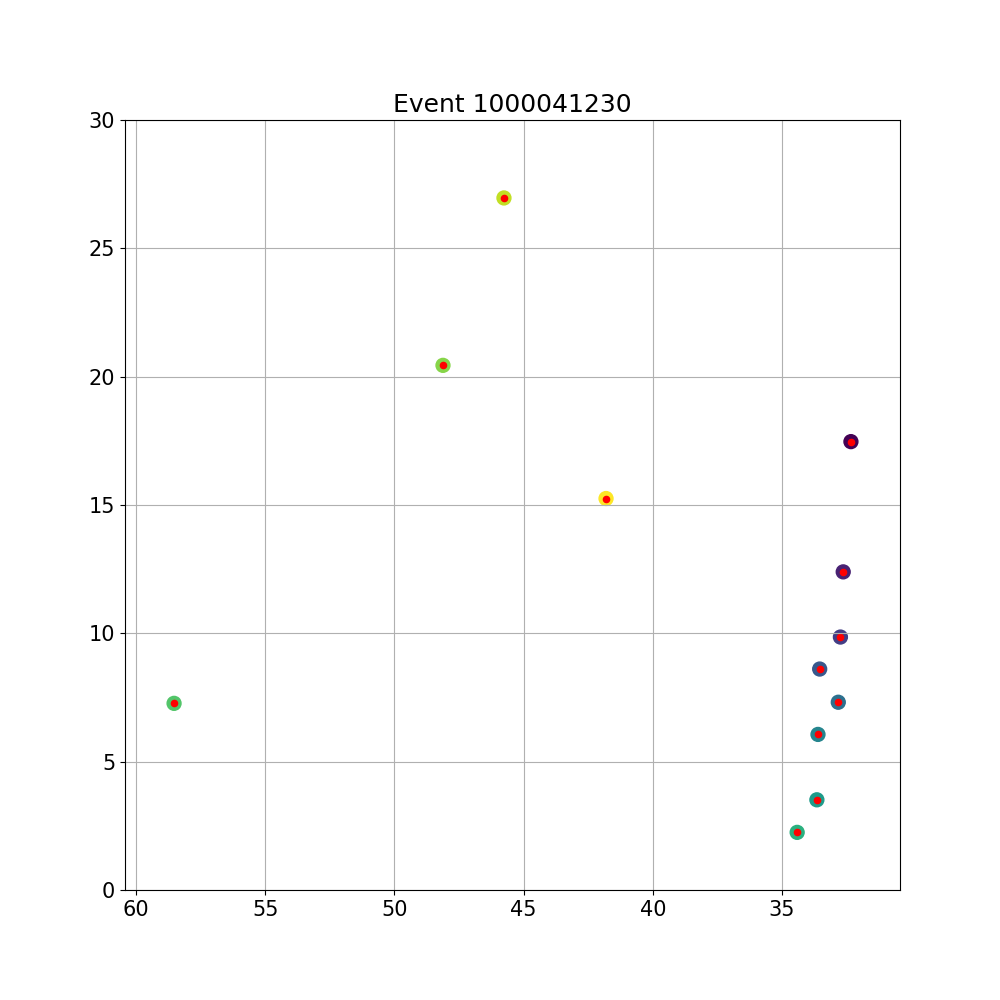

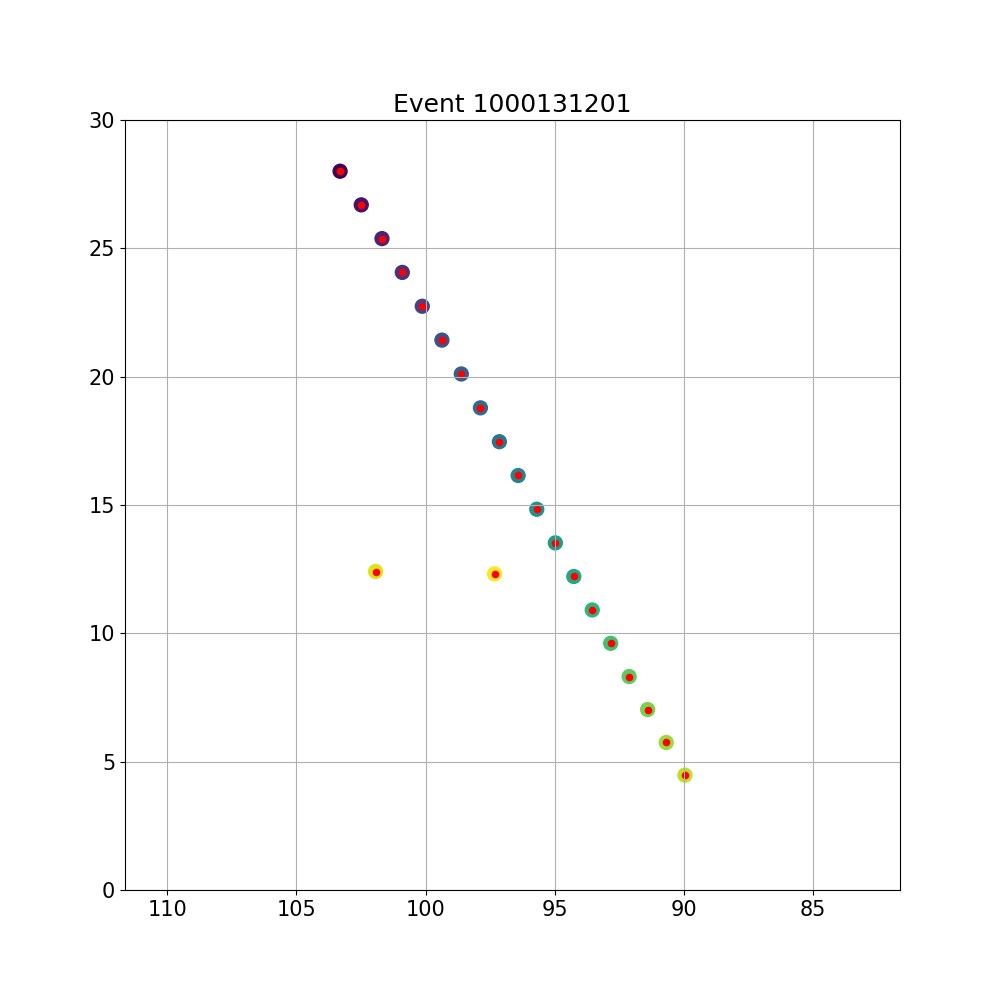

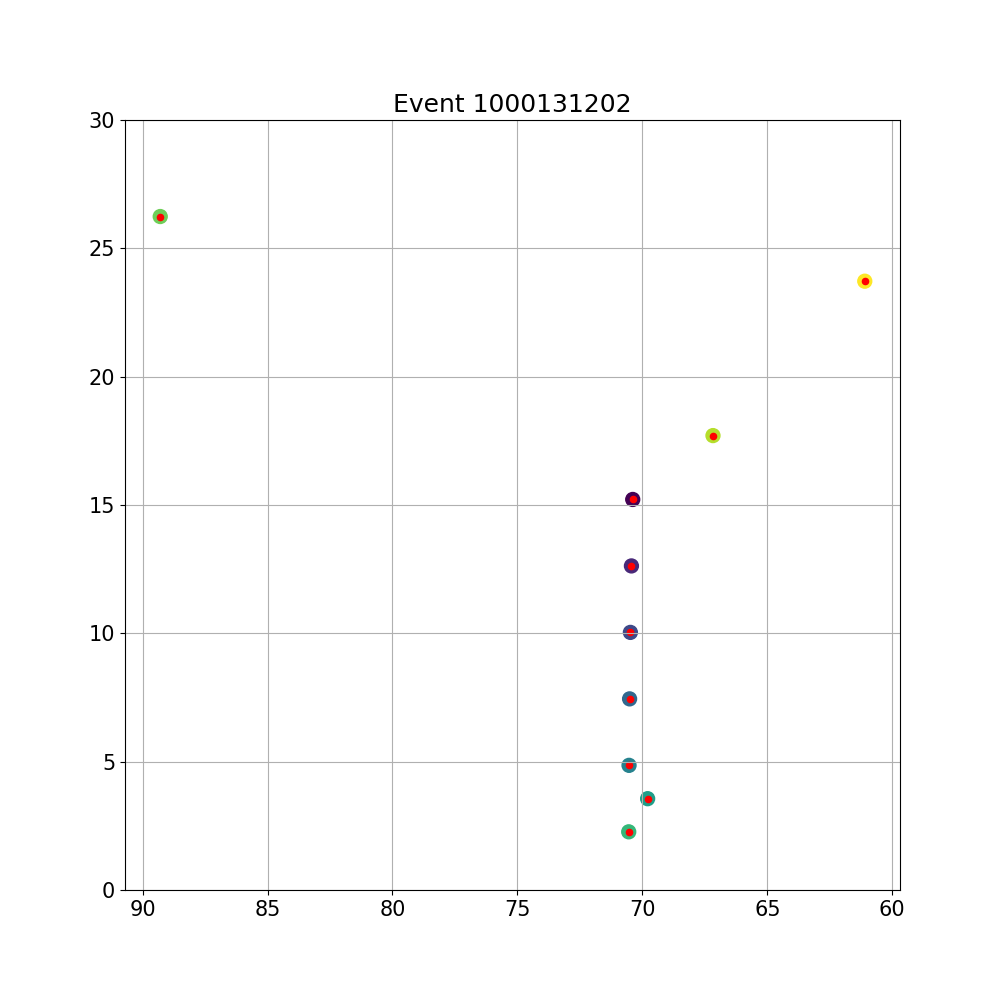

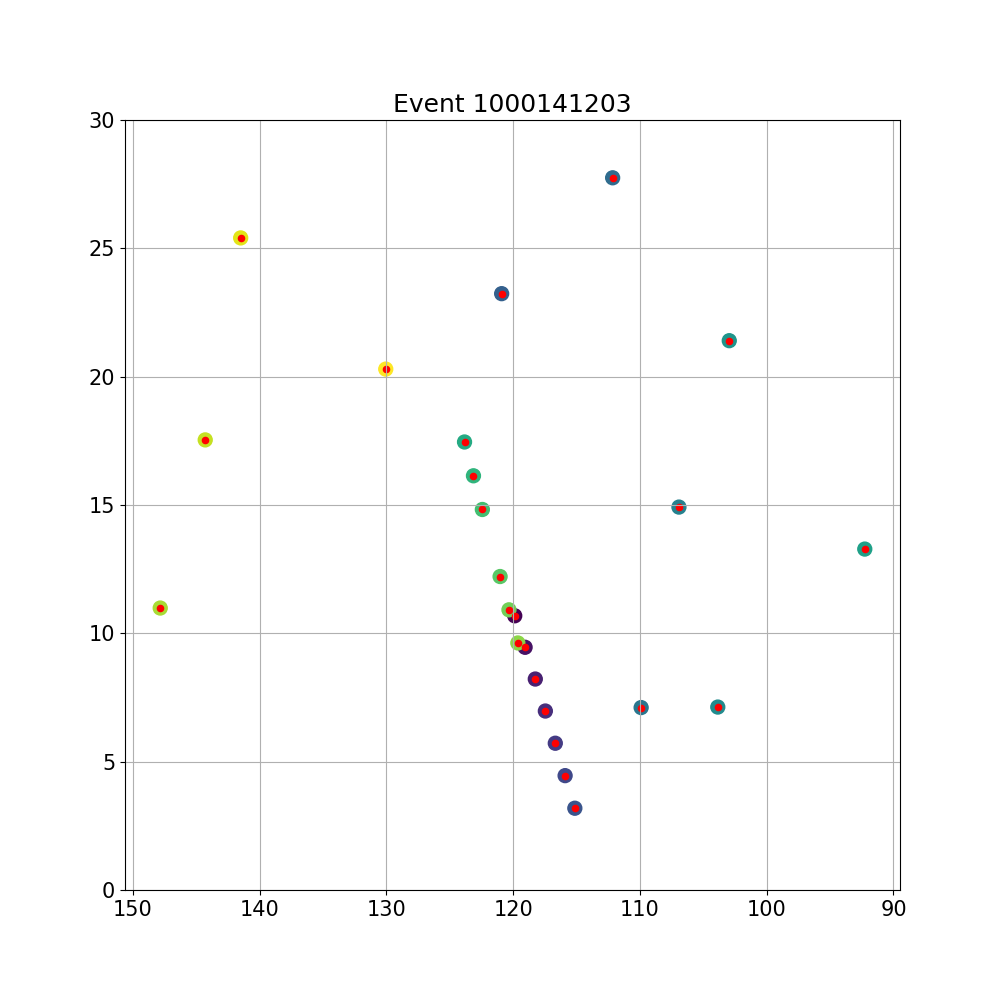

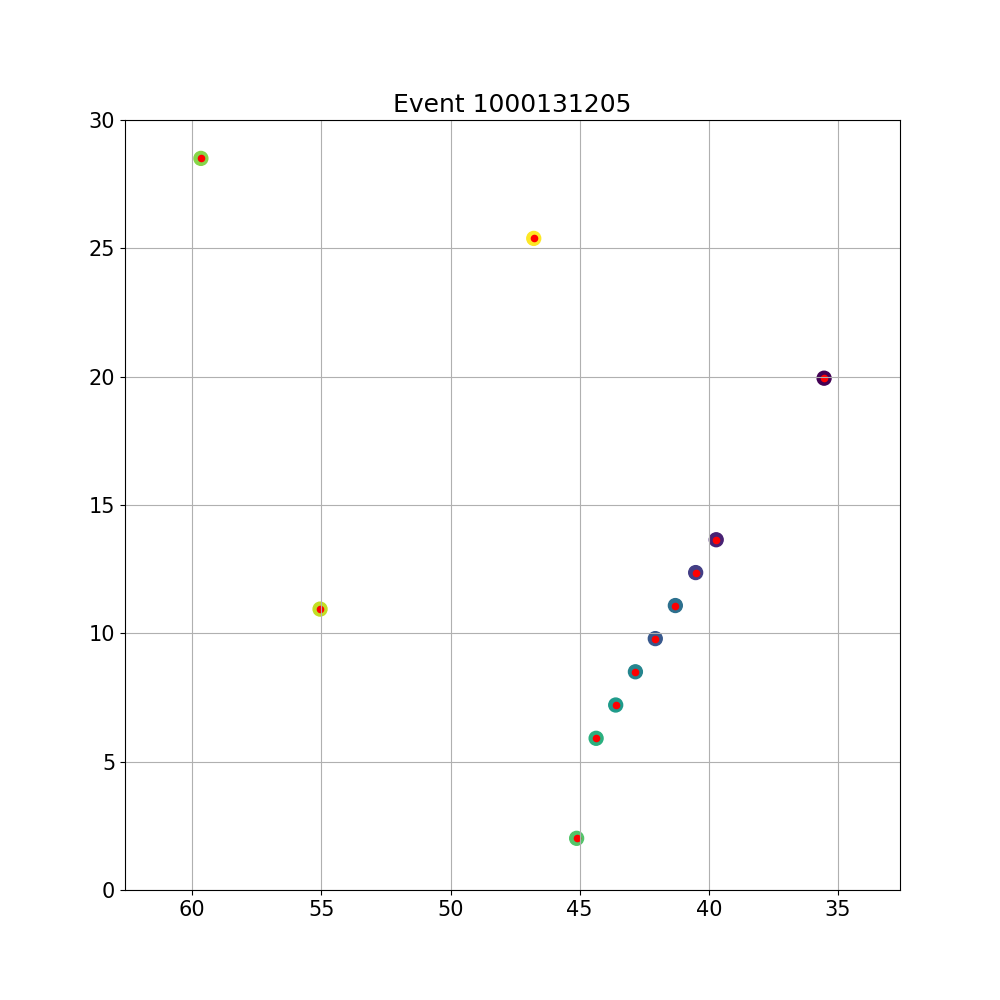

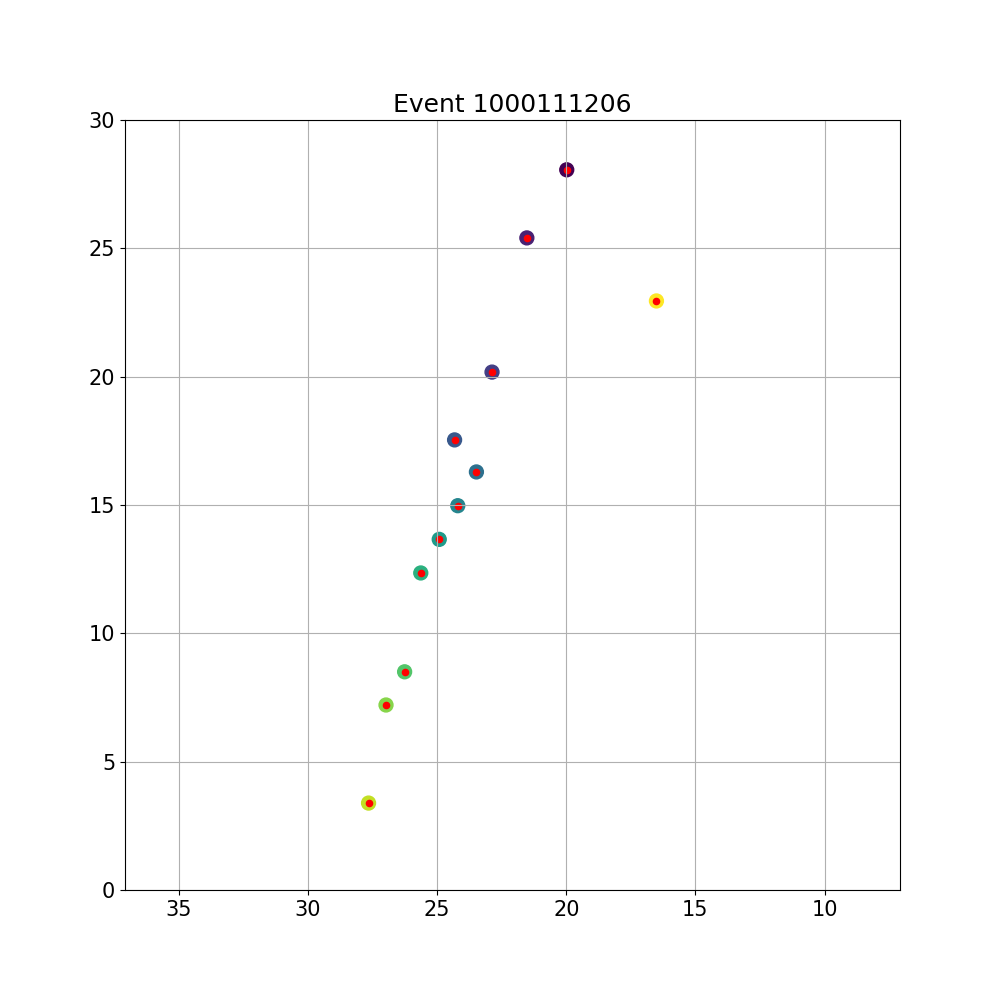

In [204]:
# Closest 40 pixels plots
Evs = 0
for i,event in enumerate(Dataset):
    status = event.get_pixel_values('Status')
    # if torch.sum(status==4)<=40: continue
    Pixel_Theta  = event.get_pixel_values('Theta')
    Pixel_Phi    = event.get_pixel_values('Phi')
    Pixel_Charge = event.get_pixel_values('Charge')
    SDP_Theta    = event.get_value('Gen_SDPTheta')
    SDP_Phi      = event.get_value('Gen_SDPPhi')
    
    cut = cut_pixels(Pixel_Theta/180*torch.pi,Pixel_Phi/180*torch.pi,SDP_Theta,SDP_Phi,pixel_count=40)
    

    Id = Run010.IDs[i]
    plt.figure(figsize=[10,10])
    plt.scatter(Pixel_Phi,90-Pixel_Theta,s=100,c=range(len(Pixel_Theta)))
    plt.scatter(Pixel_Phi[cut],90-Pixel_Theta[cut],c='r',s=20)
    plt.title(f'Event {Id}')

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)
    plt.ylim([0,30])
    plt.gca().invert_xaxis()
    plt.grid()

    
    Evs+=1

    if Evs>25: break
    # break

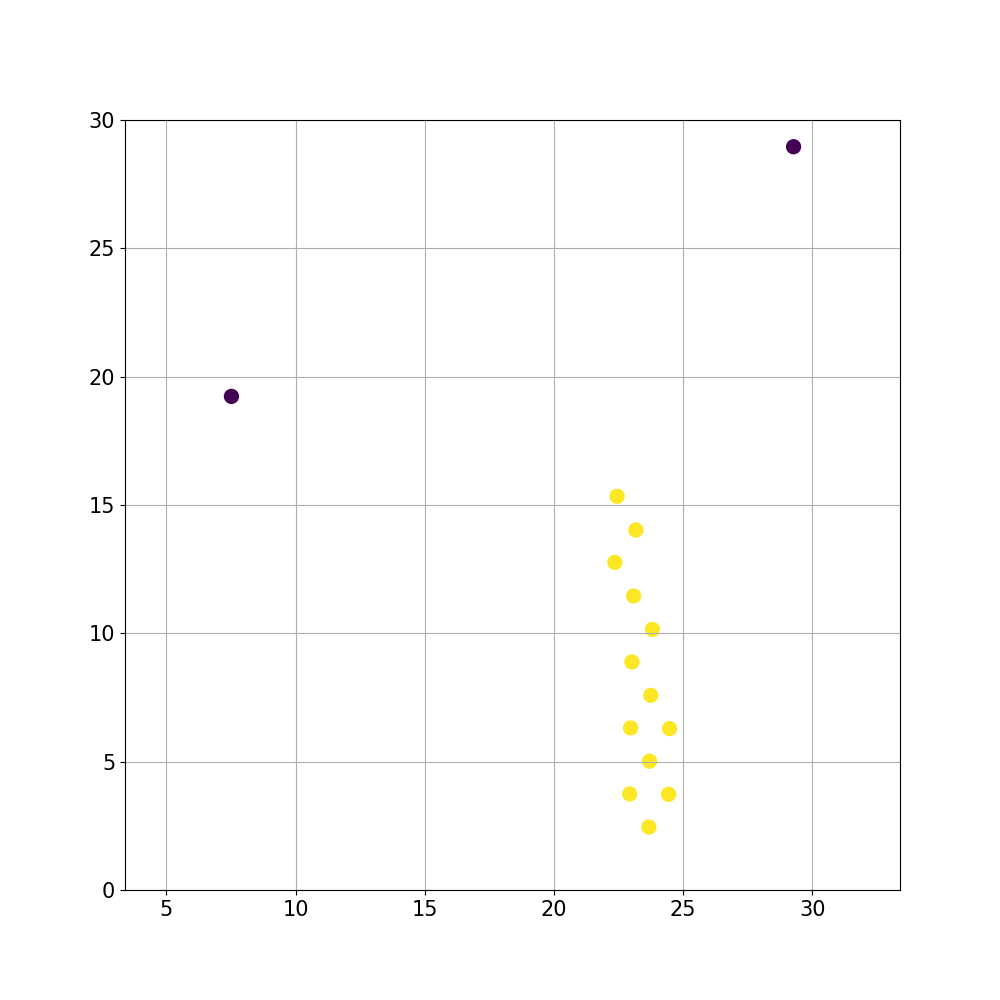

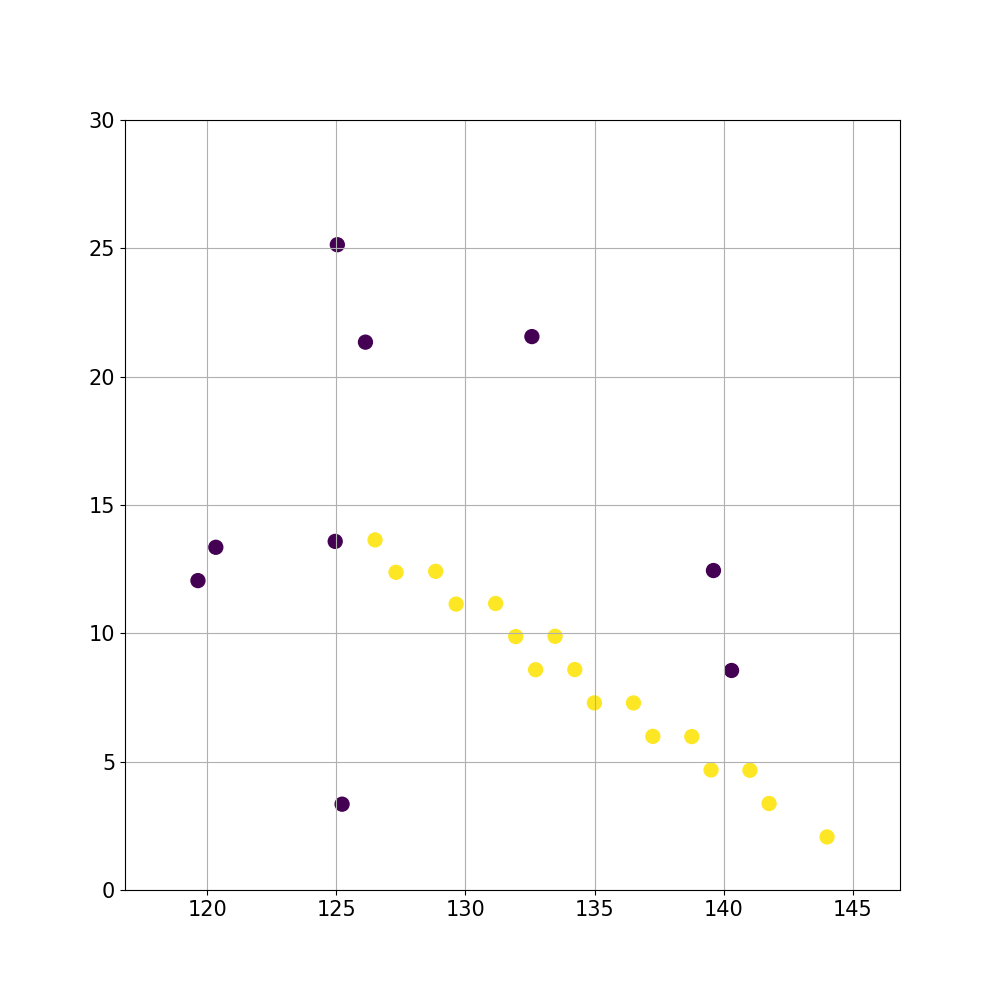

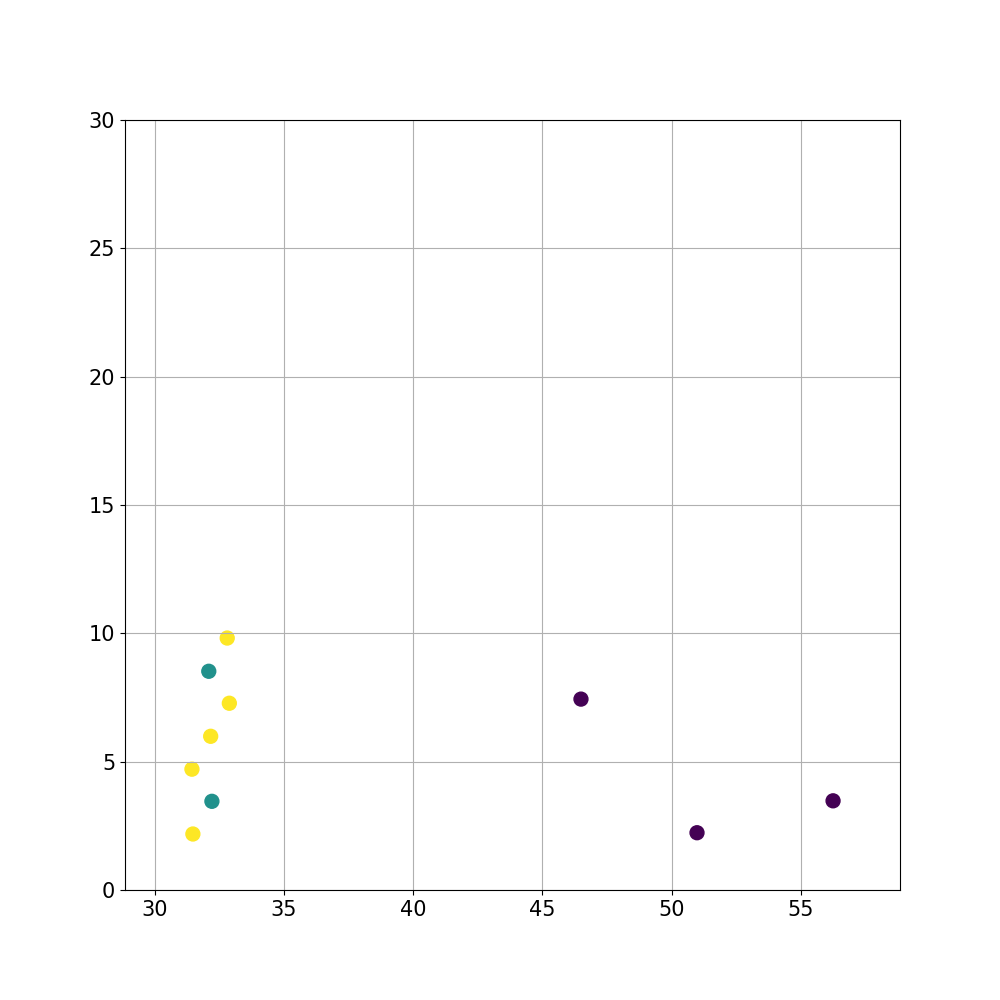

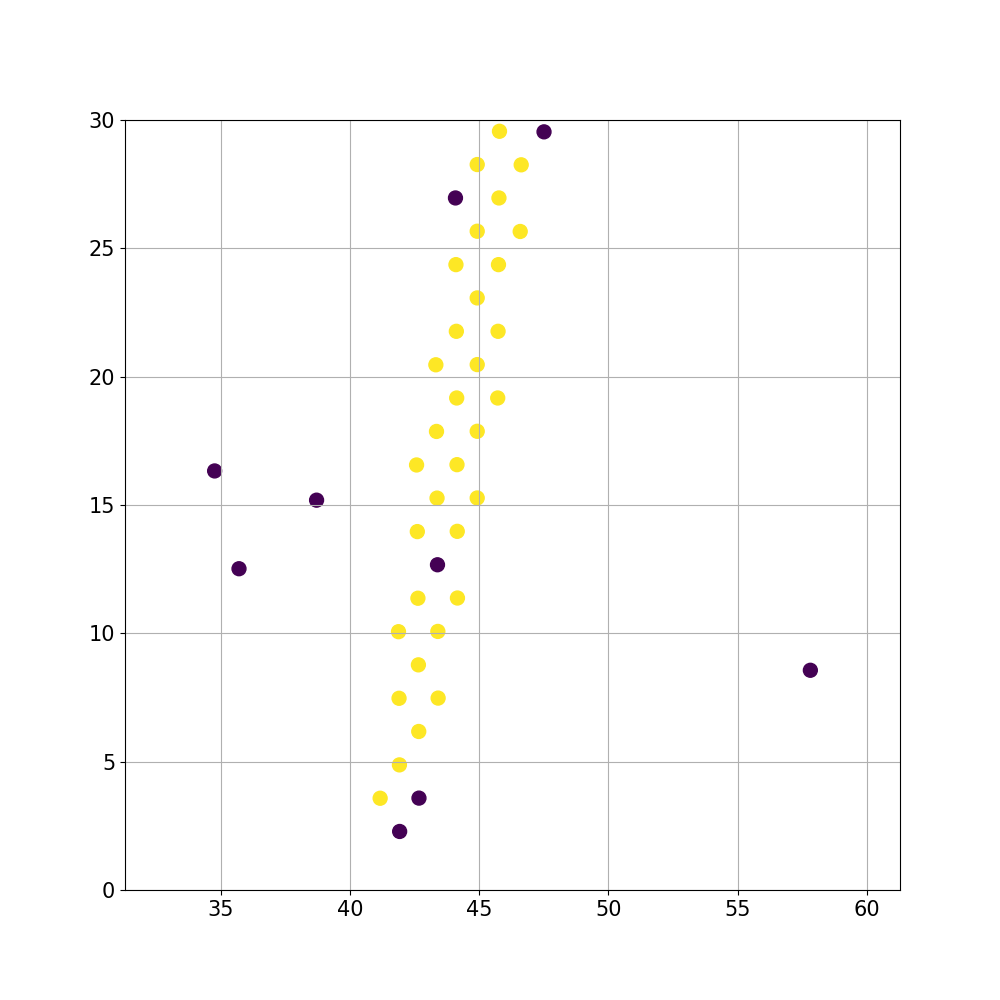

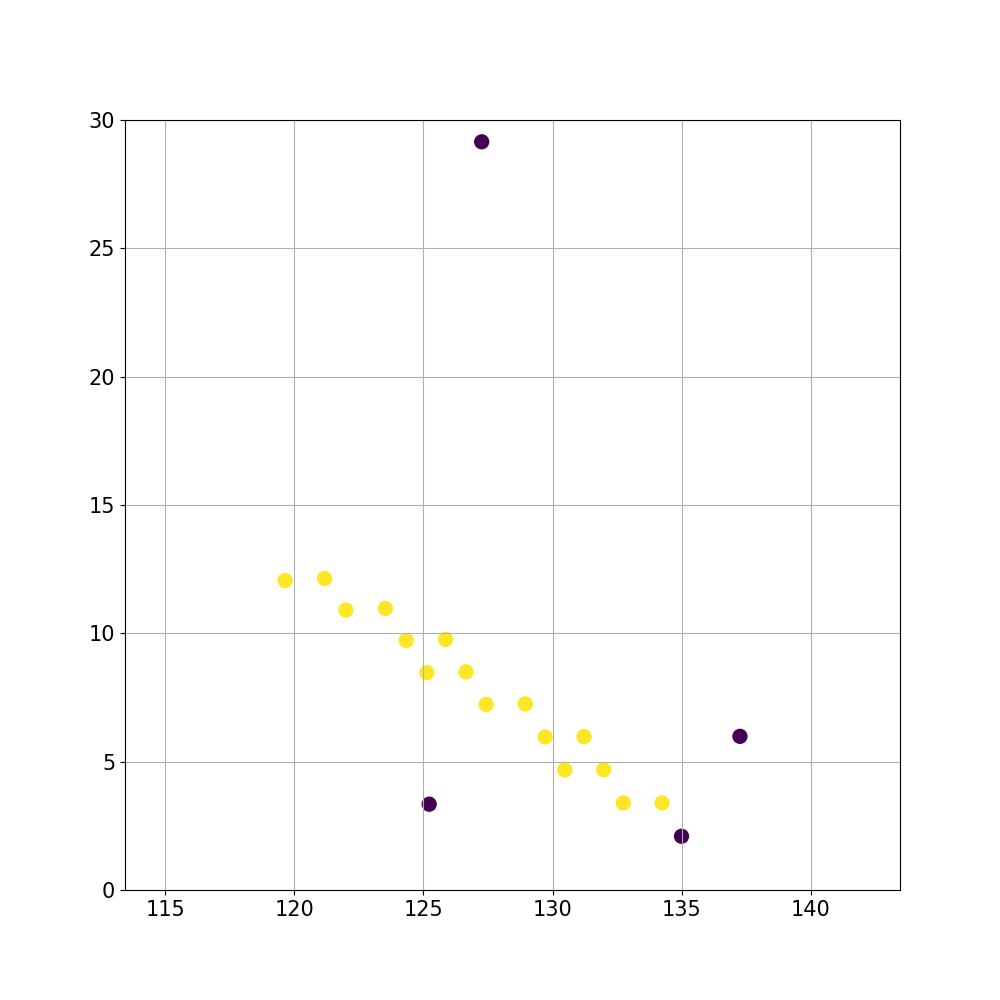

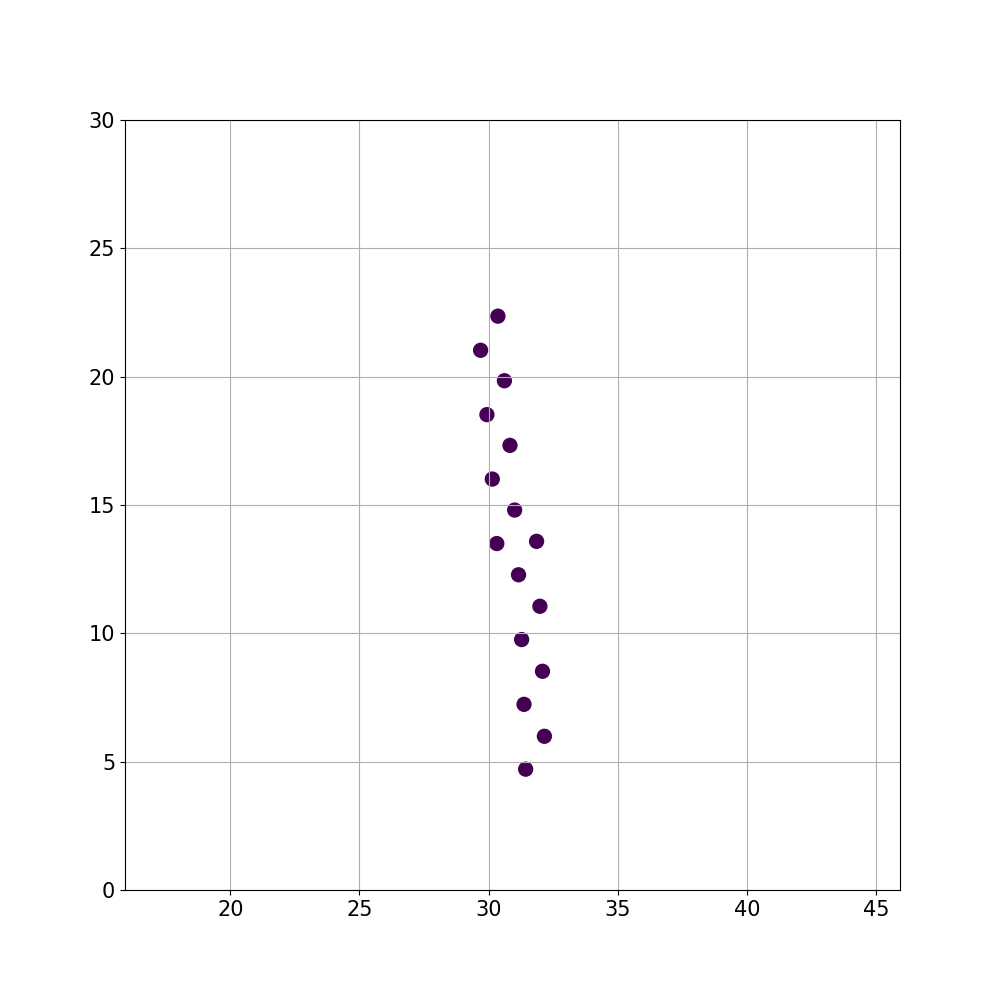

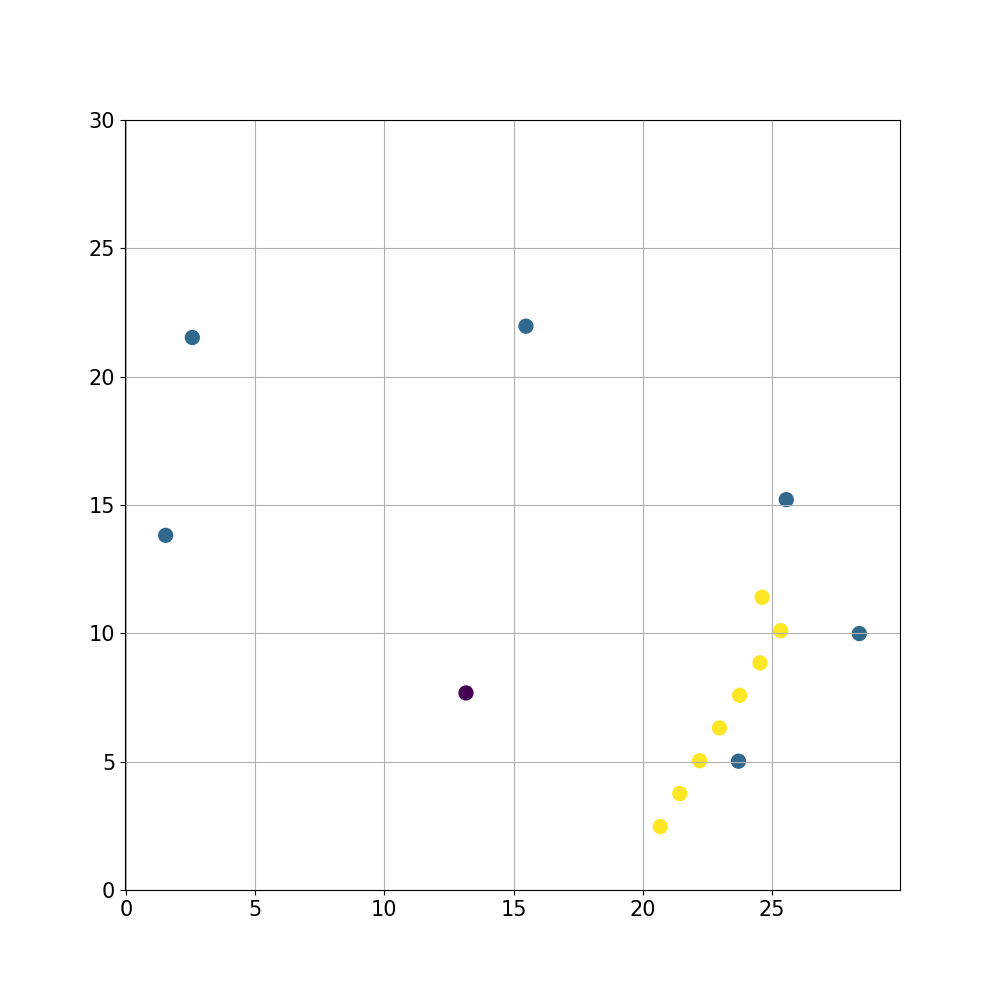

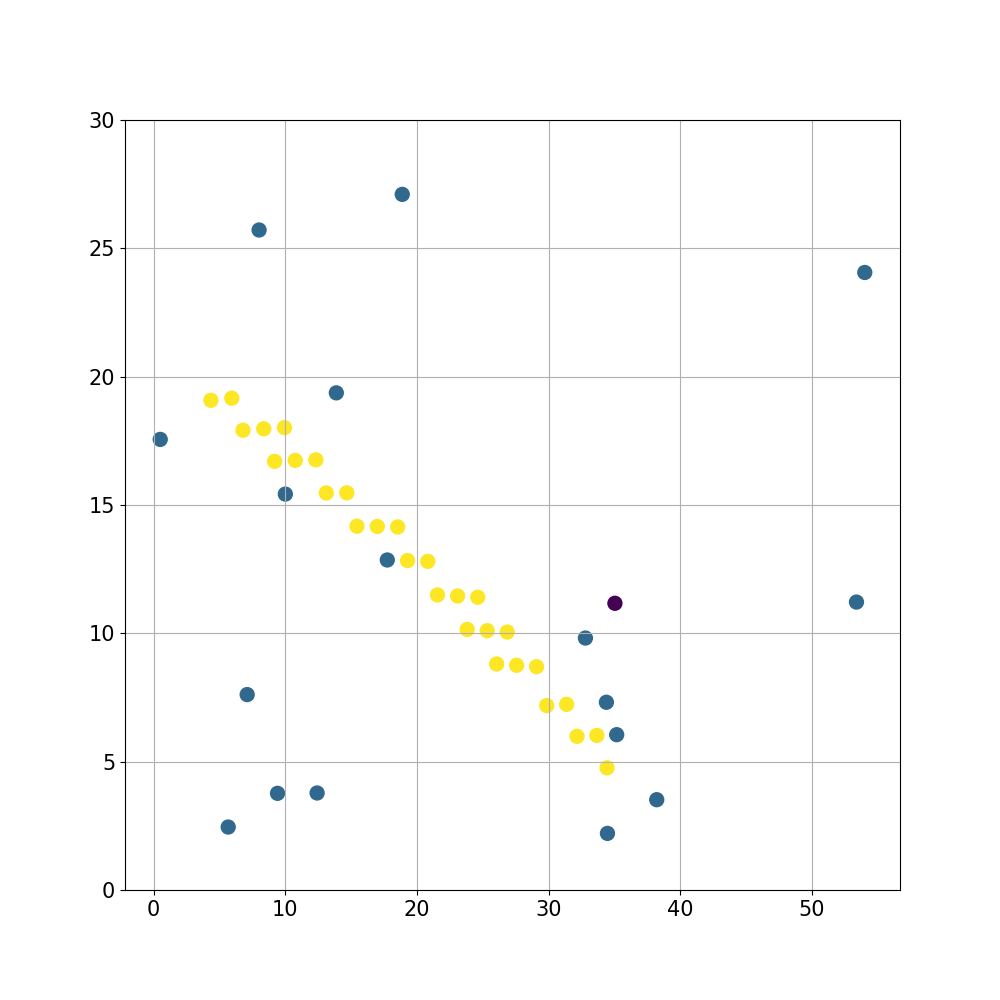

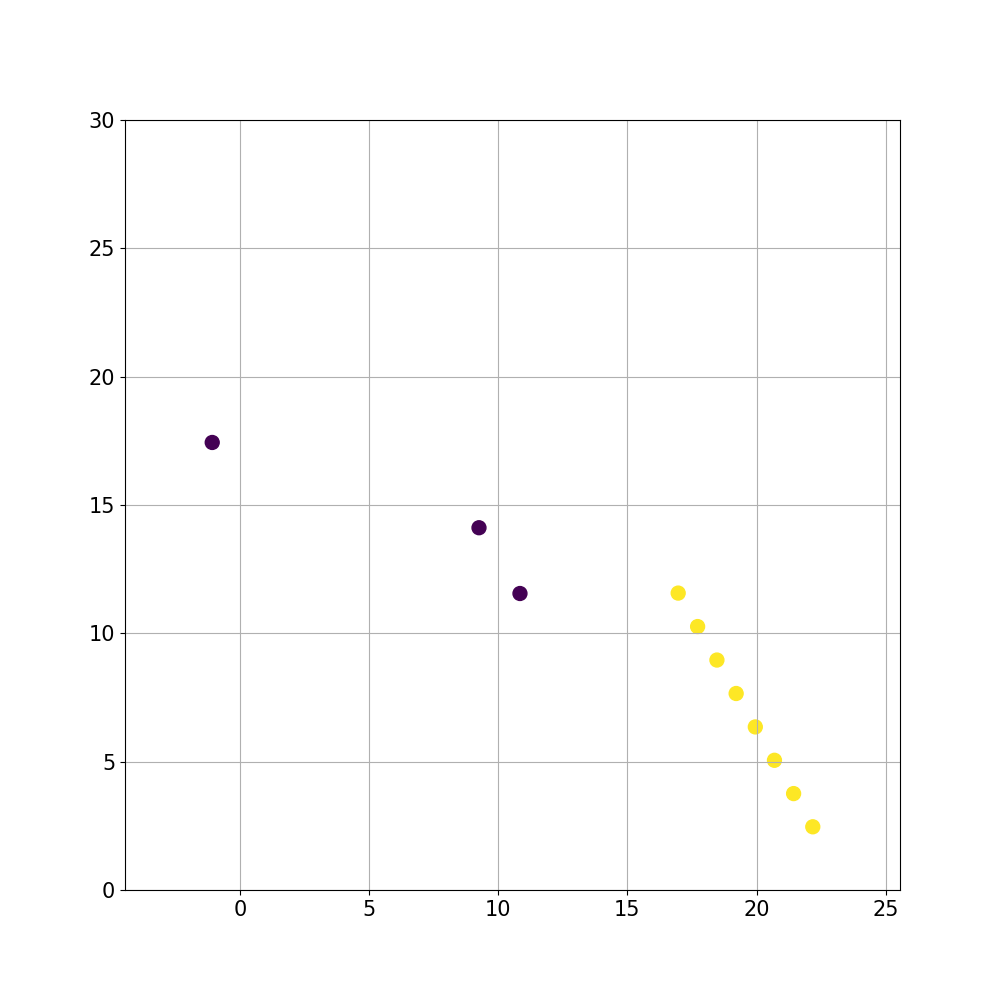

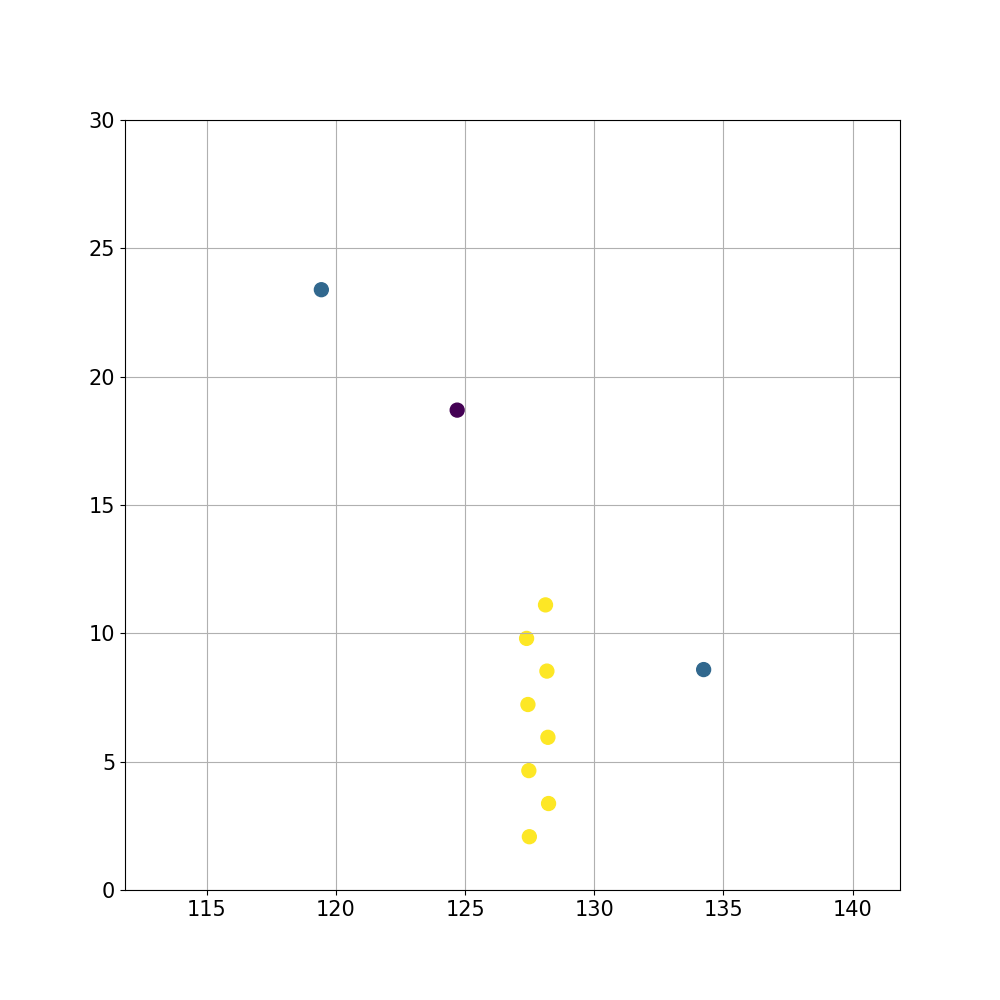

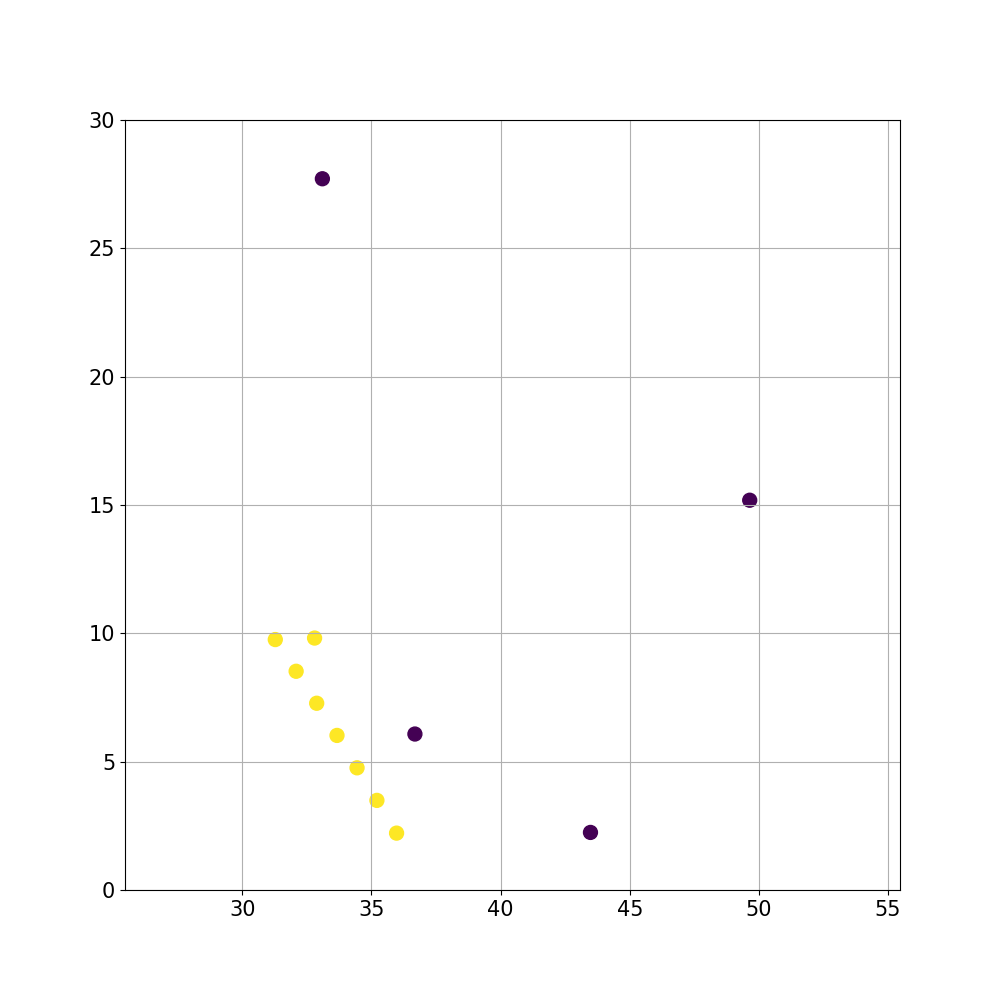

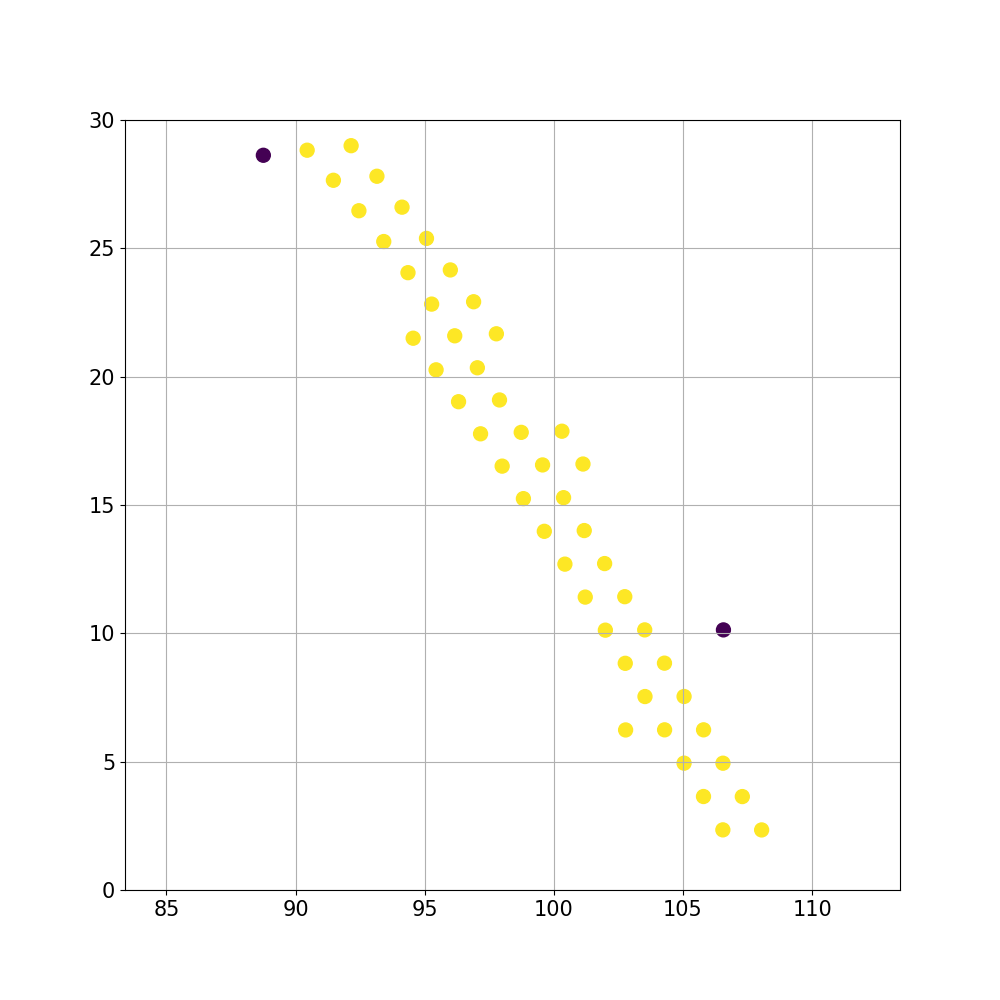

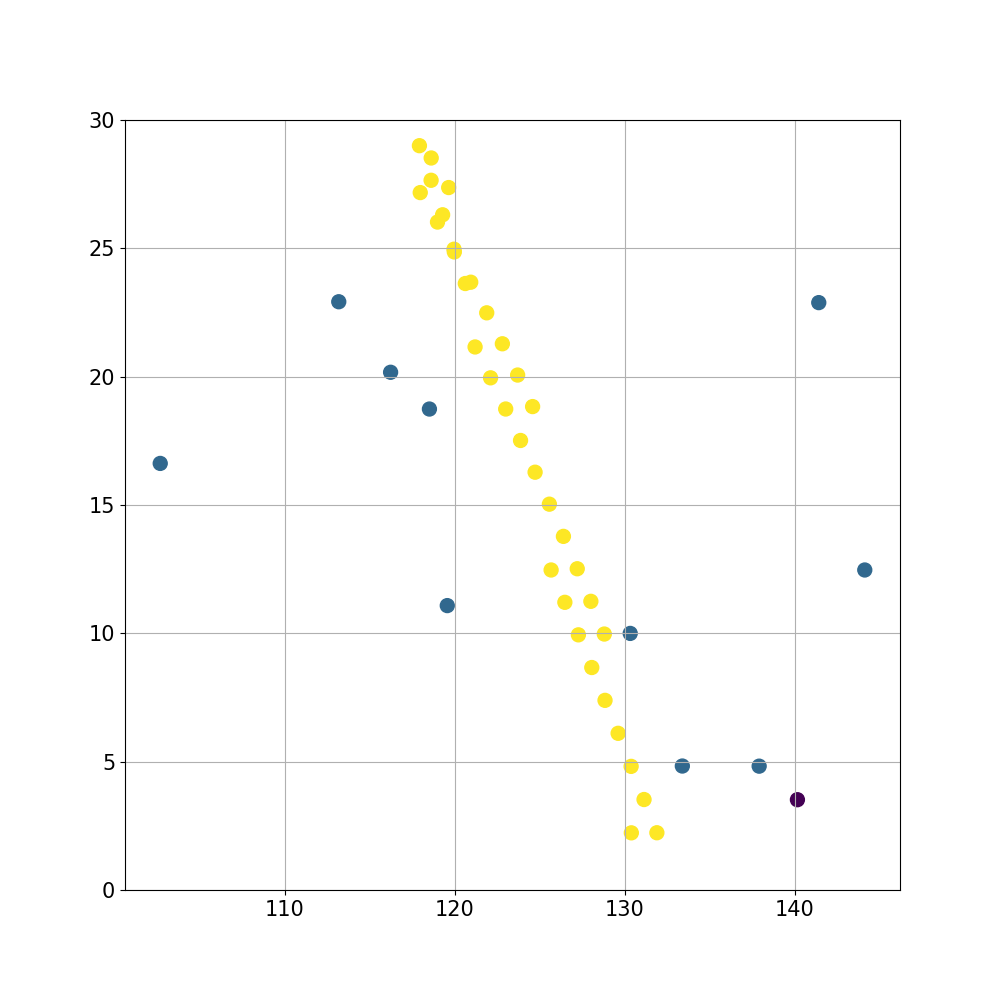

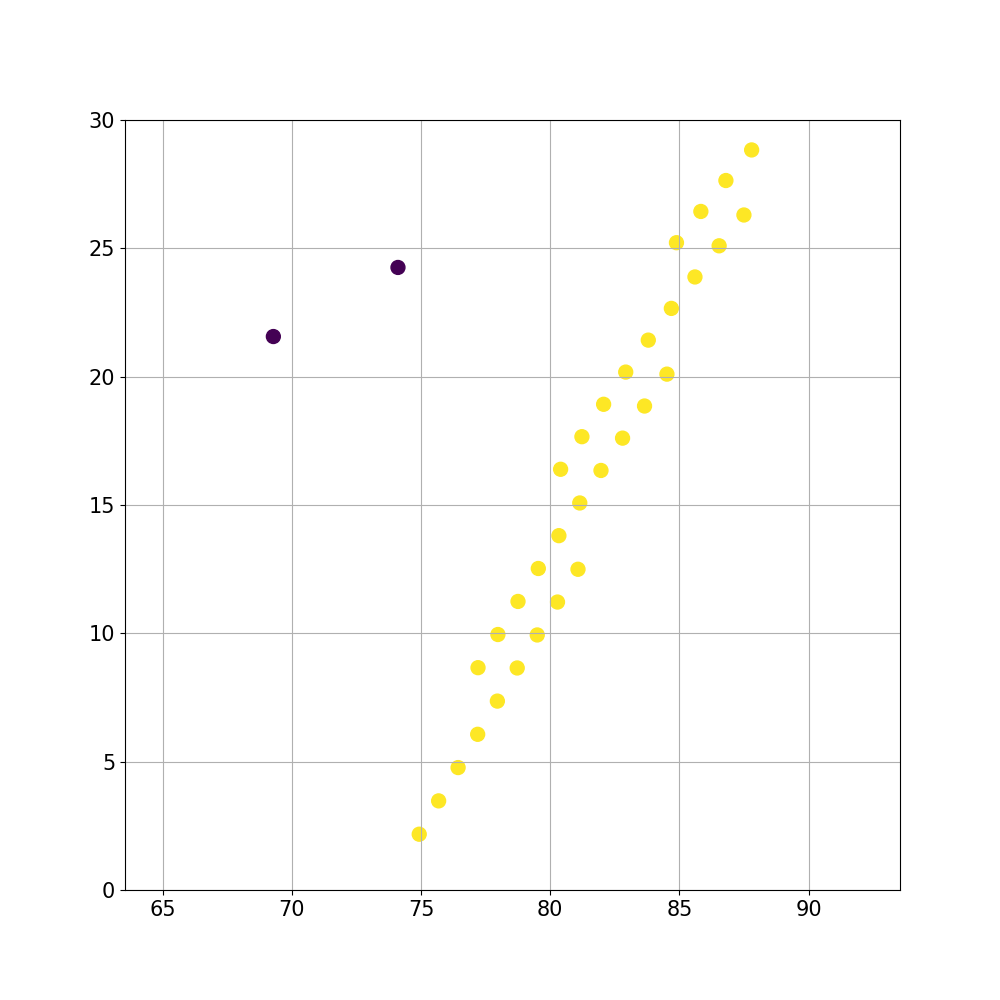

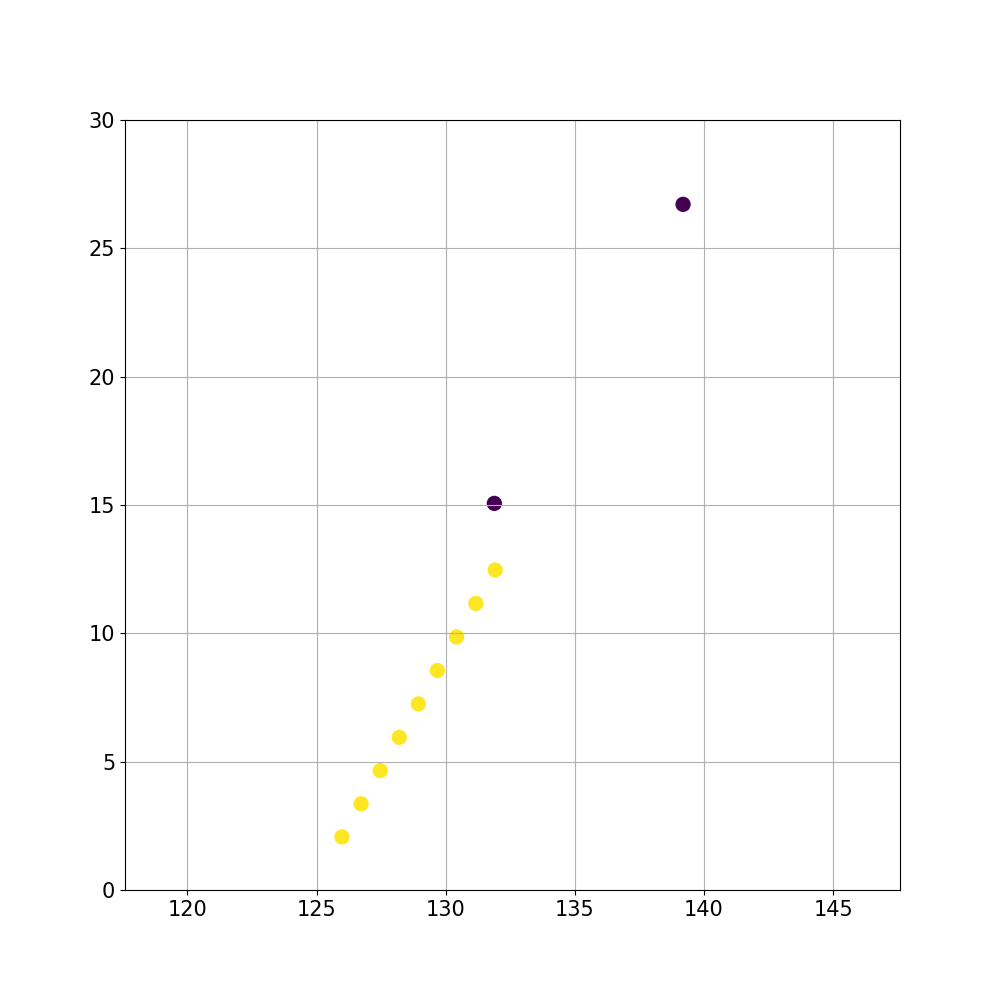

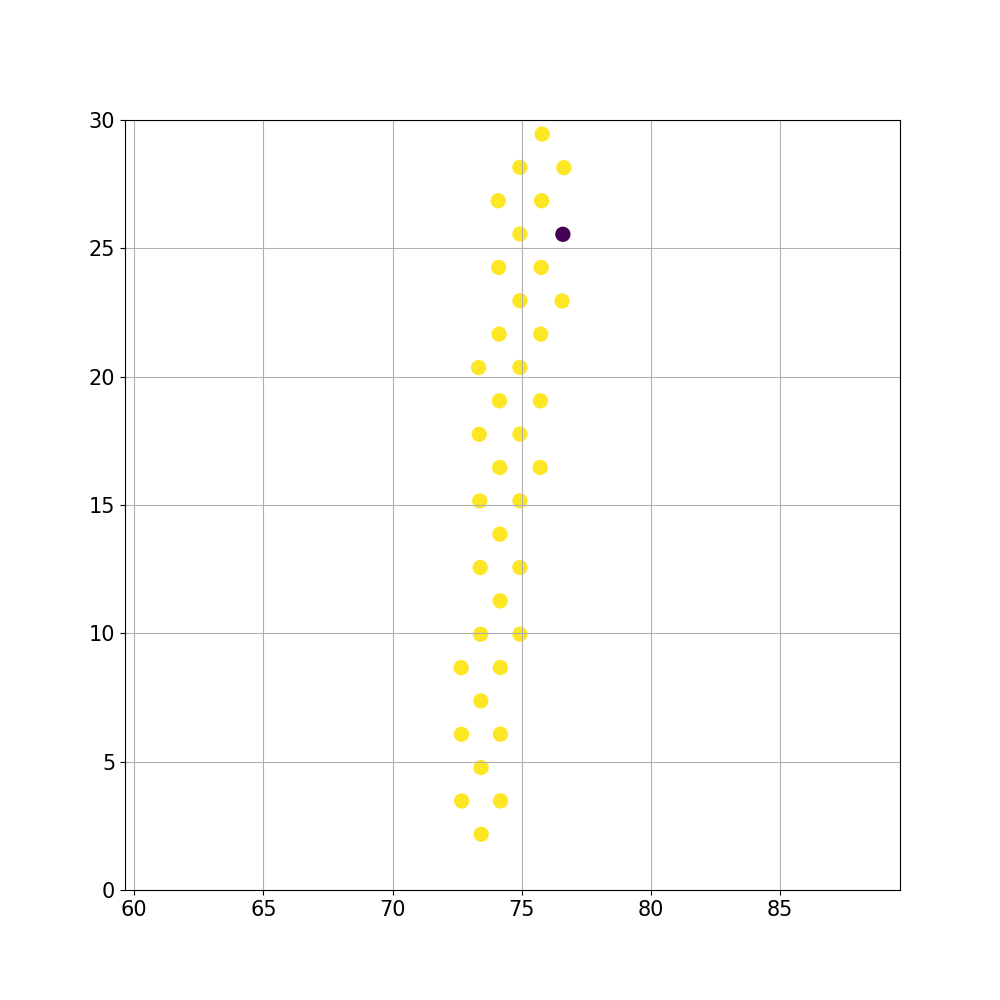

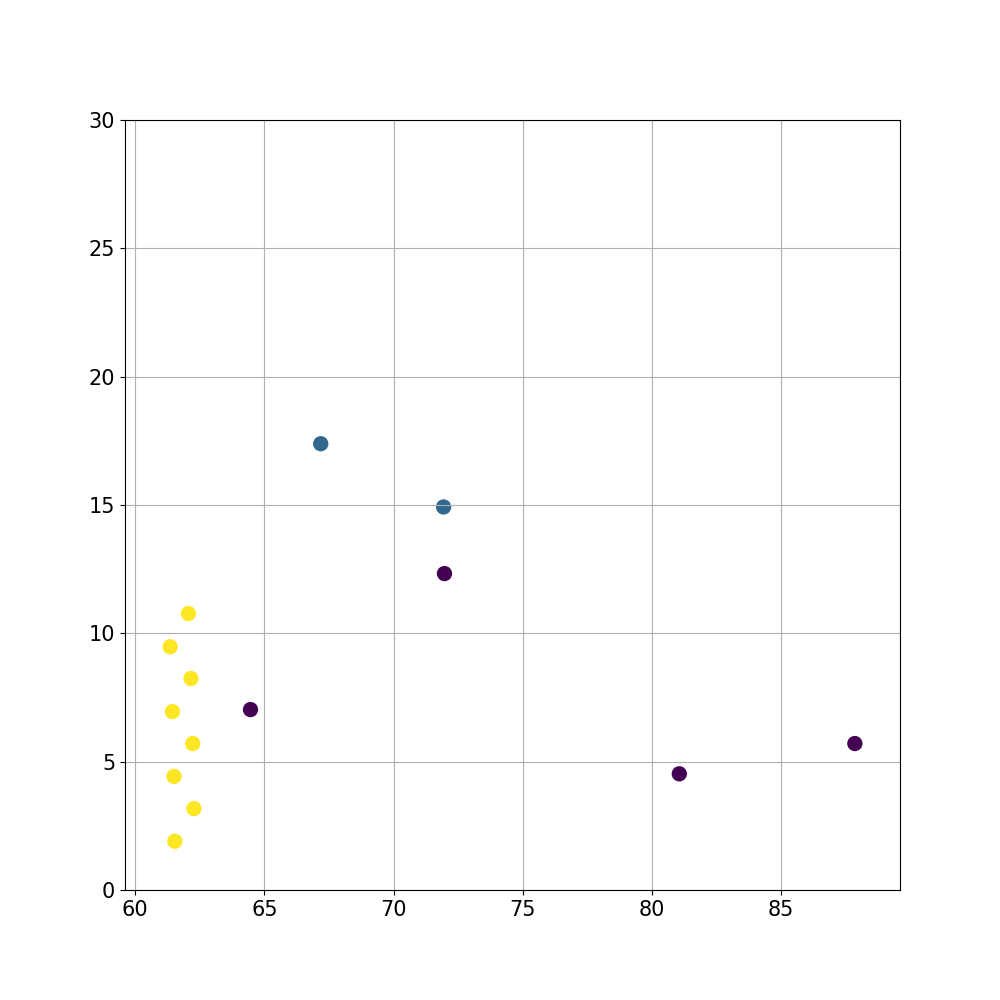

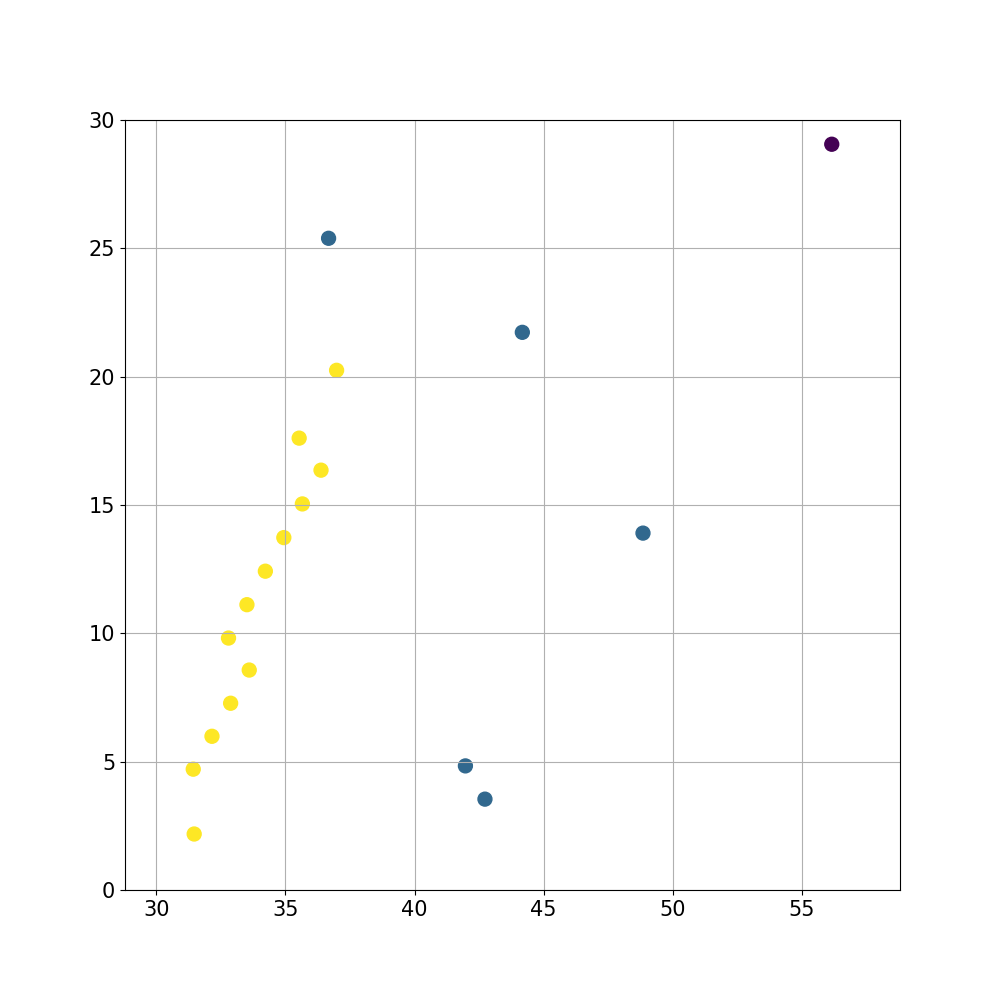

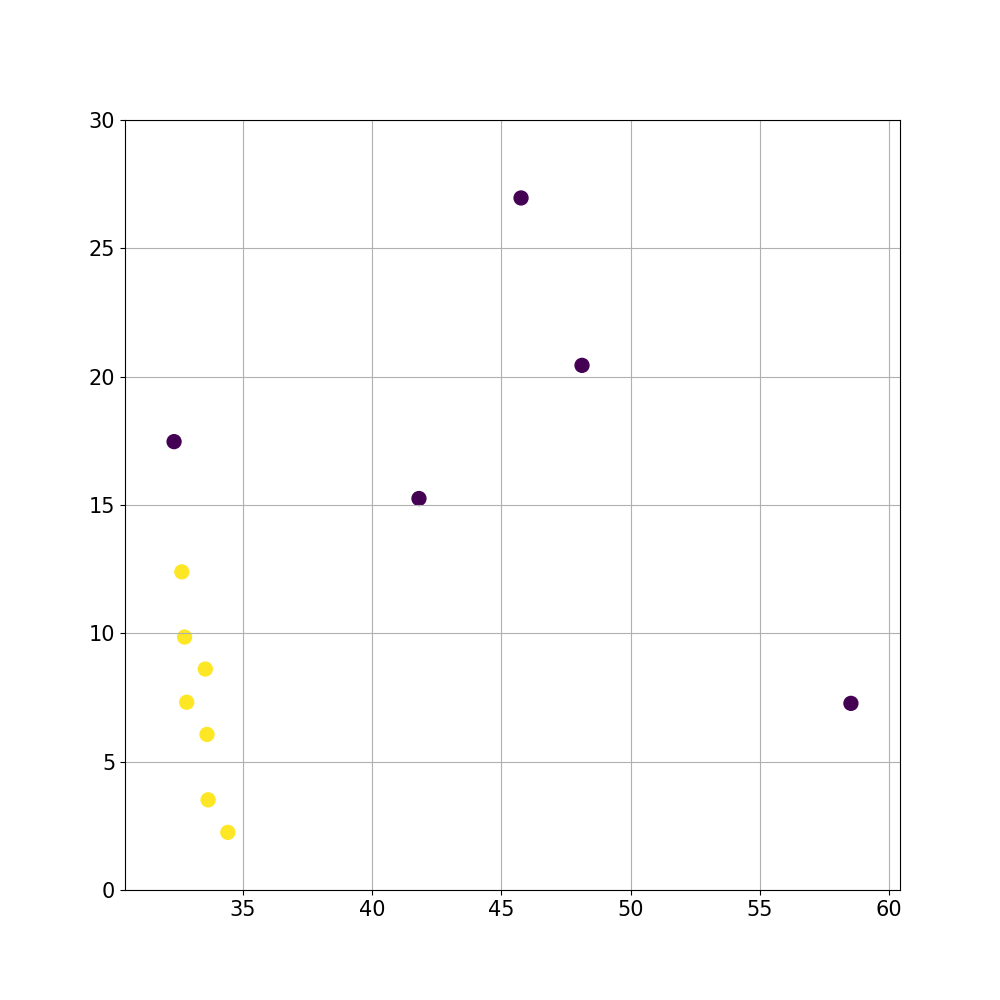

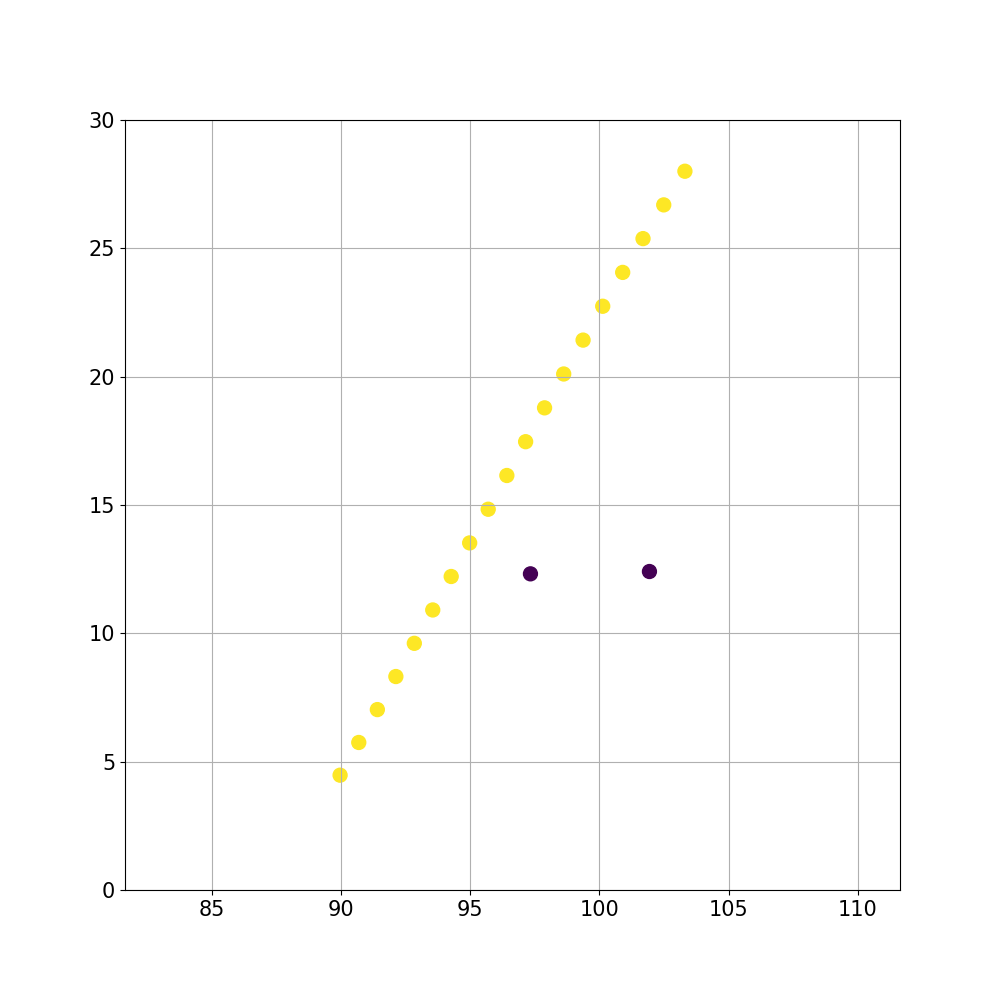

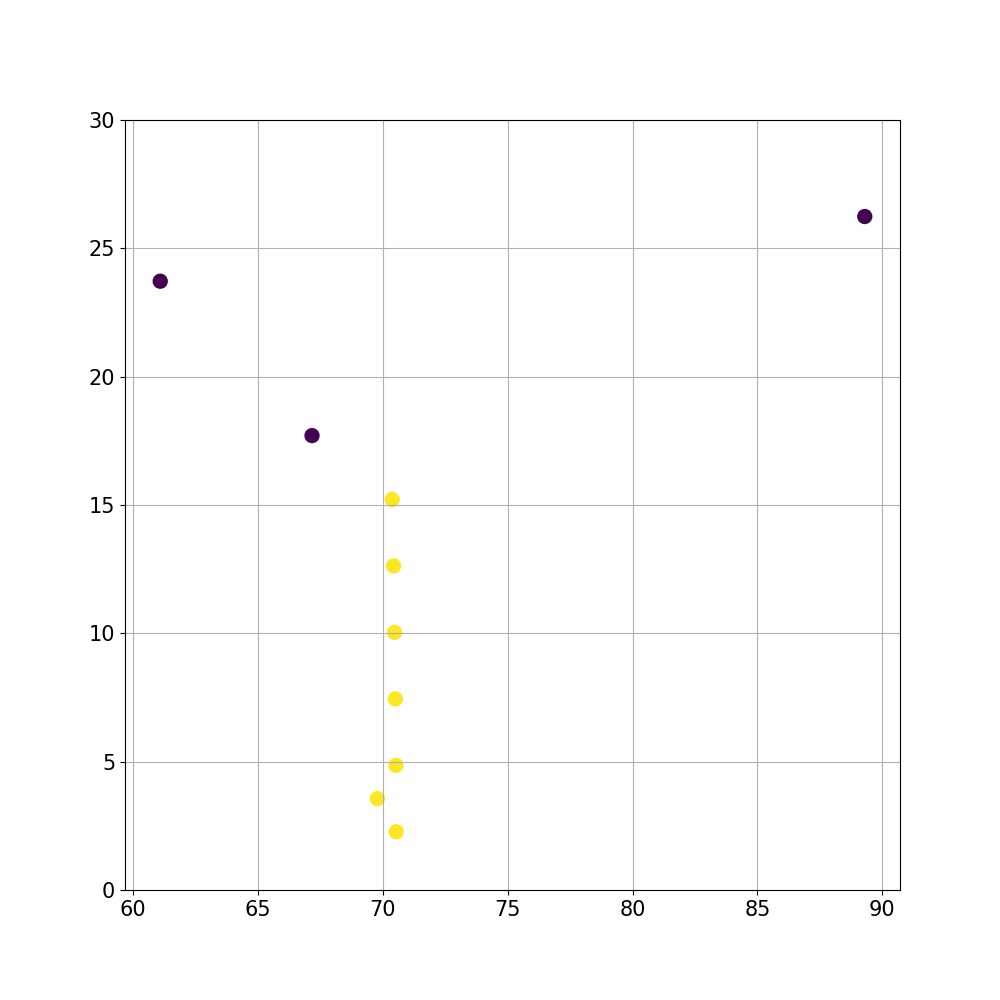

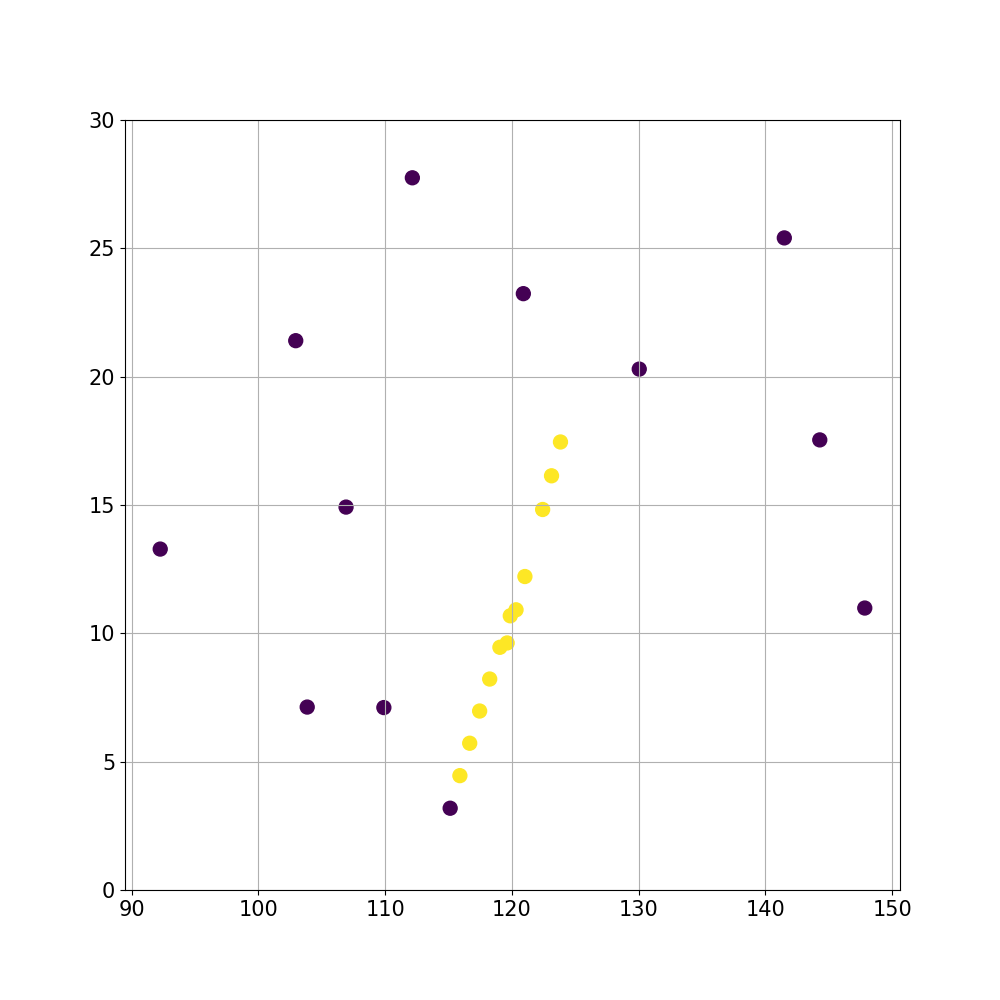

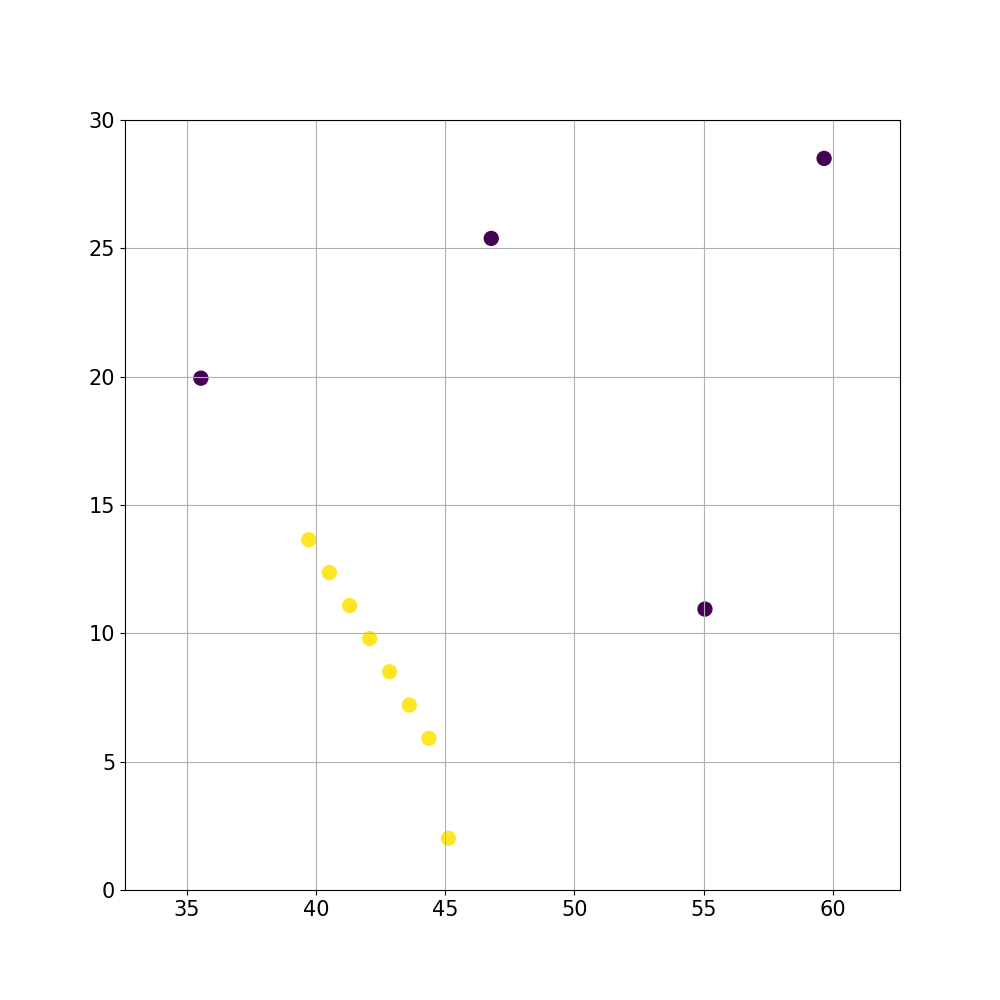

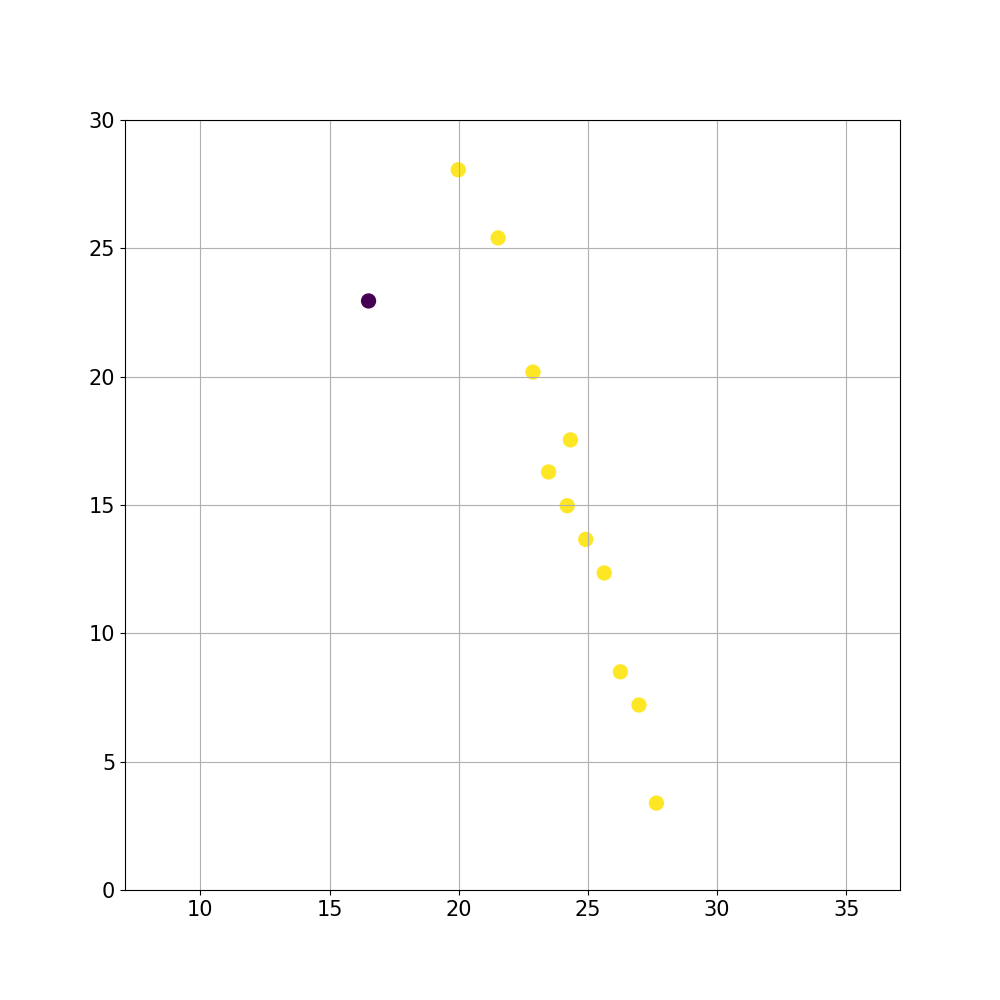

In [194]:
for event in Dataset:
    Pix_Phi   = event.get_pixel_values('Phi')
    Pix_Theta = event.get_pixel_values('Theta')
    status    = event.get_pixel_values('Status')
    plt.figure(figsize=[10,10])
    plt.scatter(Pix_Phi,90-Pix_Theta,s=100,c=status)
    plt.grid()
    plt.ylim([0,30])

    # Check xlim of the axis
    xlim = plt.gca().get_xlim()
    # print(xlim)
    if xlim[1] - xlim[0] < 30:
        middle = (xlim[0] + xlim[1]) / 2
        plt.xlim(middle - 15, middle  + 15)

    # plt.gca().invert_xaxis()
    plt.show()

# Previous Code can be found in TestingDataset_0.ipynb
